This is going to be the second work of my PhD focusing on extreme MIMO and increasing the ML capabilities during beam management. In particular, we will now extend to include CSI-RS codebooks generated by ML as well as adding additional or replacement feedback encoding for the PMI based on the actual received CSI-RS beamformers. We will also be using limited resolution hybrid architecture and much larger arrays. All told this will be a massive codebase.

In [ ]:
import numpy as np
import numba
import time
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import h5py
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "colab"
from statsmodels.distributions.empirical_distribution import ECDF
import sys
import datetime
import inspect
from math import sqrt
import logging
import cProfile
import seaborn as sns
from sklearn.model_selection import train_test_split
from functools import partial
from itertools import cycle, product
import gc
import cProfile
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False

import sionna

from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel # CIRDataset


logger = logging.getLogger("numba");
logger.setLevel(logging.ERROR)

np.set_printoptions(precision=3)

indexer = 1

gpu_mem = tf.config.list_physical_devices('GPU')[0]
gpu2_mem = tf.config.list_physical_devices('GPU')[1]

tf.config.experimental.set_memory_growth(gpu_mem, True)
tf.config.experimental.set_memory_growth(gpu2_mem, True)

gpu = tf.config.list_logical_devices('GPU')[0]
gpu2 = tf.config.list_logical_devices('GPU')[1]

if os.name == 'nt':  # running windows
    path = r'G:/SSB_Data/data_proc/XMIMO_{}/'.format(indexer)
else:
    path = r'/media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_{}/'.format(indexer)
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import mixed_precision
    # policy = mixed_precision.Policy('mixed_float16')
    # mixed_precision.set_global_policy(policy)
    import keras_tuner

    from keras import backend as K
    print("tf version = ",tf.__version__)
    print(tf.config.list_physical_devices())

    !nvidia-smi

2024-03-08 09:10:55.120653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf version =  2.11.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Fri Mar  8 09:10:58 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0C:00.0 Off |                  N/A |
|  0%   21C    P2    84W / 430W |    476MiB / 24576MiB |      2%      Default |
|                           

In [ ]:
# constants
pi = np.pi
fc = 10e9
ctype = np.complex64
Nx = 16
Ny = 16
Nt = Nx*Ny
Nr = 4

Nx1 = 16
Ny1 = 16
Lmax = 16

theta_steps = Nx1
phi_steps = Ny1

Nxd = 8
Nyd = 4
b_phaseshifter = 2

theta_min = 3*pi/24
theta_max = 21*pi/24
phi_min = 3*pi/24
phi_max = 21*pi/24

thetas = np.linspace(theta_min, theta_max, num=theta_steps) # / 180 * np.pi
# symmetric about 0-180/180-360 by ULA processing
phis = np.linspace(phi_min, phi_max, num=phi_steps) #/ 180 * np.pi

subcarrier_spacing = 30e3
Ktotal = 270

matplotlib.rcParams['figure.figsize'] = [3.25, 2.5]
matplotlib.rcParams['font.size'] = 5
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
import ctypes
mkl_rt = ctypes.CDLL('libmkl_rt.so')
mkl_get_max_threads = mkl_rt.MKL_Get_Max_Threads
print(mkl_get_max_threads())
mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(1)))
print(mkl_get_max_threads())

numba.set_num_threads(12) # should not be all threads, ends up being slower with communication overhead

# Sets MKL to only use 1 core. This speeds up the MU-MIMO computation by 3x without parallizing, and another 6x with parallel

In [ ]:
# utility functions
from sklearn.neighbors import KernelDensity


def pdf_plot(data, xmin=0, xmax=15, label="", markers='-*', markevery=1000,):
    x_d = np.linspace(xmin, xmax, 2000)
    kde = KernelDensity(bandwidth=0.25, kernel='gaussian')
    kde.fit(data[:, None])
    logprob = kde.score_samples(x_d[:, None])
    # plt.fill_between(x_d, np.exp(logprob), alpha=0.5, label=label, )
    plt.plot(x_d, np.exp(logprob), markers, markevery=markevery, label=label)
    return np.exp(logprob)


def logx(x):
    return 10*np.log10(x)

@tf.function()
def tf_10log10(x):
  numerator = tf.math.log(x+1e-15)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return 10*numerator / denominator

def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

def np_kmax(array, k):
    # returns the K-max points from an array
    indices = np.argpartition(array, -k)[-k:]
    return array[indices]

def np_kargmax(array, k):
    indices = np.argpartition(array, -k)[-k:]
    return indices

def smoothing_filter(x, N=20):
    """
    Applies an N-point smoothing filter to data, generally for plotting. Data at the end of the array has less smoothing
    :param x: 1D data
    :param N: Number of samples to use for the moving filter
    :return: smoothed 1D data of equal size
    """
    xcopy = x.copy()
    xcopy[:-N+1] = np.convolve(x, np.ones(N)/N, mode='valid')
    for i in range(1, N):
        xcopy[-i] = np.mean(xcopy[-N+i:])
    return xcopy

@numba.jit(nopython=True)
def nb_mean_0(tensor):
    units = tensor.shape
    outputs = np.zeros((units[1:]), dtype=ctype)
    for i in numba.prange(units[0]):
        outputs = outputs + tensor[i]
    return outputs/units[0]

@numba.jit(parallel=True, nopython=True)
def nb_det(tensor):
    outputs = np.zeros((len(tensor)), dtype=ctype)
    for i in numba.prange(len(tensor)):
        outputs[i] = np.linalg.det(tensor[i])
    return outputs

@numba.jit(nopython=True)
def nb_svd(H):
    units = H.shape
    U = np.zeros((units[0], units[1], units[1]), dtype=ctype)
    S = np.zeros((units[0], units[1]), dtype=ctype)
    V = np.zeros((units[0], units[2], units[2]), dtype=ctype)
    for i in numba.prange(len(H)):
        U[i, :, :], S[i, :], V[i, :, :] = np.linalg.svd(H[i])
    return U, S, V

# @numba.jit(fastmath=True, nopython=True)
def array_resp(theta, N, lambda_c=1, d=None):
    """
    Returns the array response for a ULA in direction theta with N antenna elements. Defaults to lambda/2 spacing
    :param theta: Direction of interest for array response
    :param N: Number of antenna elements
    :param lambda_c: wavelength, although this only needs to be relative to d so it is often not necessary.
    :param d: antenna element spacing. Defaults to lamba_c/2.
    :return: the n-point array response of a ULA
    """
    if d is None or d is False:
        d = lambda_c / 2
    n = np.expand_dims(np.arange(N), axis=1)
    vander = np.exp((1j * pi * 2 * n * d * np.cos(theta)) / lambda_c).astype(ctype).T
    return vander


def steering_vectors(thetas, phis, Nx=1, Ny=1, d=0.5):
    # Define the steering vector for a planar array of size Nrx by Nry with spacing (in wavelengths) d.
    # thetas and phis can have size greater than 1 for batch approaches
    n_theta = len(thetas)
    n_phi = len(phis)
    steering_mtx = np.zeros((n_theta, n_phi, Nx, Ny), dtype=np.complex64)
    # print(steering_mtx.shape, array_resp(thetas, Nx, d).shape)
    steering_xs = array_resp(thetas, Nx, d)
    steering_ys = array_resp(phis, Ny, d)
    # Now cross terms to achieve the beamforming matrices
    steering_mtx[:] = np.einsum('ij,kl->ikjl', steering_xs, steering_ys)
    steering_vector = steering_mtx.reshape(n_theta, n_phi, Nx*Ny)
    return steering_vector


@numba.jit(fastmath=True, nopython=True)
def pattern_ijk(theta, phi, Nx, Ny, V):
    x = np.abs(array_resp(phi, Ny) @ V.conj().T @  array_resp(theta, Nx).T)**2

def subgroup_channels(H, subtimes=1, subbands=1):
    # Channel size is made to fit a number of subtimes and subbands for one user
    # returns H_bar in [subtimes, subbands, Nt, Nr]
    if len(H.shape) == 2: # H is just
        H = np.expand_dims(np.expand_dims(H, 0), 0)
    elif len(H.shape) == 3:
        H = np.expand_dims(H, 0)
    elif len(H.shape) != 4:
        raise AssertionError("Error, shape of channels is {H.shape}, but should be 2, 3, or 4 dimensional")
    units = np.array(H.shape).astype(np.int16)  # [time, sc, Nr, Nt]
    # must iteratively split the channel into subbands/subtimes and average to obtain best discrete precoder
    if subbands != units[1]:
        # try:
        H_subbands = np.array_split(H, subbands, axis=1)
        H_bar = np.zeros((subbands, units[0], units[2], units[3]), dtype=ctype)
        for i in range(subbands):
            H_bar[i, :, :, :] = nb_mean_0(np.transpose(H_subbands[i][:, :, :, :], (1, 0, 2, 3)))
    else:
        H_bar = H.transpose(1, 0, 2, 3)
    if subtimes != units[0]:
        try:
            H_subbands = np.array_split(H_bar, subtimes, axis=1)  # has shape [subtimes, subbands, Nt, Nr]
        except Exception:
            largest_ind = (H.shape[1]//subtimes)*subtime
            H_subbands = np.array_split(H_bar[:, :largest_ind], subbands, axis=1)
        H_bar = np.zeros((subtimes, subbands, units[2], units[3]), dtype=ctype)
        for i in range(subtimes):
            H_bar[i, :, :, :] = nb_mean_0(np.transpose(H_subbands[i][:, :, :, :], (1, 0, 2, 3)))
    else:
        H_bar = H_bar.transpose(1, 0, 2, 3)
    return H_bar.astype(ctype)



def DFT_codebook(n_beams=8, Nx=4, Ny=8, OH=1, OV=1, **kwargs):
    # DFT where n_beams decides how many beams are given. For n_beams<Nt some antennas are not used at all
    # for wider beams
    test_bf = np.zeros((n_beams, Nx*Ny, 1), dtype=ctype)
    Nt = Nx * Ny
    print(f"Generating codebook for {n_beams} from size {Nx}x{Ny}x{OH}x{OV}")
    if n_beams >= Nx*Ny*OH*OV:
        test_bf[:, :, 0] = gen_codebook(Nx=Nx, Ny=Ny, OH=OH, OV=OV)
    else:
        test_bf = np.zeros((n_beams, Nx, Ny), dtype=ctype)
        if n_beams <= 8:
            Nx1 = 2
        elif n_beams <= 32:
            Nx1 = 4
        else:
            Nx1 = 8
        Ny1 = n_beams//Nx1
        DFT_x = np.fft.fft(np.eye(Nx1)) / np.sqrt(Nx1)
        DFT_y = np.fft.fft(np.eye(Ny1)) / np.sqrt(Ny1)
        for nx in range(Nx1):
            for ny in range(Ny1):
                test_bf[nx*Ny1+ny, Nx//2-Nx1//2:Nx//2+Nx1//2, Ny//2-Ny1//2:Ny//2+Ny1//2] = DFT_x[:, nx:nx+1] @ DFT_y[ny:ny+1, :]
        test_bf = test_bf.reshape(n_beams, Nt, 1)

    test_bf = test_bf / np.linalg.norm(test_bf, axis=(1), keepdims=True) * np.sqrt(Nt)
    return test_bf

def gen_codebook(Nx, Ny, OH=1, OV=1, **kwargs):
    # generate codebooks of size [Nx*Ny*OH*OV, Nt] from DFT codebooks
    Nt = Nx * Ny
    zero_pad_eye_y = np.eye(Ny*OV)
    zero_pad_eye_x = np.eye(Nx*OH)
    DFT_y = np.fft.fft(zero_pad_eye_y)[:, :Ny] / np.sqrt(Ny)
    DFT_x = np.fft.fft(zero_pad_eye_x)[:Nx, :] / np.sqrt(Nx)

    all_codebook = np.zeros((Nx*OH*Ny*OV, Nx, Ny), dtype=ctype)
    for i in range(OH*Nx):
        for j in range(OV*Ny):
            all_codebook[i*OV*Ny + j, :, :] = DFT_x[:, i:i+1] @ DFT_y[j:j+1, :]
    all_codebook = all_codebook.reshape(Nx*OH*Ny*OV, Nt).astype(ctype)
    return all_codebook


stx = steering_vectors(thetas, phis, Nx, Ny)

U_NyNy = np.array([array_resp(phis[i], Ny) for i in range(Ny1)]).astype(ctype)[:, 0, :]
U_NxNx = np.array([array_resp(thetas[i], Nx) for i in range(Nx1)]).astype(ctype)[:, 0, :].T

U_NyNy_inv = np.linalg.pinv(U_NyNy)
U_NxNx_inv = np.linalg.pinv(U_NxNx)

U_NyNy = U_NyNy / np.linalg.norm(U_NyNy, 'fro')
U_NxNx = U_NxNx / np.linalg.norm(U_NxNx, 'fro')
U_NyNy_inv = U_NyNy_inv / np.linalg.norm(U_NyNy_inv, 'fro')
U_NxNx_inv = U_NxNx_inv / np.linalg.norm(U_NxNx_inv, 'fro')

tf_U_NyNy = tf.constant(U_NyNy, dtype=tf.complex64)
tf_U_NxNx = tf.constant(U_NxNx, dtype=tf.complex64)
tf_U_NyNy_inv = tf.constant(U_NyNy_inv, dtype=tf.complex64)
tf_U_NxNx_inv = tf.constant(U_NxNx_inv, dtype=tf.complex64)

# Generate channels (Sionna)

In [ ]:
scene_id = 'B'
en_scat = False # enables scattering in Sionna
en_diff = True  # enables diffraction in Sionna
scat_prob = 1e-5


if scene_id == 'A':
    scene = load_scene(sionna.rt.scene.munich)
    # scene = load_scene()
    my_cam = Camera("my_cam", position=[-250,250,150], look_at=[-15,30,28])
    scene.add(my_cam)
    tx = Transmitter(name="tx", position=[8.5,21,40], orientation=[1.25, 0, 0])
    rx = Receiver(name="rx", position = [0, 0, 1.5])
    rx.look_at(tx)
elif scene_id == 'B':
    fc = 20e9
    scene = load_scene(sionna.rt.scene.etoile)
    my_cam = Camera("my_cam", position=[-250,250,150], look_at=[-15,30,28])
    scene.add(my_cam)
    tx = Transmitter(name="tx", position=[-140,40,27])
    rx = Receiver(name="rx", position = [0, 0, 1.5])
    rx.look_at(tx)
else:
    scene = load_scene()
    tx = Transmitter(name="tx", position=[-33, 11., 32], orientation=[1.25, 0, 0])
    rx = Receiver(name="rx", position = [0, 0, 1.5])

scene.frequency = fc
scene.add(tx)
scene.add(rx)

scene.tx_array = PlanarArray(num_rows=1,
                            num_cols=1,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern="tr38901",
                            polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                            num_cols=1,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern="iso",
                            polarization="V")


scene.synthetic_array = True
cm_size = (400, 400.)
center_loc = np.array([tx.position[0], tx.position[1] + cm_size[1]/2, 2])
# center_loc = [0, 0, 0]
cm = scene.coverage_map(max_depth=5, cm_cell_size=(5, 5), cm_size=cm_size, cm_center=center_loc, cm_orientation=(0, 0, 0.), num_samples=10e6, scattering=en_scat, diffraction=en_diff)

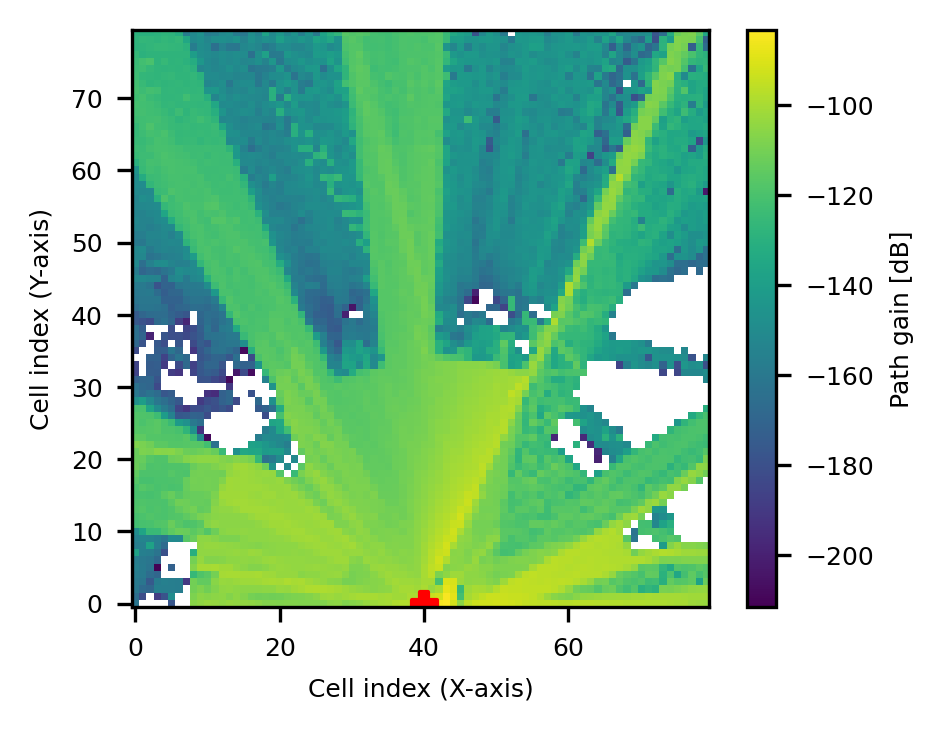

In [ ]:
cm.show(tx=0);

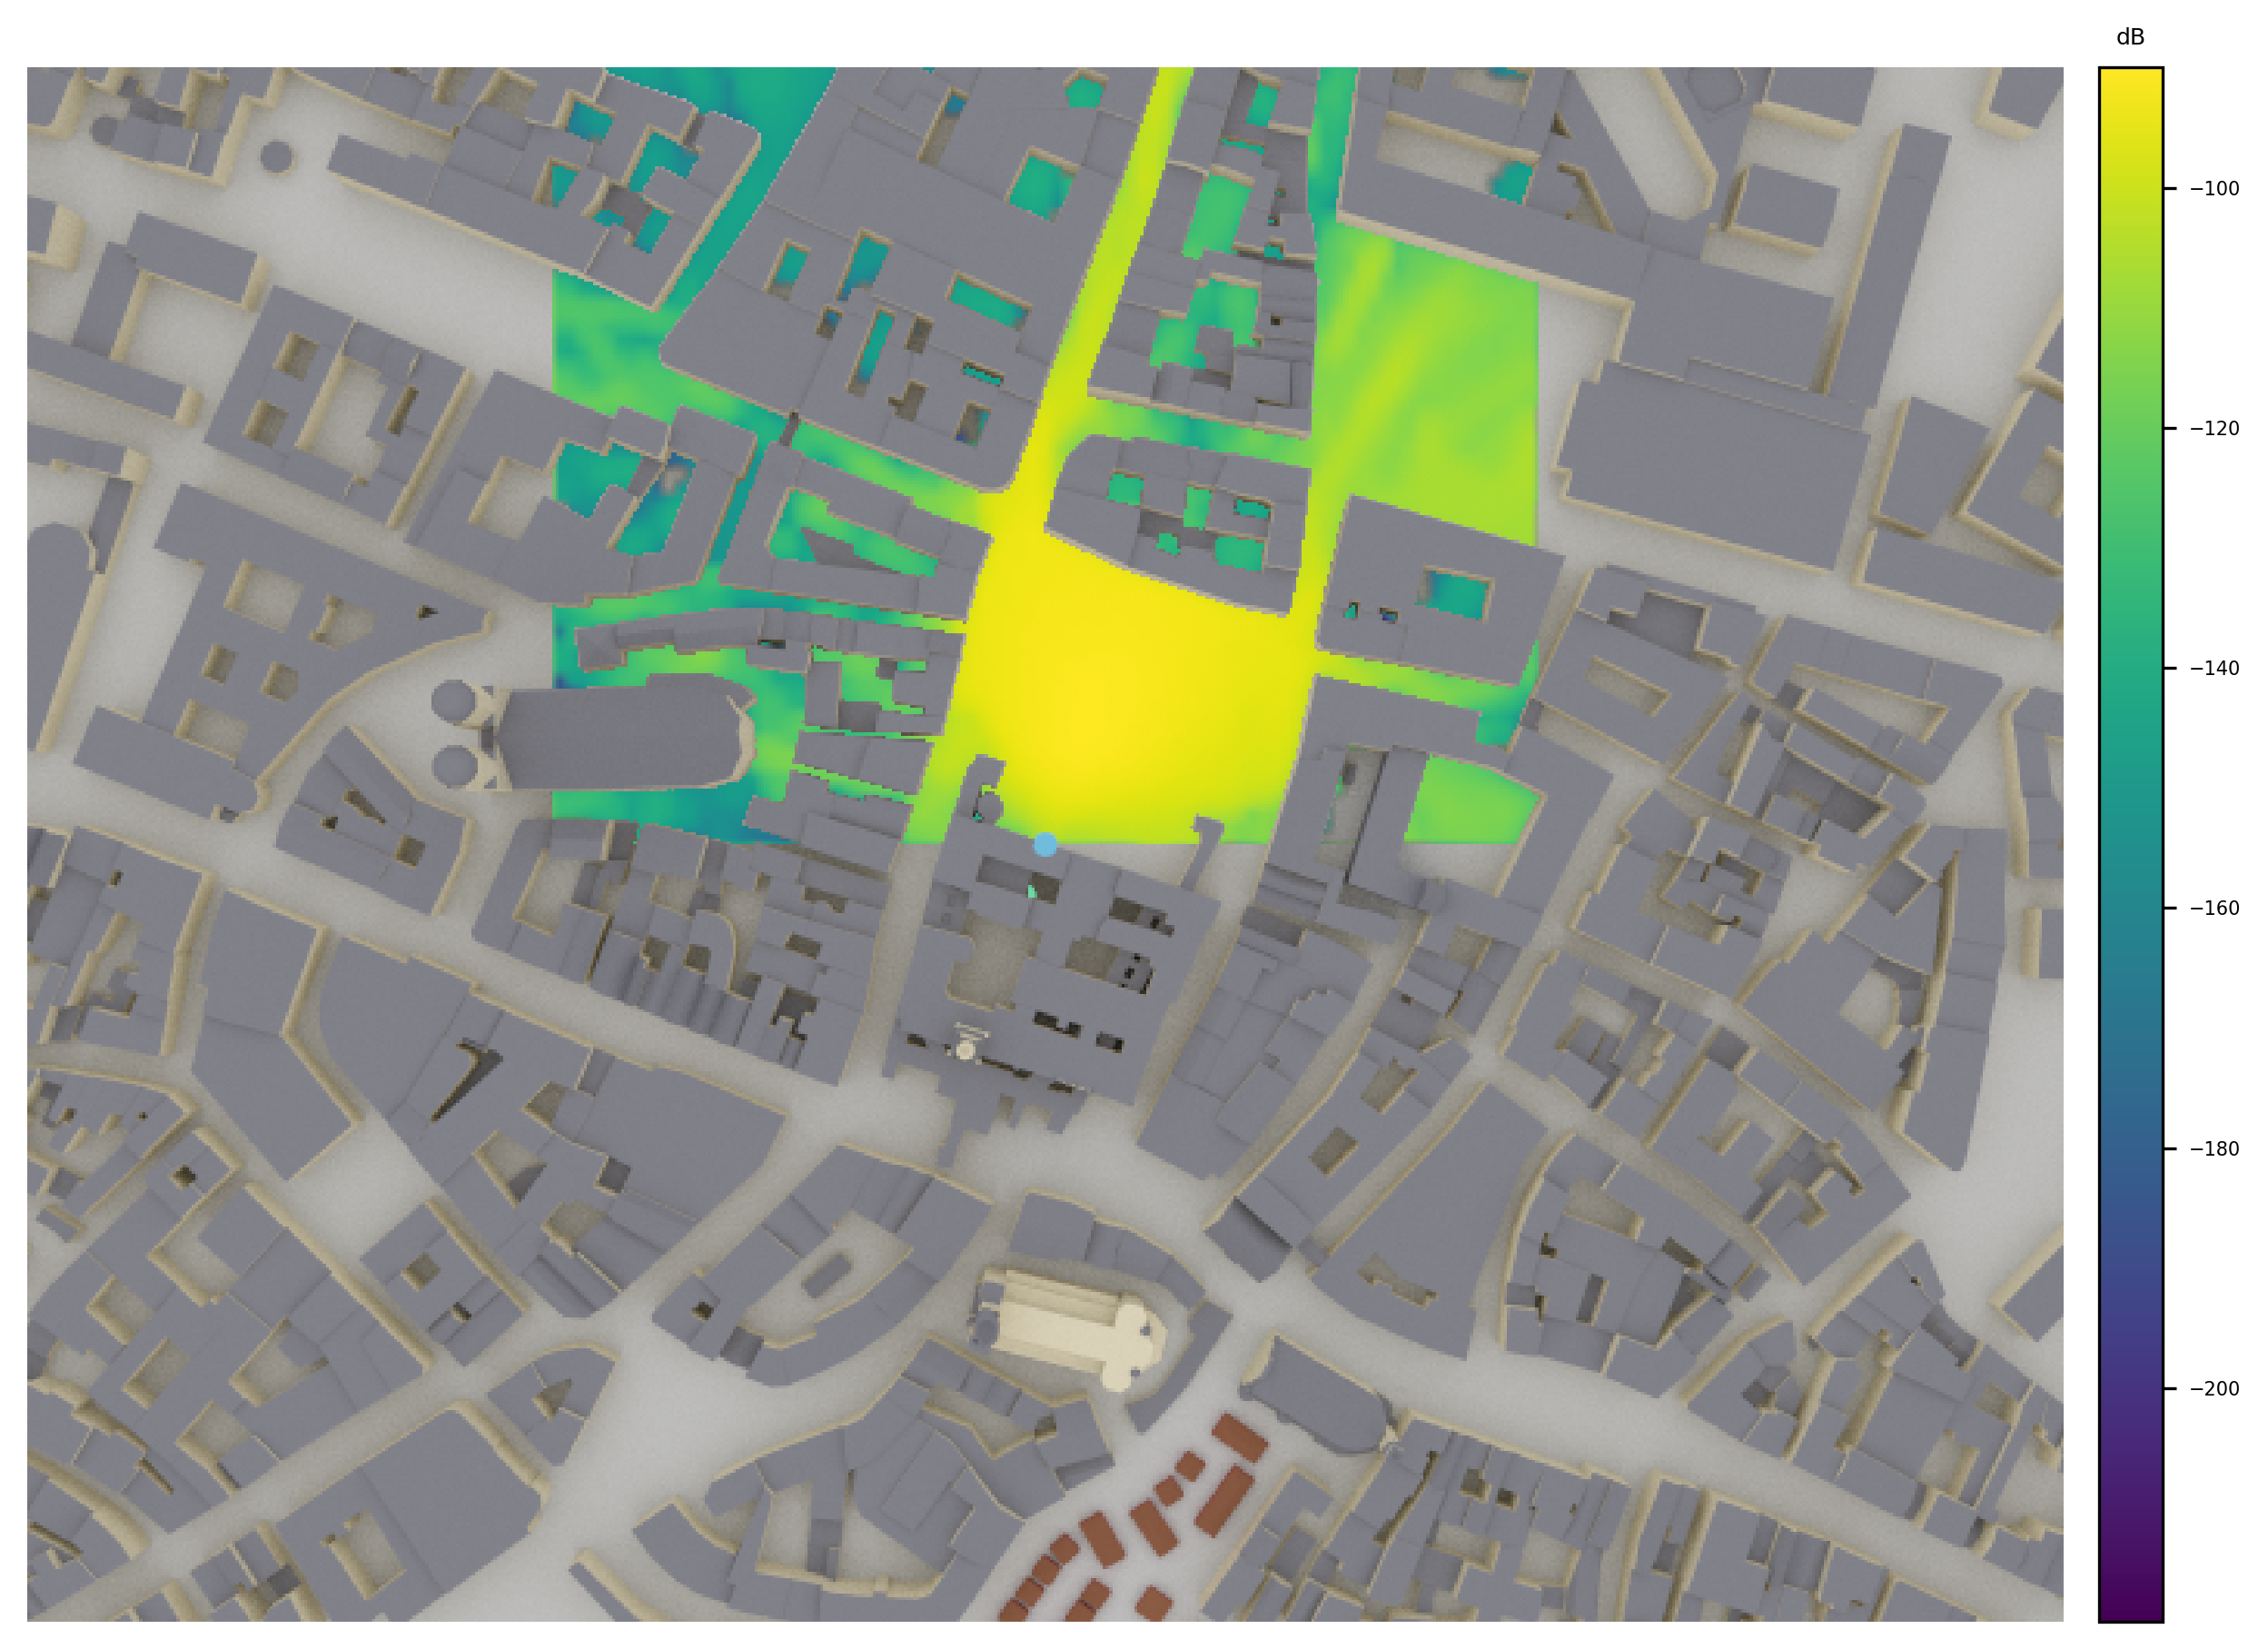

In [ ]:
# Create new camera
# Create new camera
tx_pos = scene.transmitters["tx"].position.numpy()
bird_pos = tx_pos.copy()
bird_pos[-1] = 1000 # Set height of coverage map to 1000m above tx
bird_pos[-2]-= 0.01 # Slightly move the camera for correct orientation

bird_cam = Camera("birds_view", position=bird_pos, look_at=tx_pos)

scene.render(camera=bird_cam, num_samples=512, coverage_map=cm);

In [ ]:
scene.tx_array = PlanarArray(num_rows=Ny,
                            num_cols=Nx,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern="tr38901",
                            polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=Nr,
                            num_cols=1,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern="tr38901",
                            polarization="V")

In [ ]:
def path2beamspace(paths, theta_steps=theta_steps, phi_steps=phi_steps):
    """
    Like postprocessing_function from before that decides what the desired outputs are from the paths
    """
    eps = 1e-10
    a, tau = paths.cir() # [?, n_rx, Nrx*Nry, n_tx, Nt, paths]import cProfile
    # need to operate for each path and each n_rx
    a = a[0, :, :, 0, 0, :, 0] # [n_rx, Nt, paths]
    a = a / a[:, 0:1, 0:1] # normalize to the first antenna
    n_rx, Nr, n_paths = a.shape

    responses = np.zeros((n_rx, theta_steps, phi_steps, n_paths), dtype=np.complex64)
    responses[:] = np.einsum('ijn,mnp->mijp', stx.conj(), a)
    responses = 10*np.log(np.sum(abs(responses)+eps, axis=-1)) # sum the absolute of the path responses

    # This is the output where n_rx is the batch dimension and the output is a grid of theta_steps by phi_steps
    return responses


def remove_scene_UEs(scene):
    x_names = list(scene.receivers.keys())
    [scene.remove(x_names[i]) for i in range(len(x_names))] # remove all RX
    # list comprehension to add users up to batch_size
    return scene


def add_scene_UEs(scene, N=1):
    [scene.add(Receiver(name=f"rx00{i}", position=[0., 0., 0.])) for i in range(N)]
    return scene


frequencies = subcarrier_frequencies(Ktotal, subcarrier_spacing)


def scene2channels(scene, timeslots_ms=1, K=20):
    # gets the timevarying, frequency domain channel response for the users
    velocities = np.random.randn(2)*2

    paths = scene.compute_paths(max_depth=5, num_samples=5e5, diffraction=en_diff, scattering=en_scat, scat_keep_prob=scat_prob)
    paths.apply_doppler(sampling_frequency=1e3, # 1ms samples
                    num_time_steps=timeslots_ms, # Number of OFDM symbols
                    rx_velocities=[velocities[0],velocities[1],0]) # Or rx speeds

    a, tau = paths.cir()
    h_freq = cir_to_ofdm_channel(frequencies[:K], a, tau, normalize=False)
    return h_freq[0, :, :, 0, :, :, :] # strip to [U, Nr, Nt, T, K]


def rsrp_rx_comb(H, beams):
    #  H [Nr, Nt], beams is [Lmax, Nt, 1]
    # returns SSBRI, RSRP, assuming fully digital combining
    Lmax, Nt, _ = beams.shape
    rsrp_per_sc_nr = np.zeros((Lmax,),dtype=ctype)
    rsrps = np.zeros((Lmax,), dtype=np.float32)
    for beam in numba.prange(Lmax):
        rsrps[beam] = abs(np.linalg.norm(H @ beams[beam, :, 0:1], axis=0)**2 / Nt)

    return np.argmax(rsrps), np.max(rsrps)


def multi_UE_RSRP(Hset, Fset, SNR_mode=False, ue_bf='digital'):
    # determines the RSRP or SNR (if boost=True) for a set of users assuming H is [U, Nr, Nt]
    # with Fset [Lmax, Nt, 1] with Lmax is the corresponding time instances and F is frequency flat
    U, Nr, Nt = Hset.shape
    noise_power_dBm = -174 + logx(Ktotal * 12 * subcarrier_spacing) + 7 # 7 dB noise figureget_dataset(scene, cm, batch_size=100, dataset_size=100)
    # print(f"Np = {noise_power_dBm:.2f}dBm")
    noise_power = 10**(noise_power_dBm/10)
    rsrp_results = np.zeros((U,), dtype=np.float32)
    SSBRI = np.zeros((U,), dtype=np.int16)
    for u in range(U):
        rsrp_results[u], SSBRI[u] = rsrp_rx_comb(Hset[u], Fset)
    if not SNR_mode:
        rsrp_results *= 20/Ktotal # No boosting at all
    else: # returns ~SNR
        rsrp_results *= N_RB * 12 / noise_power / Ktotal
    return rsrp_results.real, SSBRI


def active_beamspace(beams, Nx1=Nx1, Ny1=Ny1):
    # beams should be shape [L*Nr, Nx, Ny]
    Lmax, Nx, Ny = beams.shape
    power_meas = np.zeros((Lmax, 2, Nx1, Ny1), dtype=np.float32)

    for k, beam in enumerate(beams):
        pm = (U_NyNy @ beam.conj().T @ U_NxNx).T
        power_meas[k, 0, :, :] = pm.real
        power_meas[k, 1, :, :] = pm.imag

    return power_meas


def observation_from_beams(RSRPs_db, indices, beams, Nx=Nx, Ny=Ny, Nx1=Nx1, Ny1=Ny1):
    # rsrps should be of shape [UEs]
    # indicies of shape [UEs] [U1s_best_beam_index, UE2s_best_beam_index...]
    # beams is of shape [L, Nt, Nr?]
    # Nr referenced here could be 1 or more in this case, variable
    # Should return the observation, O, shape [L*Nr?, Nx, Ny]
    units = beams.shape
    beams = beams.reshape(-1, int(Nx), int(Ny)) # [L*Nr, Nx, Ny]
    active_regions = active_beamspace(beams, Nx1=Nx1, Ny1=Ny1)

    # scale by the rsrp in dB now
    max_rsrp = np.max(RSRPs_db)
    min_rsrp = np.min(RSRPs_db)

    try:
        rsrp_scaling = ( RSRPs_db - min_rsrp ) / (max_rsrp - min_rsrp+1e-10)
    except:
        print(f"divide by 0 with max={max_rsrp} and min={min_rsrp}")
    overall_scalings = 1e-7*np.ones((units[0]*units[2], 1, 1))
    for i, ind in enumerate(indices):
        overall_scalings[ind, 0, 0] += rsrp_scaling[i]

    active_region_scalings = np.linalg.norm(np.abs(active_regions[:, 0] + 1j*active_regions[:, 1]), axis=(1, 2), keepdims=True) # concatenate complex dimension
    active_regions[:, 0] = active_regions[:, 0] / active_region_scalings
    active_regions[:, 1] = active_regions[:, 1] / active_region_scalings
    active_regions = np.concatenate([active_regions[:, 0], active_regions[:, 1]]) #[2*Lmax, Nx, Ny]
    return active_regions, overall_scalings


def get_beamspace(channels, codebooks, Nx1=Nx1, Ny1=Ny1):
    # use stx [theta, phi, Nt] to generate the beamspace
    # channels is just for SSBRI and RSRP
    # codebooks is shape [Lmax, Nt], channels is [U, Nr, Nt]
    # beamspace = abs(np.einsum('Lnz,ijn->ij', codebooks, stx.conj())) # sum over Lmax
    RSRP, SSBRI = multi_UE_RSRP(channels, codebooks)
    Lmax = len(codebooks)

    full_observation = np.zeros((2*Lmax, Nx1+2, Ny1+2), dtype=np.float32)
    obs, scaling = observation_from_beams(logx(RSRP+1e-10), SSBRI, codebooks, Nx=Nx, Ny=Ny, Nx1=Nx1, Ny1=Ny1)
    counts = np.zeros((Lmax, 1, 1), dtype=np.int16)
    for i in range(Lmax):
        counts[i] = np.sum(SSBRI==i)

    full_observation[:, :Nx1, :Ny1] = obs
    full_observation[:, Nx1, Ny1] = np.tile(scaling[:, 0, 0], 2)
    full_observation[:, Nx1+1, Ny1+1] = np.tile(counts[:, 0, 0], 2)
    return full_observation


def get_svd_pow(channels):
    # channels is of size [U, Nr, Nt]
    Su = np.linalg.svd(channels, compute_uv=False)
    return Su[:, 0]


def prepare_channels(channels):
    # here we are just going to convert to narrowband channel since we cannot change
    # the beamformer within each SSB/CSI-RS.
    U, Nr, Nt, T, K = channels.shape
    reduced_chan = np.zeros((U, Nr, Nt), dtype=ctype)
    for u in range(len(channels)):
        reduced_chan[u] = subgroup_channels(channels[u].transpose(2, 3, 0, 1), subtimes=1, subbands=1)
    return reduced_chan


def spare_generate_channels(scene, cm, dataset_size=1000, batch_size=128, T=100, K=270):
    channel_set = np.zeros((dataset_size, Nr, Nt, T, K), dtype=np.complex64)
    ue_positions = np.zeros((dataset_size, 3), dtype=np.float32)
    x_pos_offsets = np.array([[0, 0, 0.5]], dtype=np.float32)
    # remove old UEs
    scene = remove_scene_UEs(scene)
    scene = add_scene_UEs(scene, batch_size)
    x_names = list(scene.receivers.keys())
    loops = int(np.ceil(dataset_size/batch_size))
    batch_per_loop = batch_size*np.ones((loops))
    batch_per_loop[-1] = dataset_size - np.sum(batch_per_loop[:-1]) # last may not be a full batch
    ds_counter = 0
    for loop in range(loops):
        active_b = int(batch_per_loop[loop])
        print(f"Channels for UEs {ds_counter}-{ds_counter+active_b} out of {dataset_size}")
        # get user positions
        sampled_pos = cm.sample_positions(active_b, min_gain_db=-160, min_dist=20)

        offset = (tf.random.uniform(shape=(active_b, 3), dtype=tf.float32)-0.5) * x_pos_offsets
        sampled_pos = sampled_pos + offset
        ue_positions[ds_counter:ds_counter+active_b, :] = sampled_pos.numpy()
        for i in range(active_b):
            scene.receivers[x_names[i]].position=sampled_pos[i]
        if batch_per_loop[loop] < len(x_names): # catch if less users are in the final batch, remove extra
            [scene.remove(x_names[-i]) for i in range(len(x_names)-active_b)]
        channel_set[ds_counter:ds_counter+active_b] = scene2channels(scene, T, K=K).numpy()
        ds_counter += active_b
    return channel_set, ue_positions


def generate_channels(scene, cm, dataset_size=1000, batch_size=128):
    # just generate a bunch of channels to be processed by get_dataset later
    channel_set = np.zeros((dataset_size, Nr, Nt), dtype=np.complex64)
    x_pos_offsets = np.array([[0, 0, 1]], dtype=np.float32)

    # remove old UEs
    scene = remove_scene_UEs(scene)
    scene = add_scene_UEs(scene, batch_size)
    x_names = list(scene.receivers.keys())

    loops = int(np.ceil(dataset_size/batch_size))
    batch_per_loop = batch_size*np.ones((loops))
    batch_per_loop[-1] = dataset_size - np.sum(batch_per_loop[:-1]) # last may not be a full batch

    ds_counter = 0
    for loop in range(loops):
        active_b = int(batch_per_loop[loop])
        print(f"Channels for UEs {ds_counter}-{ds_counter+active_b} out of {dataset_size}")

        # get user positions
        sampled_pos = cm.sample_positions(active_b, min_gain_db=-160, min_dist=20)
        offset = (tf.random.uniform(shape=(active_b, 3), dtype=tf.float32)-0.5) * x_pos_offsets
        sampled_pos = sampled_pos + offset

        for i in range(active_b):
            scene.receivers[x_names[i]].position=sampled_pos[i]
        if batch_per_loop[loop] < len(x_names): # catch if less users are in the final batch, remove extra
            [scene.remove(x_names[-i]) for i in range(len(x_names)-active_b)]

        active_channels = scene2channels(scene).numpy()
        prepped_channels = prepare_channels(active_channels)
        channel_set[ds_counter:ds_counter+active_b] = prepped_channels
        ds_counter += active_b
    return channel_set


def peel_channels(channel_input, default_codebook=DFT_codebook(n_beams=Lmax, Nx=Nx, Ny=Ny), dataset_size=1000, Lmax=Lmax, Umax=12, Umin=4,):
    beamspace_set = np.zeros((dataset_size, 2*Lmax, theta_steps+2, phi_steps+2), dtype=np.float32)
    channel_set = np.zeros((dataset_size, Umax, Nr, Nt), dtype=np.complex64) 
    SVD_power_set = np.zeros((dataset_size, Umax), dtype=np.float32)

    Utotal = len(channel_input)
    # select how many UEs will be in each round
    n_UE = np.random.choice(np.arange(Umin, Umax+1), size=(dataset_size), replace=True)
    for d in range(dataset_size):
        u = n_UE[d]
        u_active_inds = np.random.choice(np.arange(Utotal), size=(u), replace=False)
        prepped_channels = channel_input[u_active_inds]
        beamspace_obs = get_beamspace(prepped_channels, default_codebook)
        max_power = get_svd_pow(prepped_channels)

        beamspace_set[d] = beamspace_obs
        channel_set[d, :u] = prepped_channels
        SVD_power_set[d, :u] = max_power

        if not d%(dataset_size//20):
            print(f'completed {d+1}/{dataset_size}')

    beamspace_set = beamspace_set.reshape(dataset_size, -1)
    SVD_power_set = SVD_power_set.reshape(dataset_size, -1)
    bs_scaler = MinMaxScaler()
    beamspace_set = bs_scaler.fit_transform(beamspace_set)
    beamspace_set = beamspace_set.reshape(dataset_size, 2*Lmax, theta_steps+2, phi_steps+2)

    return beamspace_set, channel_set, SVD_power_set, bs_scaler


def get_dataset(scene, cm, default_codebook=DFT_codebook(n_beams=Lmax, Nx=Nx, Ny=Ny), dataset_size=1000, batch_size=128, Lmax=Lmax, Umax=12, Umin=4):
    # build up a dataset of beamspace inputs and beamspace outputs

    # Data structs for inputs/outputs, need the beamspace observation, average channel, and the SVD powers
    beamspace_set = np.zeros((dataset_size, 2*Lmax, theta_steps+2, phi_steps+2), dtype=np.float32)
    channel_set = np.zeros((dataset_size, Umax, Nr, Nt), dtype=np.complex64) # issue with the channels is we will have a lot of zeros whenever U<Umax
    SVD_power_set = np.zeros((dataset_size, Umax), dtype=np.float32)

    # select how many UEs will be in each round
    n_UE = np.random.choice(np.arange(Umin, Umax+1), size=(dataset_size,), replace=True)

    eff_dataset_size = np.sum(n_UE)
    all_channels = generate_channels(scene, cm, dataset_size=eff_dataset_size, batch_size=batch_size)

    ue_counter = 0
    for d_i in range(dataset_size):
        u = n_UE[d_i]
        prepped_channels = all_channels[ue_counter:ue_counter+u]
        beamspace_obs = get_beamspace(prepped_channels, default_codebook)
        max_power = get_svd_pow(prepped_channels)

        beamspace_set[d_i] = beamspace_obs
        channel_set[d_i, :u] = prepped_channels
        SVD_power_set[d_i, :u] = max_power
        ue_counter += u

    beamspace_set = beamspace_set.reshape(dataset_size, -1)
    SVD_power_set = SVD_power_set.reshape(dataset_size, -1)
    bs_scaler = MinMaxScaler()
    beamspace_set = bs_scaler.fit_transform(beamspace_set)
    beamspace_set = beamspace_set.reshape(dataset_size, 2*Lmax, theta_steps+2, phi_steps+2)
    svd_scaler = MinMaxScaler()
    SVD_power_set = svd_scaler.fit_transform(SVD_power_set)
    SVD_power_set = SVD_power_set.reshape(dataset_size, Umax)

    return beamspace_set, channel_set, SVD_power_set, scaler_set


default_codebook=DFT_codebook(n_beams=Nx*Ny, Nx=Nx, Ny=Ny)
default_codebook.shape

Generating codebook for 16 from size 16x16x1x1
Generating codebook for 16 from size 16x16x1x1
Generating codebook for 256 from size 16x16x1x1


(256, 256, 1)

In [ ]:
channel_set, positions = spare_generate_channels(scene, cm, dataset_size=50000, batch_size=1000, K=Ktotal, T=1)

Channels for UEs 0-1000 out of 50000
Channels for UEs 1000-2000 out of 50000
Channels for UEs 2000-3000 out of 50000
Channels for UEs 3000-4000 out of 50000
Channels for UEs 4000-5000 out of 50000
Channels for UEs 5000-6000 out of 50000
Channels for UEs 6000-7000 out of 50000
Channels for UEs 7000-8000 out of 50000
Channels for UEs 8000-9000 out of 50000
Channels for UEs 9000-10000 out of 50000
Channels for UEs 10000-11000 out of 50000
Channels for UEs 11000-12000 out of 50000
Channels for UEs 12000-13000 out of 50000
Channels for UEs 13000-14000 out of 50000
Channels for UEs 14000-15000 out of 50000
Channels for UEs 15000-16000 out of 50000
Channels for UEs 16000-17000 out of 50000
Channels for UEs 17000-18000 out of 50000
Channels for UEs 18000-19000 out of 50000
Channels for UEs 19000-20000 out of 50000
Channels for UEs 20000-21000 out of 50000
Channels for UEs 21000-22000 out of 50000
Channels for UEs 22000-23000 out of 50000
Channels for UEs 23000-24000 out of 50000
Channels for U

In [ ]:
filestring = path+f'H_20000U_4R_144T_1t_5K.pickle'
with open(filestring, "wb") as f:
    pickle.dump(channel_set, f)

In [ ]:
# Start by gathering all points
def get_heatmap_data(x_max=X_max, y_max=Y_max, steps=100):
    """
    Compute the heatmap of results to visually compare with the TX moving to each of the locations. Steps sets how many X and Y locations exist
    from 0 to x_max and 0 to y_max
    """
    channel_set = np.zeros((steps**2, Nr, Nt, T, K), dtype=np.complex64)
    ue_positions = np.zeros((steps**2, 3), dtype=np.float32)

    predictions = np.zeros((steps, steps, 1), dtype=ntype)
    true_y = np.zeros_like(predictions)
    # prepare the scene
    rx_names = list(scene.receivers.keys())
    [scene.remove(rx_names[i]) for i in range(len(rx_names))] # remove all RX

    # list comp to add users up to one row/column at a time
    [scene.add(Receiver(name=f"rx00{i}", position=[0., 0., 0.])) for i in range(steps)]
    rx_names = list(scene.receivers.keys())

    x_set = np.linspace(-30, 30, steps).astype(ntype)
    y_set = np.linspace(-30, 30, steps).astype(ntype)
    # now prepare the inputs as a batch
    rx_locs = np.zeros((steps**2, 3), dtype=ntype)
    rx_locs[:, 2] = 1 # place on XY plane with TX
    for i, x in enumerate(x_set):
        for j, y in enumerate(y_set):
            rx_locs[i*steps+j, :2] = [x, y]

    ds = 0
    for col in range(steps):
        for i in range(steps):
            # assign RX
            scene.receivers[rx_names[i]].position=rx_locs[col*steps+i]

        scene_data = scene2data(scene, rx_locs[col*steps:(col+1)*steps])
        prepped_channels = prepare_channels(scene_data.numpy())
        channel_set[ds:ds+steps] = prepped_channels
        ue_positions[ds:ds+steps] = rx_locs[col*steps:col*(steps+1)]
        ds = ds + steps
    return channel_set, ue_positions

def evaluate_heatmap():
    pass

In [ ]:
filestring = path+f'H_all.pickle'
with open(filestring, "rb") as f:
    channel_set_test = pickle.load(f)

In [ ]:
if scene_id == 'A':
    filestring = path+f'H_{len(channel_set)}U_{Nr}R_{Nt}T_1t_5K.pickle'
else:
    filestring = path+f'LOS_{len(channel_set)}U_{Nr}R_{Nt}T_1t_5K.pickle'

print("saving to ", filestring)
with open(filestring, "wb") as f:
    pickle.dump([channel_set, positions], f)

saving to  /media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_1/H_50000U_4R_64T_1t_5K.pickle


In [ ]:
n_samples = 10_000
channel_set = generate_channels(scene, cm, dataset_size=n_samples, batch_size=400)

Channels for UEs 0-400 out of 10000


KeyboardInterrupt: ignored

In [ ]:
scene_id = 'A'
n_samples = 10_000

filestring = path+f'Scene_{scene_id}_{n_samples}_channels_prepeel_{Nx}_{Ny}.pickle'

# with open(filestring, 'wb') as f:
#     pickle.dump(channel_set, f)


with open(filestring, "rb") as f:
    channel_set = pickle.load(f)

#### compare with old paper

In [ ]:
def peel_channels_old_paper(channel_input, default_codebook=DFT_codebook(n_beams=Lmax, Nx=Nx, Ny=Ny), dataset_size=1000, Lmax=Lmax, Umax=12, Umin=4,):
    beamspace_set = np.zeros((dataset_size, 2*Lmax, theta_steps+2, phi_steps+2), dtype=np.float32)
    channel_set = np.zeros((dataset_size, Umax, Nr, Nt), dtype=np.complex64) # issue with the channels is we will have a lot of zeros whenever U<Umax
    SVD_set = np.zeros((dataset_size, Lmax, Nt, 2), dtype=np.float32)

    Utotal = len(channel_input)
    # select how many UEs will be in each round
    n_UE = np.random.choice(np.arange(Umin, Umax+1), size=(dataset_size), replace=True)
    for d in range(dataset_size):
        u = n_UE[d]
        u_active_inds = np.random.choice(np.arange(Utotal), size=(u), replace=False)
        prepped_channels = channel_input[u_active_inds]
        beamspace_obs = get_beamspace(prepped_channels, default_codebook)
        max_power = svd_mu_mimo(prepped_channels, n_streams=Lmax)

        beamspace_set[d] = beamspace_obs
        channel_set[d, :u] = prepped_channels
        SVD_set[d, :, :, 0] = max_power.real
        SVD_set[d, :, :, 1] = max_power.imag

        if not d%(dataset_size//20):
            print(f'completed {d+1}/{dataset_size}')

    beamspace_set = beamspace_set.reshape(dataset_size, -1)
    bs_scaler = MinMaxScaler()
    beamspace_set = bs_scaler.fit_transform(beamspace_set)
    beamspace_set = beamspace_set.reshape(dataset_size, 2*Lmax, theta_steps+2, phi_steps+2)
    return beamspace_set, channel_set, SVD_set, bs_scaler


def svd_mu_mimo(Hset, time=0, n_streams=8):
    U, S, V = np.linalg.svd(Hset)
    inds = largest_indices(S, n_streams)
    beam = V.transpose(0, 2, 1)
    beam = beam[inds]
    beam = beam.reshape(n_streams, Nt, -1)
    beamset = beam / np.linalg.norm(beam, axis=(1, 2), keepdims=True) # * np.sqrt(Nt)
    # Need to convert inds to beam assignments
    beam_assignments = inds[0]
    return beamset[...,0]

Generating codebook for 16 from size 16x16x1x1


In [ ]:
n_samples = 50_000
beamspaces, channels, svd_bf, scaler = peel_channels_old_paper(channel_set, dataset_size=n_samples)

/tmp/ipykernel_47314/4120672277.py:56: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



completed 1/50000
completed 2501/50000
completed 5001/50000
completed 7501/50000
completed 10001/50000
completed 12501/50000
completed 15001/50000
completed 17501/50000
completed 20001/50000
completed 22501/50000
completed 25001/50000
completed 27501/50000
completed 30001/50000
completed 32501/50000
completed 35001/50000
completed 37501/50000
completed 40001/50000
completed 42501/50000
completed 45001/50000
completed 47501/50000


In [ ]:
filestring = path+f'old_data.pickle'

print(f"Saving to {filestring}")
with open(filestring, "wb") as f:
    pickle.dump([beamspaces, channels, svd_bf, scaler], f)

Saving to /media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_1/old_data.pickle


In [ ]:
AUTO = tf.data.AUTOTUNE

train_index = 40_000
batch_size = 128

def make_tfds(beamspaces, channels, svd_pows, total_samples=1_000_000, batch_size=128):
    # converts into a tfds for fast loading. If total_samples < len() then the datasets
    # are decreased in size up to total_samples
    in_beamspaces = tf.data.Dataset.from_tensor_slices(beamspaces[:total_samples])
    in_channels = tf.data.Dataset.from_tensor_slices(channels[:total_samples])
    out_svd_pows = tf.data.Dataset.from_tensor_slices(svd_pows[:total_samples])
    ds = tf.data.Dataset.zip((in_beamspaces, in_channels, out_svd_pows)).prefetch(AUTO).batch(batch_size, drop_remainder=True, num_parallel_calls=AUTO)
    return ds

train_ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(beamspaces[:train_index]), tf.data.Dataset.from_tensor_slices(svd_bf[:train_index]))).prefetch(AUTO).batch(batch_size, drop_remainder=True, num_parallel_calls=AUTO)
test_ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(beamspaces[train_index:]), tf.data.Dataset.from_tensor_slices(svd_bf[train_index:]))).prefetch(AUTO).batch(batch_size, drop_remainder=True, num_parallel_calls=AUTO)

In [ ]:
y_test = np.zeros((1, Lmax, 256, 2))
x_test = np.zeros((1, 32, 18, 18))

part_dense = partial(keras.layers.Dense, activation='relu')
part_conv = partial(keras.layers.SeparableConv2D, kernel_size=(3, 3), activation='relu', padding='same', depth_multiplier=2)
dtype_con ='float32'

class cos_sim_loss(tf.keras.losses.Loss):
# try a flattened cosine similarity
    def __init__(self, weights=None, y_shape=y_test.shape):
        super(cos_sim_loss, self).__init__()
        self.y_shape = y_shape
        self.rshape = self.y_shape[1]*self.y_shape[2]
        self.eps = tf.constant(1e-15)

    @tf.function()
    def call(self, y_true, y_est):
        y_true_f = tf.reshape(y_true, [-1, self.rshape, self.y_shape[-1]])
        y_est_f = tf.reshape(y_est, [-1, self.rshape, self.y_shape[-1]]) # [batch, -1, Lmax]
        print(y_true_f.shape, y_est_f.shape)
        return tf.reduce_mean(tf.reduce_sum((1 - tf.einsum('bkl,bkl->bl', y_true_f, y_est_f) / (tf.norm(y_true_f, axis=(1))*tf.norm(y_est_f, axis=(1)) + self.eps)), axis=-1))


@tf.function()
def cos_sim_met(y_true, y_est, lmax2=16):
    weights = tf.reshape(tf.constant(np.tile([1, 1, 1/2, 1/2, 1/4, 1/4, 1/4, 1/4], lmax2//8), dtype=tf.float32), [1, lmax2])
    y_true_f = tf.reshape(y_true, [-1, 16*16, lmax2])
    y_est_f = tf.reshape(y_est, [-1, 16*16, lmax2]) # [batch, -1, Lmax]
    return tf.reduce_mean(tf.reduce_sum((1 - tf.einsum('bkl,bkl->bl', y_true_f, y_est_f) / (tf.norm(y_true_f, axis=(1))*tf.norm(y_est_f, axis=(1)) + 1e-15)) * weights, axis=-1))


@tf.function()
def tf_mse_met(y_true, y_est):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true-y_est), axis=-1)) / tf.reduce_mean(tf.reduce_sum(tf.square(y_true), axis=-1))


def make_CNN(input_dim=x_test.shape[1:], output_dim=y_test.shape[1:]):
    K.clear_session()

    inputs = keras.Input(input_dim)
    x = part_conv(filters=128)(inputs)
    x = keras.layers.MaxPool2D(padding='same')(x)
    x = part_conv(128)(x)
    x = keras.layers.MaxPool2D(padding='same')(x)
    x = keras.layers.Dropout(rate=0.4)(x)
    x = part_conv(filters=256)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(rate=0.1)(x)
    x = keras.layers.Dense(np.prod(output_dim), dtype=dtype_con)(x)  # kernel_regularizer='l1'
    y = keras.layers.Reshape(output_dim, dtype=dtype_con)(x)
    model = keras.Model(inputs, y)
    print(model.summary())
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss=cos_sim_loss(), metrics=[tf_mse_met]) #, jit_compile=True)
    return model

In [ ]:
model = make_CNN()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 18, 18)]      0         
                                                                 
 separable_conv2d (Separable  (None, 32, 18, 128)      5060      
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 9, 128)       0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 16, 9, 128)       35200     
 leConv2D)                                                       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 5, 128)        0         
 2D)                                                         

In [ ]:
train_ds

<ParallelBatchDataset element_spec=(TensorSpec(shape=(128, 32, 18, 18), dtype=tf.float32, name=None), TensorSpec(shape=(128, 16, 256, 2), dtype=tf.float32, name=None))>

In [ ]:
model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
(128, 4096, 2) (128, 4096, 2)


2024-03-08 10:50:40.083898: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 [==============================] - 4s 11ms/step - loss: 1.8150 - tf_mse_met: 7.6102 - val_loss: 1.7969 - val_tf_mse_met: 4.3477
Epoch 2/20
312/312 [==============================] - 3s 11ms/step - loss: 1.7738 - tf_mse_met: 51.7218 - val_loss: 1.7613 - val_tf_mse_met: 59.4213
Epoch 3/20
312/312 [==============================] - 3s 11ms/step - loss: 1.7620 - tf_mse_met: 105.4675 - val_loss: 1.7569 - val_tf_mse_met: 125.0914
Epoch 4/20
312/312 [==============================] - 3s 11ms/step - loss: 1.7584 - tf_mse_met: 221.5695 - val_loss: 1.7555 - val_tf_mse_met: 286.6636
Epoch 5/20
312/312 [==============================] - 3s 11ms/step - loss: 1.7568 - tf_mse_met: 536.0901 - val_loss: 1.7548 - val_tf_mse_met: 636.9818
Epoch 6/20
312/312 [==============================] - 3s 11ms/step - loss: 1.7558 - tf_mse_met: 1055.5909 - val_loss: 1.7539 - val_tf_mse_met: 1217.2239
Epoch 7/20
312/312 [==============================] - 3s 11ms/step - loss: 1.7549 - tf_mse_met: 1774.4918 - v

KeyboardInterrupt: 

In [ ]:
@tf.function()
def my_tf_const_mod(x, bits=b_phaseshifter):
    # previous was not constant modulus
    phases = tf.math.angle(x)
    phases = (phases - pi) / (2*pi)
    amplitudes = tf.abs(x)
    multiplier = tf.constant(2**bits, dtype=tf.float32)
    quant_phases = tf.cast(tf.round(phases * multiplier) / multiplier, dtype=ctype)
    quant_phases = quant_phases * 2 * pi - pi
    x_quant = tf.exp(1j * quant_phases)
    x_quant = x_quant / tf.norm(x_quant, axis=-1, keepdims=True)
    return x_quant


def eval_loss(H, beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1, bits=3, is_beamspace=False, ssbri=None):
    beams = my_tf_const_mod(beamspace, bits)
    svd_pow = tf_get_svd_pow(H)
    if ssbri is not None:
        beams = prop_sel(beams.numpy(), ssbri)

    rsrp, ssbri = tf_rsrp_rx_comb(H, beams)
    losses = beam_loss_unavg(rsrp, svd_pow)
    return rsrp, losses, ssbri, svd_pow


@tf.function()
def beam_loss_unavg(RSRP, svd_pow):
    return tf_10log10(svd_pow) - tf_10log10(RSRP)


def eval_campaign(Hset, models, model_types=None, evals=1000, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1, Umax=12, Umin=4, bits=4, csi_max=32):
    # iterate through a set of channels, make beamspaces, get svd_pow, compare performance
    # models must be a list of models. Hset is [dataset_size, Nr, Nt]
    n_models = len(models)
    if model_types is None:
        model_types = ['ML' for i in range(n_models)]
    ssb_powers = np.zeros((evals, n_models, Umax), dtype=np.float32)
    svd_pows = np.zeros((evals, Umax), dtype=np.float32)
    delta_svd_ssb = np.zeros_like(ssb_powers)
    beamspace_set, channel_set, svd_set, bs_scaler = peel_channels_old_paper(Hset, dataset_size=evals, Lmax=Lmax, Umax=Umax, Umin=Umin)

    for e in range(evals):
        inputs = beamspace_set[e:e+1]
        for i, mod in enumerate(models):
            if model_types[i] == 'ML':
                ssb_beamspace = mod.predict(inputs, verbose=0)
                ssb_beams = ssb_beamspace[:, :, :, 0] + 1j*ssb_beamspace[:, :, :, 1]
                # do beamspace for a model
                ssb_powers[e, i, :], delta_svd_ssb[e, i, :], ssbri, svd_pows[e] = eval_loss(channel_set[e:e+1], ssb_beams, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1, bits=bits)
            else:
                # do ignorant prediction
                ssb_codebook, csi_codebook = mod.predict()
                ssb_powers[e, i, :], delta_svd_ssb[e, i, :], ssbri, _ = eval_loss(channel_set[e:e+1], ssb_codebook, Lmax, Nx1, Ny1, is_beamspace=False, bits=bits)

    return ssb_powers, delta_svd_ssb, svd_pows


In [ ]:
ssb, delta_ssb2, svd_pows = eval_campaign(channel_set, [model, dft_algo], model_types=['ML', 'dft'], evals=4000, bits=2)

/tmp/ipykernel_47314/4120672277.py:56: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



completed 1/4000
completed 201/4000
completed 401/4000
completed 601/4000
completed 801/4000
completed 1001/4000
completed 1201/4000
completed 1401/4000
completed 1601/4000
completed 1801/4000
completed 2001/4000
completed 2201/4000
completed 2401/4000
completed 2601/4000
completed 2801/4000
completed 3001/4000
completed 3201/4000
completed 3401/4000
completed 3601/4000
completed 3801/4000


Text(0, 0.5, 'Estimated PDF')

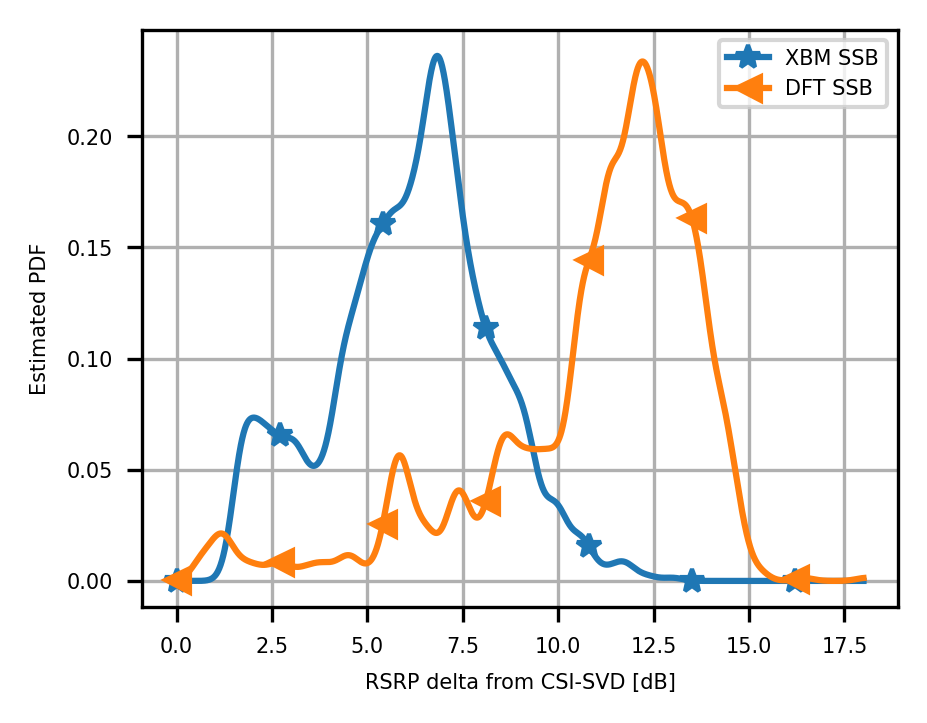

In [ ]:
double_delta = []
for i in range(2):
    ss = ssb[:, i]
    ss = ss[ss != 0]

    svd_powers = svd_pows[svd_pows != 0]

    double_delta.append(logx(svd_powers+1e-15) - logx(ss+1e-15))

labels = ["BSC", "DFT"]
markers = ['*', '<']

for i in range(2):
    _ = pdf_plot(double_delta[i], markers='-'+markers[i], markevery=300, label=labels[i]+f" SSB", xmax=18)
plt.grid()
plt.legend()
plt.xlabel("RSRP delta from CSI-SVD [dB]")
plt.ylabel("Estimated PDF")

In [ ]:
filestring = path+f'results/raw/old_paper.pickle'

print("saving to ", filestring)
with open(filestring, 'wb') as f:
    pickle.dump([ssb, delta_ssb2, svd_pows], f)

saving to  /media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_1/results/raw/old_paper.pickle


#### back to normal

In [ ]:
n_samples = 50_000
beamspaces, channels, svd_pows, scaler = peel_channels(channel_set, dataset_size=n_samples)

completed 1/50000
completed 2501/50000
completed 5001/50000
completed 7501/50000
completed 10001/50000
completed 12501/50000
completed 15001/50000
completed 17501/50000
completed 20001/50000
completed 22501/50000
completed 25001/50000
completed 27501/50000
completed 30001/50000
completed 32501/50000
completed 35001/50000
completed 37501/50000
completed 40001/50000
completed 42501/50000
completed 45001/50000
completed 47501/50000


In [ ]:
# now save the dataset
# scene_id = 'A'
# filestring = path+f'scene_{scene_id}_{n_samples}_inputs_outputs.pickle'
# filestring = path+f'scene_{scene_id}_{n_samples}_inputs_outputs_{Nx1}_{Ny1}_{Lmax}.pickle'
filestring = path+f'scene_{scene_id}_{n_samples}_inputs_outputs_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'

print(f"Saving to {filestring}")
with open(filestring, "wb") as f:
    pickle.dump([beamspaces, channels, svd_pows, scaler], f)

Saving to /media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_1/scene_A_50000_inputs_outputs_8_8_16_16_16.pickle


# Load channel and functions

In [ ]:
# load channels
scene_id = 'A'

Hset = np.load(path + 'Hset_{}_scene_{}.npy'.format(indexer, scene_id))
print(Hset.shape, Hset.dtype)

FileNotFoundError: [Errno 2] No such file or directory: '/media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_1/Hset_1_scene_A.npy'

In [ ]:
n_samples = 50_000
scene_id = 'A'
filestring = path+f'scene_{scene_id}_{n_samples}_inputs_outputs_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'

with open(filestring, "rb") as f:
    beamspaces, channels, svd_pows, scaler = pickle.load(f)

In [ ]:
AUTO = tf.data.AUTOTUNE

train_index = 40_000

def make_tfds(beamspaces, channels, svd_pows, total_samples=1_000_000, batch_size=128):
    # converts into a tfds for fast loading. If total_samples < len() then the datasets
    # are decreased in size up to total_samples
    in_beamspaces = tf.data.Dataset.from_tensor_slices(beamspaces[:total_samples])
    in_channels = tf.data.Dataset.from_tensor_slices(channels[:total_samples])
    out_svd_pows = tf.data.Dataset.from_tensor_slices(svd_pows[:total_samples])
    ds = tf.data.Dataset.zip((in_beamspaces, in_channels, out_svd_pows)).prefetch(AUTO).batch(batch_size, drop_remainder=True, num_parallel_calls=AUTO)
    return ds

train_ds = make_tfds(beamspaces[:train_index], channels[:train_index], svd_pows[:train_index],)# total_samples=35_000)
test_ds = make_tfds(beamspaces[train_index:], channels[train_index:], svd_pows[train_index:],) #total_samples=5_000)

## Beamforming codebooks

In [ ]:
# get an oversampled DFT codebook
def gen_codebook(Nx, Ny, OH=1, OV=1, **kwargs):
    # generate codebooks of size [Nx*Ny*OH*OV, Nt] from DFT codebooks
    Nt = Nx * Ny
    zero_pad_eye_y = np.eye(Ny*OV)
    zero_pad_eye_x = np.eye(Nx*OH)
    DFT_y = np.fft.fft(zero_pad_eye_y)[:, :Ny] / np.sqrt(Ny)
    DFT_x = np.fft.fft(zero_pad_eye_x)[:Nx, :] / np.sqrt(Nx)
    all_codebook = np.zeros((Nx*OH*Ny*OV, Nx, Ny), dtype=ctype)
    for i in range(OH*Nx):
        for j in range(OV*Ny):
            all_codebook[i*OV*Ny + j, :, :] = DFT_x[:, i:i+1] @ DFT_y[j:j+1, :]
    all_codebook = all_codebook.reshape(Nx*OH*Ny*OV, Nt).astype(ctype)
    return all_codebook

def DFT_codebook(n_beams=8, Nx=4, Ny=8, OH=1, OV=1, **kwargs):
    # DFT where n_beams decides how many beams are given. For n_beams<Nt some antennas are not used at all
    # for wider beams
    test_bf = np.zeros((n_beams, Nx*Ny, 1), dtype=ctype)
    Nt = Nx * Ny
    print(f"Generating codebook for {n_beams} from size {Nx}x{Ny}x{OH}x{OV}")
    if n_beams >= Nx*Ny*OH*OV:
        test_bf[:, :, 0] = gen_codebook(Nx=Nx, Ny=Ny, OH=OH, OV=OV)
    else:
        test_bf = np.zeros((n_beams, Nx, Ny), dtype=ctype)
        if n_beams <= 8:
            Nx1 = 2
        elif n_beams <= 32:
            Nx1 = 4
        else:
            Nx1 = 8
        Ny1 = n_beams//Nx1
        DFT_x = np.fft.fft(np.eye(Nx1)) / np.sqrt(Nx1)
        DFT_y = np.fft.fft(np.eye(Ny1)) / np.sqrt(Ny1)
        for nx in range(Nx1):
            for ny in range(Ny1):
                test_bf[nx*Ny1+ny, Nx//2-Nx1//2:Nx//2+Nx1//2, Ny//2-Ny1//2:Ny//2+Ny1//2] = DFT_x[:, nx:nx+1] @ DFT_y[ny:ny+1, :]
        test_bf = test_bf.reshape(n_beams, Nt, 1)

    test_bf = test_bf / np.linalg.norm(test_bf, axis=(1), keepdims=True) * np.sqrt(Nt)
    return test_bf

def SVD_codebook(Hset, n_beams=64, N_RB=20, timing_elements=None, **kwargs):
    # calculate the SVD beamformer for the first n_beams users
    if timing_elements is None:
        timing_elements = np.zeros((n_beams,), dtype=np.int16)

    Ulim = len(Hset)
    H_a = Hset[:n_beams, timing_elements, :N_RB, :, :]
    test_bf = np.zeros((n_beams, Nt, 1), dtype=ctype)
    if n_beams < Ulim:
        for u in range(n_beams):
            U, S, V = np.linalg.svd(H_a[u, u])
            test_bf[u, :, 0] = np.mean(V[:, 0, :].conj(), axis=0).T # mean after SVD is important!
    else:
        tot_beams = 0
        repeats = 0
        for rep in range(Nr):
            for u in range(Ulim):
                if tot_beams < n_beams:
                    U, S, V = np.linalg.svd(np.mean(H_a[u, u], axis=0))
                    test_bf[rep*Ulim+u, :, 0] = V[rep, :].conj().T
                    tot_beams += 1

    test_bf = test_bf / np.linalg.norm(test_bf, axis=(1), keepdims=True) * np.sqrt(Nt)
    return test_bf


def MRT_codebook(Hset, n_beams=64, N_RB=20, timing_elements=None, **kwargs):
    # calculate the MRT beamformer for the first n_beams users with antenna selection
    if timing_elements is None:
        timing_elements = np.zeros((n_beams,), dtype=np.int16)

    Ulim = len(Hset)
    H_a = np.mean(Hset[:n_beams, timing_elements, :N_RB, :, :], axis=2)
    ant_sels = np.argmax(np.linalg.norm(H_a, axis=(3)), axis=2)
    test_bf = np.zeros((n_beams, Nt, 1), dtype=ctype)

    if n_beams <= Ulim:
        for u in range(n_beams):
            H_eff = H_a[u, u, ant_sels[u, u], :]
            test_bf[u, :, 0] = H_eff.conj()
    else:
        tot_beams = Ulim
        repeats = 0
        for u in range(Ulim):
            H_eff = H_a[u, u, ant_sels[u, u], :]
            test_bf[u, :, 0] = H_eff.conj()

        other_UE = np.random.choice(np.arange(Ulim), size=(n_beams-tot_beams))
        other_ants = np.random.choice(np.arange(Nr), size=(n_beams-tot_beams))
        for beam in range(n_beams-tot_beams):
            H_eff = H_a[other_UE[beam], other_UE[beam], other_ants[beam]]
            test_bf[beam+Ulim, :, 0] = H_eff.conj()

    test_bf = test_bf / np.linalg.norm(test_bf, axis=(1), keepdims=True) * np.sqrt(Nt)
    return test_bf


def Optimal_codebook(Hset, n_beams=8, N_RB=20, timing_elements=None, return_users=False, **kwargs):
    # look at all of the timing options and greedily select the strongest MRT beams
    if timing_elements is None:
        timing_elements = np.zeros((n_beams,), dtype=np.int16)
    if len(timing_elements) > n_beams:
        timing_elements = timing_elements[:n_beams]

    Ulim = len(Hset)
    test_bf = np.zeros((n_beams, Nt, 1), dtype=ctype)
    user_time_selection = -1*np.ones(n_beams, dtype=np.int16)
    if n_beams <= Ulim:
        for i, t in enumerate(timing_elements):
            H_a = Hset[:, t, :N_RB, :, :]
            Su = np.mean(np.linalg.svd(H_a, compute_uv=False), axis=1) # mean over frequency
            Su_copy = np.delete(Su, user_time_selection[:i], axis=0)
            best_ue_test = np.argmax(Su_copy[:, 0])
            best_ue_s = Su_copy[best_ue_test, 0]
            best_ue = np.argmin(abs(Su[:, 0] - best_ue_s), axis=0)

            user_time_selection[i] = best_ue
            U, S, V = np.linalg.svd(H_a[best_ue])
            test_bf[i, :, 0] = np.mean(V[:, 0, :].conj(), axis=0).T
    else:
        # computationally easier since there are more beams than users so any allocation is fine
        tot_beams = 0
        repeats = 0
        H_a = Hset[:n_beams, timing_elements, :N_RB, :, :]
        for rep in range(Nr):
            for u in range(Ulim):
                if tot_beams < n_beams:
                    U, S, V = np.linalg.svd(H_a[u, u])
                    test_bf[rep*Ulim+u, :, 0] = np.mean(V[:, rep, :].conj().T, axis=1)
                    tot_beams += 1

    test_bf = test_bf / np.linalg.norm(test_bf, axis=(1), keepdims=True) * np.sqrt(Nt)
    if return_users:
        return test_bf, user_time_selection
    else:
        return test_bf


# testing functions for codebooks
def test_rsrp_SNR(Hset, MC=100, ue_bf='ant_sel', SNR=False, n_UE_min=3, n_UE_max=12, n_beams=8, N_RB=20):
    # Get performance statistics of the various codebooks
    metrics = ['mean', 'min', 'max', 'median']
    time_lim = Hset.shape[1]
    metric_report = np.zeros((MC, 4, len(metrics)), dtype=np.float32)
    dft_c = DFT_codebook(n_beams=n_beams)
    n_u_active = np.random.choice(np.arange(n_UE_min, n_UE_max), size=MC)
    tstart = np.random.choice(np.arange(time_lim), size=MC)
    timings = np.zeros((n_beams,), dtype=np.int16)
    for mc in range(MC):
        u_active = np.random.choice(np.arange(0, len(Hset)), size=n_u_active[mc], replace=False).astype(np.int16)
        H_active = np.repeat(Hset[u_active, tstart[mc]:tstart[mc]+1, :, :, :], n_u_active[mc], axis=1)

        svd_c = SVD_codebook(H_active, n_beams=n_beams, timing_elements=timings)
        mrt_c = MRT_codebook(H_active, n_beams=n_beams, timing_elements=timings)
        opt_c = Optimal_codebook(H_active, n_beams=n_beams, timing_elements=timings)
        codebooks = [dft_c, svd_c, mrt_c, opt_c]
        for ind_c in range(len(codebooks)):
            rsrps, _ = UE_SSB_RSRP(H_active, codebooks[ind_c], boost=SNR, ue_bf=ue_bf, timing_res=2)
            rsrps = logx(rsrps)
            metric_report[mc, ind_c, 0] = np.mean(rsrps)
            metric_report[mc, ind_c, 1] = np.mean(-1*np_kmax(-1*rsrps, 3)) # only look at 3 best and worst users
            metric_report[mc, ind_c, 2] = np.mean(np_kmax(rsrps, 3))
            metric_report[mc, ind_c, 3] = np.median(rsrps)
    return metric_report

# Neural network

In [ ]:
@tf.function()
def tf_rsrp_rx_comb(H, beams):
    # H is [?, U, Nr, Nt] and beams is [?, Lmax, Nt]
    rsrps = tf.abs(tf.norm(tf.einsum('burt,blt->burl', H, beams), axis=-2)) # * 20/Ktotal # [?, U, Lmax]
    return tf.reduce_max(rsrps, axis=2), tf.argmax(rsrps, axis=2) # returns shape [?, U], [?, U]


@tf.function()
def tf_deconvert_beamspace(beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    # convert from beamspace to beamformers
    complex_beamspace = tf.cast(beamspace[:, :, :, :Lmax], tf.complex64) + 1j * tf.cast(beamspace[:, :, :, Lmax:], tf.complex64) # [?, Nx, Ny, Lmax]
    beams = tf.einsum('nx, bnyl->bxyl', tf_U_NxNx_inv, tf.einsum('yn,bxnl->bxyl', tf_U_NyNy_inv, complex_beamspace))
    beams = tf.reshape(tf.transpose(beams, [0, 3, 1, 2]), [-1, Lmax, Nx*Ny])
    beams = beams / tf.norm(beams+1e-10, axis=-1, keepdims=True)
    return beams


@tf.function()
def beam_loss(RSRP, svd_pow):
    return tf.reduce_mean(tf_10log10(svd_pow) - tf_10log10(RSRP))

@tf.function()
def unsup_loss(rsrp):
    return -tf.reduce_mean(tf_10log10(rsrp))


@tf.function()
def tf_beamspace2loss(H, beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    # one function to get all the way to the loss calculation
    beams = tf_deconvert_beamspace(beamspace, Lmax, Nx1, Ny1)
    svd_pow = tf_get_svd_pow(H)
    rsrp, ssbri = tf_rsrp_rx_comb(H, beams)
    loss = beam_loss(rsrp, svd_pow)
    return loss

@tf.function()
def unsup_tf_beamspace2loss(Hest, beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    beams = tf_deconvert_beamspace(beamspace, Lmax, Nx1, Ny1)
    Hest = my_tf_const_mod(Hest, bits=2)
    rsrp, ssbri = tf_rsrp_rx_comb(Hest, beams)
    loss = unsup_loss(rsrp)
    return loss


@tf.function()
def tf_get_svd_pow(channels):
    # channels is of size [?, U, Nr, Nt]
    Su = tf.linalg.svd(channels, compute_uv=False)
    return Su[:, :, 0]

@tf.function()
def tf_hybrid(beamformers, Nb=b_phaseshifter):
    # beamformers is shape [?, Lmax, Nt], round to Nb bit phase shifts
    quant_beamformers = tf.grad_pass_through(my_tf_round)(beamformers)
    return quant_beamformers

# @tf.function()
def my_tf_round(x, bits=b_phaseshifter):
    multiplier = tf.constant(2**bits, dtype=tf.float32)
    return tf.cast(tf.round(tf.math.real(x) * multiplier) / multiplier, dtype=ctype) + 1j * tf.cast(tf.round(tf.math.imag(x) * multiplier) / multiplier, dtype=ctype)

@tf.function()
def my_tf_const_mod(x, bits=b_phaseshifter):
    # previous was not constant modulus
    phases = tf.math.angle(x)
    phases = (phases - pi) / (2*pi)
    amplitudes = tf.abs(x)
    multiplier = tf.constant(2**bits, dtype=tf.float32)
    quant_phases = tf.cast(tf.round(phases * multiplier) / multiplier, dtype=ctype)
    quant_phases = quant_phases * 2 * pi - pi
    x_quant = tf.exp(1j * quant_phases)
    x_quant = x_quant / tf.norm(x_quant, axis=-1, keepdims=True)
    return x_quant



In [ ]:
#### UPDATES FOR MIMO LOSS
# here we want to train on the MIMO loss as a result of the codebook.

def mimo_loss(H, beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    # Compare the potential rate using the codebook for analog beamforming
    U = len(H)
    beams = tf_deconvert_beamspace(beamspace, Lmax, Nx1, Ny1)
    rsrp, ssbri = tf_rsrp_rx_comb(H, beams)
    for u in tf.range(U):
        HFu = tf.matmul(H[u], beams[ssbri[u]])

In [ ]:
part_conv = partial(keras.layers.SeparableConv2D, kernel_size=(3, 3), activation='relu', padding='same', depth_multiplier=2)
dtype_con ='float32'

def get_ssb_network(Lmax=Lmax, output_dim=[Nx1, Ny1, Lmax*2], input_dim=[2*Lmax, Nx1+2, Ny1+2]):
    inputs = keras.Input(input_dim)

    x = part_conv(filters=128)(inputs)
    x = keras.layers.MaxPool2D(padding='same')(x)
    x = part_conv(filters=96)(x)
    x = keras.layers.MaxPool2D(padding='same')(x)
    x = part_conv(filters=320)(x)
    x = keras.layers.MaxPool2D(padding='same')(x)
    x = part_conv(filters=128)(x)
    x = keras.layers.Dropout(rate=0.1)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(rate=0.4)(x)
    x = keras.layers.Dense(np.prod(output_dim), dtype=dtype_con)(x)  # kernel_regularizer='l1'
    y = keras.layers.Reshape(output_dim, dtype=dtype_con)(x)
    y = y / tf.linalg.norm(y+1e-10, axis=(1, 2), keepdims=True) * Nt
    model = keras.Model(inputs, y)
    print(model.summary())
    return model

def get_csi_network(Lmax=Lmax, csi_per_ssb=4):
    return get_ssb_network(Lmax, output_dim=[Nx1, Ny1, Lmax*csi_per_ssb*2])



class XBM(keras.Model):
    """ Class to overload the training and prediction methods for the XBM """
    def __init__(self, ssb_network=None, csi_network=None, scalers=None, csi_per_ssb=4, Nx=Nx, Ny=Ny):
        super().__init__()
        if ssb_network is None:
            self.ssb_network = get_ssb_network()
        else:
            self.ssb_network = ssb_network
        if csi_network is None:
            self.csi_network = get_csi_network()
        else:
            self.csi_network = csi_network
        self.scalers = scalers
        self.csi_per_ssb = csi_per_ssb
        self.Nx = Nx
        self.Ny = Ny

    def compile(self, ssb_optimizer, csi_optimizer, loss_func=None, **kwargs):
        super().compile(kwargs)
        self.ssb_optimizer = ssb_optimizer
        self.csi_optimizer = csi_optimizer
        self.loss_func = loss_func
        self.ssb_loss = keras.metrics.Mean(name="mean loss")
        self.csi_loss = keras.metrics.Mean(name="mean loss")

        self.ssb_network.compile(self.ssb_optimizer, loss=keras.losses.MSE)
        self.csi_network.compile(self.csi_optimizer, loss=keras.losses.MSE)

    def train_step(self, inputs):
        # unpack inputs
        (beamspace, channel_set, SVD_powers) = inputs

        # loss calculation and gradients
        with tf.GradientTape(persistent=True) as tape:
            pred_beamspace = self.ssb_network(beamspace)
            ssb_loss = tf_beamspace2loss(channel_set, pred_beamspace, Lmax=Lmax, Nx1=self.Nx, Ny1=self.Ny)
            ssb_variables = self.ssb_network.trainable_variables
            ssb_grads = tape.gradient(ssb_loss, ssb_variables)

            csi_beamspace = self.csi_network(beamspace)
            csi_loss = tf_beamspace2loss(channel_set, csi_beamspace, Lmax=Lmax*self.csi_per_ssb, Nx1=Nx, Ny1=Ny)
            csi_variables = self.csi_network.trainable_variables
            csi_grads = tape.gradient(csi_loss, csi_variables)

        self.csi_optimizer.apply_gradients(zip(csi_grads, csi_variables))
        self.ssb_optimizer.apply_gradients(zip(ssb_grads, ssb_variables))
        self.ssb_loss.update_state(ssb_loss)
        self.csi_loss.update_state(csi_loss)
        return {"ssb_loss" : self.ssb_loss.result(), 'csi_loss' : self.csi_loss.result()}

    def test_step(self, inputs):
        (beamspace, channel_set, SVD_powers) = inputs
        pred_beamspace = self.ssb_network(beamspace)
        ssb_loss = tf_beamspace2loss(channel_set, pred_beamspace, Lmax=Lmax, Nx1=self.Nx, Ny1=self.Ny)

        csi_beamspace = self.csi_network(beamspace)
        csi_loss = tf_beamspace2loss(channel_set, csi_beamspace, Lmax=Lmax*self.csi_per_ssb, Nx1=Nx, Ny1=Ny)

        self.ssb_loss.update_state(ssb_loss)
        self.csi_loss.update_state(csi_loss)
        return {"ssb_loss" : self.ssb_loss.result(), 'csi_loss' : self.csi_loss.result()}

    def predict(self, inputs):
        (beamspace, channel_set, SVD_powers) = inputs
        pred_beamspace = self.ssb_network(beamspace)
        csi_beamspace = self.csi_network(beamspace)
        return pred_beamspace, csi_beamspace


class XBM_online(keras.Model):
    """ Class to overload the training and prediction methods for the XBM """
    def __init__(self, ssb_network=None, csi_network=None, scalers=None, csi_per_ssb=4, Nx=Nx, Ny=Ny):
        super().__init__()
        if ssb_network is None:
            self.ssb_network = get_ssb_network()
        else:
            self.ssb_network = ssb_network
        if csi_network is None:
            self.csi_network = get_csi_network()
        else:
            self.csi_network = csi_network
        self.scalers = scalers
        self.csi_per_ssb = csi_per_ssb
        self.Nx = Nx
        self.Ny = Ny

    def compile(self, ssb_optimizer, csi_optimizer, loss_func=None, **kwargs):
        super().compile(kwargs)
        self.ssb_optimizer = ssb_optimizer
        self.csi_optimizer = csi_optimizer
        self.loss_func = loss_func
        self.ssb_loss = keras.metrics.Mean(name="mean loss")
        self.csi_loss = keras.metrics.Mean(name="mean loss")

        self.ssb_network.compile(self.ssb_optimizer, loss=keras.losses.MSE)
        self.csi_network.compile(self.csi_optimizer, loss=keras.losses.MSE)

    def train_step(self, inputs):
        # unpack inputs
        (beamspace, channel_set, SVD_powers) = inputs

        # loss calculation and gradients
        with tf.GradientTape(persistent=True) as tape:
            pred_beamspace = self.ssb_network(beamspace)
            ssb_loss = unsup_tf_beamspace2loss(channel_set, pred_beamspace, Lmax=Lmax, Nx1=self.Nx, Ny1=self.Ny)
            ssb_variables = self.ssb_network.trainable_variables
            ssb_grads = tape.gradient(ssb_loss, ssb_variables)

            csi_beamspace = self.csi_network(beamspace)
            csi_loss = unsup_tf_beamspace2loss(channel_set, csi_beamspace, Lmax=Lmax*self.csi_per_ssb, Nx1=Nx, Ny1=Ny)
            csi_variables = self.csi_network.trainable_variables
            csi_grads = tape.gradient(csi_loss, csi_variables)

        self.csi_optimizer.apply_gradients(zip(csi_grads, csi_variables))
        self.ssb_optimizer.apply_gradients(zip(ssb_grads, ssb_variables))
        self.ssb_loss.update_state(ssb_loss)
        self.csi_loss.update_state(csi_loss)
        return {"ssb_loss" : self.ssb_loss.result(), 'csi_loss' : self.csi_loss.result()}

    def test_step(self, inputs):
        (beamspace, channel_set, SVD_powers) = inputs
        pred_beamspace = self.ssb_network(beamspace)
        ssb_loss = tf_beamspace2loss(channel_set, pred_beamspace, Lmax=Lmax, Nx1=self.Nx, Ny1=self.Ny)

        csi_beamspace = self.csi_network(beamspace)
        csi_loss = tf_beamspace2loss(channel_set, csi_beamspace, Lmax=Lmax*self.csi_per_ssb, Nx1=Nx, Ny1=Ny)

        self.ssb_loss.update_state(ssb_loss)
        self.csi_loss.update_state(csi_loss)
        return {"ssb_loss" : self.ssb_loss.result(), 'csi_loss' : self.csi_loss.result()}

    def predict(self, inputs):
        (beamspace, channel_set, SVD_powers) = inputs
        pred_beamspace = self.ssb_network(beamspace)
        csi_beamspace = self.csi_network(beamspace)
        return pred_beamspace, csi_beamspace

In [ ]:
xbm = XBM()
opt1 = keras.optimizers.Adam(learning_rate=1e-4)
opt2 = keras.optimizers.Adam(learning_rate=1e-4)

xbm.compile(opt1, opt2, weighted_metrics=[])

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 32, 18, 18)  0           []                               
                                ]                                                                 
                                                                                                  
 separable_conv2d_80 (Separable  (None, 32, 18, 128)  5060       ['input_21[0][0]']               
 Conv2D)                                                                                          
                                                                                                  
 max_pooling2d_60 (MaxPooling2D  (None, 16, 9, 128)  0           ['separable_conv2d_80[0][0]']    
 )                                                                                         

In [ ]:
# xbm = XBM()
print(f"loading from {path + f'models/ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras'}")
# print(f"loading from {path + f'models/ssb_{8}_{8}_{Nx1}_{Ny1}_{Lmax}.keras'}")


ssb_net = keras.models.load_model(path + f'models/scene_{scene_id}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')
csi_net = keras.models.load_model(path + f'models/scene_{scene_id}_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')

# ssb_net = keras.models.load_model(path + f'models/scene_B_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')
# csi_net = keras.models.load_model(path + f'models/scene_B_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')

# xbm = XBM(ssb_net, csi_net)
xbm = XBM_online(ssb_net, csi_net)

opt1 = keras.optimizers.Adam(learning_rate=1e-4)
opt2 = keras.optimizers.Adam(learning_rate=1e-5)

xbm.compile(opt1, opt2)
xbm.evaluate(test_ds)

loading from /media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_1/models/ssb_16_16_16_16_16.keras
78/78 [==============================] - 1s 7ms/step - ssb_loss: 3.7222 - csi_loss: 2.3301


[2.340686321258545, 3.7367560863494873]

In [ ]:
# xbm = XBM()
print(f"loading from {path + f'models/scene_{scene_id}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras'}")

ssb_net = keras.models.load_model(path + f'models/scene_{scene_id}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')
csi_net = keras.models.load_model(path + f'models/scene_{scene_id}_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')

# xbm = XBM(ssb_net, csi_net)
xbm = XBM_online(ssb_net, csi_net)
opt1 = keras.optimizers.Adam(learning_rate=1e-4)
opt2 = keras.optimizers.Adam(learning_rate=1e-4)

xbm.compile(opt1, opt2)
xbm.evaluate(test_ds)

loading from /media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_1/models/scene_A_ssb_16_16_16_16_16.keras
78/78 [==============================] - 1s 7ms/step - ssb_loss: 5.2093 - csi_loss: 4.4929


[4.503162860870361, 5.227917194366455]

In [ ]:
# early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, min_delta=1e-5)
# lr_reduc = tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5, verbose=0, min_lr=1e-5, min_delta=4e-6)

opt1.learning_rate = 1e-4
opt2.learning_rate = 1e-4
xbm.compile(opt1, opt2)

hist = xbm.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
312/312 [==============================] - 9s 26ms/step - ssb_loss: -1.8745 - csi_loss: -2.1657 - val_ssb_loss: 0.7859 - val_csi_loss: 0.5136
Epoch 2/10
312/312 [==============================] - 8s 26ms/step - ssb_loss: -1.8756 - csi_loss: -2.1665 - val_ssb_loss: 0.7858 - val_csi_loss: 0.5135
Epoch 3/10
312/312 [==============================] - 8s 24ms/step - ssb_loss: -1.8757 - csi_loss: -2.1666 - val_ssb_loss: 0.7857 - val_csi_loss: 0.5134
Epoch 4/10
312/312 [==============================] - 8s 25ms/step - ssb_loss: -1.8758 - csi_loss: -2.1667 - val_ssb_loss: 0.7857 - val_csi_loss: 0.5134
Epoch 5/10
312/312 [==============================] - 8s 25ms/step - ssb_loss: -1.8759 - csi_loss: -2.1667 - val_ssb_loss: 0.7856 - val_csi_loss: 0.5134
Epoch 6/10
312/312 [==============================] - 8s 26ms/step - ssb_loss: -1.8760 - csi_loss: -2.1668 - val_ssb_loss: 0.7855 - val_csi_loss: 0.5133
Epoch 7/10
268/312 [========================>.....] - ETA: 1s - ssb_loss: -1.8762 

KeyboardInterrupt: ignored

In [ ]:
print(f"Lmax = {Lmax}, Nx={Nx}, Ny={Ny}")
xbm.evaluate(test_ds)

Lmax = 16, Nx=16, Ny=16
78/78 [==============================] - 1s 7ms/step - ssb_loss: 0.7824 - csi_loss: 0.5105


[0.5114773511886597, 0.7858027815818787]

In [ ]:
print(f"Lmax = {Lmax}, Nx={Nx}, Ny={Ny}")
xbm.evaluate(test_ds)

Lmax = 32, Nx=16, Ny=16
78/78 [==============================] - 1s 12ms/step - ssb_loss: 0.5558 - csi_loss: 0.4715


[0.47080689668655396, 0.5548978447914124]

In [ ]:
print(f"Lmax = {Lmax}, Nx={Nx}, Ny={Ny}")
xbm.evaluate(test_ds)

Lmax = 8, Nx=24, Ny=24
78/78 [==============================] - 1s 8ms/step - ssb_loss: 1.8022 - csi_loss: 0.8887


[0.8855496048927307, 1.7941226959228516]

In [ ]:
print(f"Lmax = {Lmax}, Nx={Nx}, Ny={Ny}")
xbm.evaluate(test_ds)

Lmax = 16, Nx=24, Ny=24
78/78 [==============================] - 1s 13ms/step - ssb_loss: 1.2684 - csi_loss: 1.1080


[1.1067888736724854, 1.2706356048583984]

In [ ]:
print(f"Lmax = {Lmax}, Nx={Nx}, Ny={Ny}")
xbm.evaluate(test_ds)

Lmax = 8
78/78 [==============================] - 0s 5ms/step - ssb_loss: 1.3042 - csi_loss: 0.6751


[0.6809073686599731, 1.3132258653640747]

In [ ]:
print(f"Lmax = {Lmax}, Nx={Nx}, Ny={Ny}")
xbm.evaluate(test_ds)

Lmax = 8, Nx=16, Ny=16
78/78 [==============================] - 0s 5ms/step - ssb_loss: 1.2345 - csi_loss: 0.6254


[0.6285037398338318, 1.2400999069213867]

In [ ]:
print(f"Lmax = {32}, Nx={Nx}, Ny={Ny}")
xbm.evaluate(test_ds)

Lmax = 32, Nx=16, Ny=16
78/78 [==============================] - 1s 12ms/step - ssb_loss: 0.6668 - csi_loss: 0.5144


[0.5114372968673706, 0.6641203761100769]

In [ ]:
# now we need get_beamspace, get_svd_pow, and get_RSRP in tf format
@tf.function()
def tf_rsrp_rx_comb(H, beams):
    # H is [?, U, Nr, Nt] and beams is [?, Lmax, Nt]
    rsrps = tf.abs(tf.norm(tf.einsum('burt,blt->burl', H, beams), axis=-2)) # [?, U, Lmax]
    return tf.reduce_max(rsrps, axis=2), tf.argmax(rsrps, axis=2) # returns shape [?, U], [?, U]
    # return rsrps


@tf.function()
def tf_deconvert_beamspace(beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    # convert from beamspace to beamformers
    complex_beamspace = tf.cast(beamspace[:, :, :, :Lmax], tf.complex64) - 1j * tf.cast(beamspace[:, :, :, Lmax:], tf.complex64) # [?, Nx, Ny, Lmax]
    beams = tf.einsum('nx, bnyl->bxyl', tf_U_NxNx_inv, tf.einsum('yn,bxnl->bxyl', tf_U_NyNy_inv, complex_beamspace))
    beams = tf.reshape(tf.transpose(beams, [0, 3, 1, 2]), [-1, Lmax, Nx*Ny])
    beams = beams / tf.norm(beams, axis=-1, keepdims=True)
    return beams


@tf.function()
def beam_loss(RSRP, svd_pow):
    return tf.reduce_mean(tf_10log10(svd_pow) - tf_10log10(RSRP))


@tf.function()
def tf_beamspace2loss(H, beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    # one function to get all the way to the loss calculation
    beams = tf_deconvert_beamspace(beamspace, Lmax, Nx1, Ny1)
    svd_pow = tf_get_svd_pow(H)
    rsrp, ssbri = tf_rsrp_rx_comb(H, beams)
    loss = beam_loss(rsrp, svd_pow)
    return loss


@tf.function()
def tf_get_svd_pow(channels):
    # channels is of size [?, U, Nr, Nt]
    Su = tf.linalg.svd(channels, compute_uv=False)
    return Su[:, :, 0]



def peel_channels(channel_input, default_codebook=DFT_codebook(n_beams=Lmax, Nx=Nx, Ny=Ny), dataset_size=1000, Lmax=Lmax, Umax=12, Umin=4,):
    beamspace_set = np.zeros((dataset_size, 2*Lmax, theta_steps+2, phi_steps+2), dtype=np.float32)
    channel_set = np.zeros((dataset_size, Umax, Nr, Nt), dtype=np.complex64)
    SVD_power_set = np.zeros((dataset_size, Umax), dtype=np.float32)

    Utotal = len(channel_input)
    # select how many UEs will be in each round
    n_UE = np.random.choice(np.arange(Umin, Umax+1), size=(dataset_size), replace=True)
    for d in range(dataset_size):
        u = n_UE[d]
        u_active_inds = np.random.choice(np.arange(Utotal), size=(u), replace=False)
        prepped_channels = channel_input[u_active_inds]
        beamspace_obs = get_beamspace(prepped_channels, default_codebook)
        max_power = get_svd_pow(prepped_channels)

        beamspace_set[d] = beamspace_obs
        channel_set[d, :u] = prepped_channels
        SVD_power_set[d, :u] = max_power

        if not d%(dataset_size//20):
            print(f'completed {d+1}/{dataset_size}')

    beamspace_set = beamspace_set.reshape(dataset_size, -1)
    SVD_power_set = SVD_power_set.reshape(dataset_size, -1)
    bs_scaler = MinMaxScaler()
    beamspace_set = bs_scaler.fit_transform(beamspace_set)
    beamspace_set = beamspace_set.reshape(dataset_size, 2*Lmax, theta_steps+2, phi_steps+2)

    return beamspace_set, channel_set, SVD_power_set, bs_scaler

Generating codebook for 16 from size 16x16x1x1


In [ ]:
class DFT_method():
    def __init__(self, Nx=Nx, Ny=Ny, Lmax=Lmax, csi_per_ssb=4):
        self.Nx = Nx
        self.Ny = Ny
        self.Lmax = Lmax
        self.csi_per_ssb = csi_per_ssb

        self.SSB_codebook = DFT_codebook(n_beams=Lmax, Nx=Nx, Ny=Ny, OH=2, OV=2).transpose(2, 0, 1)
        self.CSI_codebook = DFT_codebook(n_beams=Lmax*csi_per_ssb, Nx=Nx, Ny=Ny, OH=csi_per_ssb, OV=csi_per_ssb).transpose(2, 0, 1)

    def predict(self, *args):
        return self.SSB_codebook, self.CSI_codebook

dft_algo = DFT_method()

Generating codebook for 16 from size 16x16x2x2
Generating codebook for 64 from size 16x16x4x4


In [ ]:
# evaluation code
def sel_csi_num(SSBRI, n_cri=32, Lmax=Lmax):
    # select the strongest n_cri number based on which beams are reported
    counts = np.zeros((Lmax,), dtype=np.int16)
    for i in range(Lmax):
        counts[i] = np.sum(SSBRI==i)
    # split allocation based on number selected relative to Lmax
    counts = counts.astype(np.float32) / np.sum(counts)
    number_per_beam = np.floor(n_cri * counts)

    # Just to make sure we always have 32 beams...
    while np.sum(number_per_beam) > n_cri:
        rnd_removal = np.random.choice(np.arange(Lmax))
        if number_per_beam[rnd_removal] > 0:
            number_per_beam[rnd_removal] -= 1
    while np.sum(number_per_beam) < n_cri:
        rnd_add = np.random.choice(np.arange(Lmax))
        number_per_beam[rnd_add] += 1

    return number_per_beam.astype(np.int16)


# @tf.function()
def prop_sel(ssb_codebook, csi_codebook, ssbri, Lmax=Lmax, csi_max=32, csi_per_ssb=4):
    # perform proportional selection of the csi_codebook based on the ssbri
    # using a correlation approach
    # first determine correlation of each csi-ssb
    # SSB is [?, Lmax, Nt] and csi is [?, Lmax*csi_per_ssb, Nt]
    new_codebook = np.zeros((1, csi_max, ssb_codebook.shape[-1]), dtype=np.complex64)

    correlations = np.abs(np.einsum('ln,cn->lc', ssb_codebook[0], csi_codebook[0].conj())) # [Lmax, Lmax*csi_per_ssb]
    prop_selections = np.bincount(ssbri[0], minlength=Lmax) # [Lmax]
    counts = prop_selections.astype(np.float32) / np.sum(prop_selections)
    number_per_beam = np.floor(csi_max * counts)
    while np.sum(number_per_beam) > csi_max:
        rnd_removal = np.random.choice(np.arange(Lmax))
        if number_per_beam[rnd_removal] > 0:
            number_per_beam[rnd_removal] -= 1
    while np.sum(number_per_beam) < csi_max:
        rnd_add = np.random.choice(np.arange(Lmax))
        number_per_beam[rnd_add] += 1
    # these are just the counts though, now we need to scale up
    number_per_beam = number_per_beam.astype(np.int16)
    sorted_corr = np.argsort(correlations, axis=-1) # [Lmax, Lmax*csi_per_ssb]
    total_beams = 0
    for l in range(Lmax):
        n_beams_added = number_per_beam[l]
        if n_beams_added > 0:
            beam_inds = sorted_corr[l, -n_beams_added:]
            new_codebook[0, total_beams:total_beams+n_beams_added, :] = csi_codebook[0, beam_inds, :]
            total_beams += n_beams_added
    return new_codebook


@tf.function()
def beam_loss_unavg(RSRP, svd_pow):
    return tf_10log10(svd_pow) - tf_10log10(RSRP)


def eval_loss(H, beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1, bits=3, is_beamspace=True, ssbri=None):
    if is_beamspace:
        beams = my_tf_const_mod(tf_deconvert_beamspace(beamspace, Lmax, Nx1, Ny1), bits)
    else:
        beams = my_tf_const_mod(beamspace, bits)
    svd_pow = tf_get_svd_pow(H)
    if ssbri is not None:
        beams = prop_sel(beams.numpy(), ssbri)

    rsrp, ssbri = tf_rsrp_rx_comb(H, beams)
    losses = beam_loss_unavg(rsrp, svd_pow)
    return rsrp, losses, ssbri

def eval_campaign(Hset, models, model_types=None, evals=1000, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1, Umax=12, Umin=4, bits=4, csi_max=32):
    # iterate through a set of channels, make beamspaces, get svd_pow, compare performance
    # models must be a list of models. Hset is [dataset_size, Nr, Nt]
    n_models = len(models)
    if model_types is None:
        model_types = ['ML' for i in range(n_models)]
    ssb_powers = np.zeros((evals, n_models, Umax), dtype=np.float32)
    csi_powers = np.zeros_like(ssb_powers)
    delta_svd_ssb = np.zeros_like(ssb_powers)
    delta_svd_csi = np.zeros_like(ssb_powers)
    beamspace_set, channel_set, svd_power_set, bs_scaler = peel_channels(Hset, dataset_size=evals, Lmax=Lmax, Umax=Umax, Umin=Umin)

    for e in range(evals):
        inputs = [beamspace_set[e:e+1], channel_set[e:e+1], svd_power_set[e:e+1]] # batch size of 1?
        for i, mod in enumerate(models):
            if model_types[i] == 'ML':
                ssb_beamspace, csi_rs_beamspace = mod.predict(inputs)
                # do beamspace for a model
                ssb_powers[e, i, :], delta_svd_ssb[e, i, :], ssbri = eval_loss(channel_set[e:e+1], ssb_beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1, bits=bits)
                ssb_codebook = tf_deconvert_beamspace(ssb_beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1)
                csi_codebook = tf_deconvert_beamspace(csi_rs_beamspace, Lmax=Lmax*mod.csi_per_ssb, Nx1=Nx1, Ny1=Ny1)
                csi_codebook = prop_sel(ssb_codebook.numpy(), csi_codebook.numpy(), ssbri, Lmax, csi_max)
                if e <1:
                    print("ML size", csi_codebook.shape)
                csi_powers[e, i, :], delta_svd_csi[e, i, :], cri = eval_loss(channel_set[e:e+1], csi_codebook, Lmax=Lmax*mod.csi_per_ssb, Nx1=Nx1, Ny1=Ny1, is_beamspace=False, bits=bits)
            else:
                # do ignorant prediction
                ssb_codebook, csi_codebook = mod.predict()
                ssb_powers[e, i, :], delta_svd_ssb[e, i, :], ssbri = eval_loss(channel_set[e:e+1], ssb_codebook, Lmax, Nx1, Ny1, is_beamspace=False, bits=bits)
                csi_codebook = prop_sel(ssb_codebook, csi_codebook, ssbri, Lmax, csi_max)
                if e<1:
                    print("dft size", csi_codebook.shape)
                csi_powers[e, i, :], delta_svd_csi[e, i, :], cri = eval_loss(channel_set[e:e+1], csi_codebook, Lmax*mod.csi_per_ssb, Nx1, Ny1, is_beamspace=False, bits=bits)

    return ssb_powers, csi_powers, svd_power_set, delta_svd_ssb, delta_svd_csi,

def eval_ncri_ue(Hset, models, model_types=None, evals=1000, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1, Umax=16, Umin=4, bits=4, csi_max=32):
    n_models = len(models)
    n_ue_sets = np.arange(Umin, Umax, 2)
    ssb_powers = np.zeros((len(n_ue_sets), evals, n_models, Umax), dtype=np.float32)
    csi_powers = np.zeros_like(ssb_powers)
    delta_svd_ssb = np.zeros_like(ssb_powers)
    delta_svd_csi = np.zeros_like(ssb_powers)
    svd_power_set = np.zeros((len(n_ue_sets), evals, Umax), dtype=np.float32)
    for i, ue_set in enumerate(n_ue_sets):
        ssb_powers[i, :, :, :ue_set], csi_powers[i, :, :, :ue_set], svd_power_set[i, :, :ue_set], delta_svd_ssb[i, :, :, :ue_set], delta_svd_csi[i, :, :, :ue_set] = eval_campaign(Hset, models, model_types, evals, Lmax, Nx1, Ny1, Umax=ue_set, Umin=ue_set, bits=bits, csi_max=csi_max)
    return ssb_powers, csi_powers, svd_power_set, delta_svd_ssb, delta_svd_csi


# @tf.function()
def my_tf_round(x, bits=b_phaseshifter):
    multiplier = tf.constant(2**bits, dtype=tf.float32)
    return tf.cast(tf.round(tf.math.real(x) * multiplier) / multiplier, dtype=ctype) + 1j * tf.cast(tf.round(tf.math.imag(x) * multiplier) / multiplier, dtype=ctype)

In [ ]:
for n_cri in [16]:
    ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2 = eval_ncri_ue(channel_set, [xbm, dft_algo], model_types=['ML', 'dft'], evals=4000, bits=2, csi_max=n_cri)

    filestring = path+f'results/raw/ue_vs_ssb_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}_ncri_{n_cri}.pickle'

    print("saving to ", filestring)
    with open(filestring, 'wb') as f:
        pickle.dump([ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2], f)


completed 1/4000
completed 201/4000
completed 401/4000
completed 601/4000
completed 801/4000
completed 1001/4000
completed 1201/4000
completed 1401/4000
completed 1601/4000
completed 1801/4000
completed 2001/4000
completed 2201/4000
completed 2401/4000
completed 2601/4000
completed 2801/4000
completed 3001/4000
completed 3201/4000
completed 3401/4000
completed 3601/4000
completed 3801/4000
ML size (1, 64, 256)
dft size (1, 64, 256)
completed 1/4000
completed 201/4000
completed 401/4000
completed 601/4000
completed 801/4000
completed 1001/4000
completed 1201/4000
completed 1401/4000
completed 1601/4000
completed 1801/4000
completed 2001/4000
completed 2201/4000
completed 2401/4000
completed 2601/4000
completed 2801/4000
completed 3001/4000
completed 3201/4000
completed 3401/4000
completed 3601/4000
completed 3801/4000
ML size (1, 64, 256)
dft size (1, 64, 256)
completed 1/4000
completed 201/4000
completed 401/4000
completed 601/4000
completed 801/4000
completed 1001/4000
completed 1201/

In [ ]:
ssb, csi, svd_powers, delta_ssb, delta_csi = eval_campaign(channel_set, [xbm, dft_algo], model_types=['ML', 'dft'], evals=2000, bits=12)

completed 1/2000
completed 101/2000
completed 201/2000
completed 301/2000
completed 401/2000
completed 501/2000
completed 601/2000
completed 701/2000
completed 801/2000
completed 901/2000
completed 1001/2000
completed 1101/2000
completed 1201/2000
completed 1301/2000
completed 1401/2000
completed 1501/2000
completed 1601/2000
completed 1701/2000
completed 1801/2000
completed 1901/2000
ML size (1, 32, 256)
dft size (1, 32, 256)


In [ ]:
# filestring = f'ssb_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'

# with open(filestring, 'wb') as f:
#     pickle.dump([ssb, csi, svd_powers, delta_ssb, delta_csi], f)

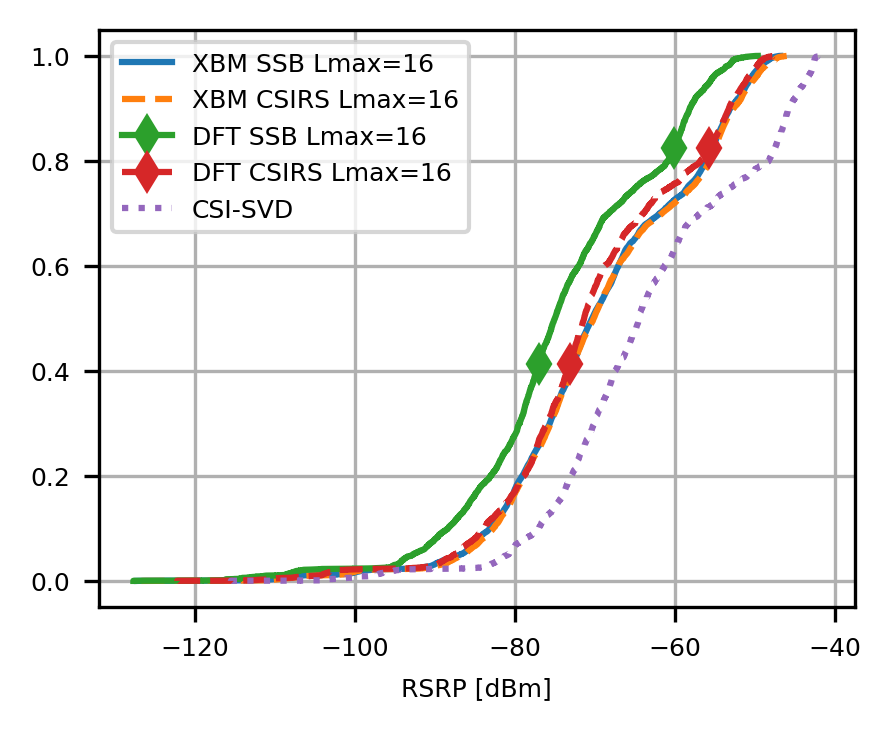

In [ ]:
algos = ["XBM", "DFT"]
markers = ["", "d"]

for i in range(2):
    ss = ssb[:, i]
    cs = csi[:, i]

    ecdf = ECDF(logx(ss[ss != 0]/270*20))
    plt.plot(ecdf.x, ecdf.y, markers[i]+"-", label=algos[i]+f" SSB Lmax={Lmax}", markevery=5000)

    ecdf = ECDF(logx(cs[cs != 0]/270*20))
    plt.plot(ecdf.x, ecdf.y, markers[i]+"--", label=algos[i]+f" CSIRS Lmax={Lmax}", markevery=5000)

ecdf = ECDF(logx(svd_powers[svd_powers != 0]/270*20))
plt.plot(ecdf.x, ecdf.y, ":", label="CSI-SVD")
plt.xlabel("RSRP [dBm]")
plt.legend()
plt.grid()


In [ ]:
bit_res = 2

for n_cri in [16]:
    ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2 = eval_campaign(channel_set, [xbm, dft_algo], model_types=['ML', 'dft'], evals=4000, bits=bit_res, csi_max=n_cri)

    filestring = path+f'results/raw/scene_A2B_updated_ssb_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}_ncri_{n_cri}.pickle'

    print("saving to ", filestring)
    with open(filestring, 'wb') as f:
        pickle.dump([ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2], f)

completed 1/4000
completed 201/4000
completed 401/4000
completed 601/4000
completed 801/4000
completed 1001/4000
completed 1201/4000
completed 1401/4000
completed 1601/4000
completed 1801/4000
completed 2001/4000
completed 2201/4000
completed 2401/4000
completed 2601/4000
completed 2801/4000
completed 3001/4000
completed 3201/4000
completed 3401/4000
completed 3601/4000
completed 3801/4000
ML size (1, 16, 256)
dft size (1, 16, 256)
saving to  /media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_1/results/raw/scene_A2B_updated_ssb_csi_16_16_16_16_16_ncri_16.pickle


In [ ]:
filestring = path+f'results/raw/scene_{scene_id}_ssb_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'

print("saving to ", filestring)
with open(filestring, 'wb') as f:
    pickle.dump([ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2], f)

saving to  /media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_1/results/raw/scene_A_ssb_csi_16_16_16_16_24.pickle


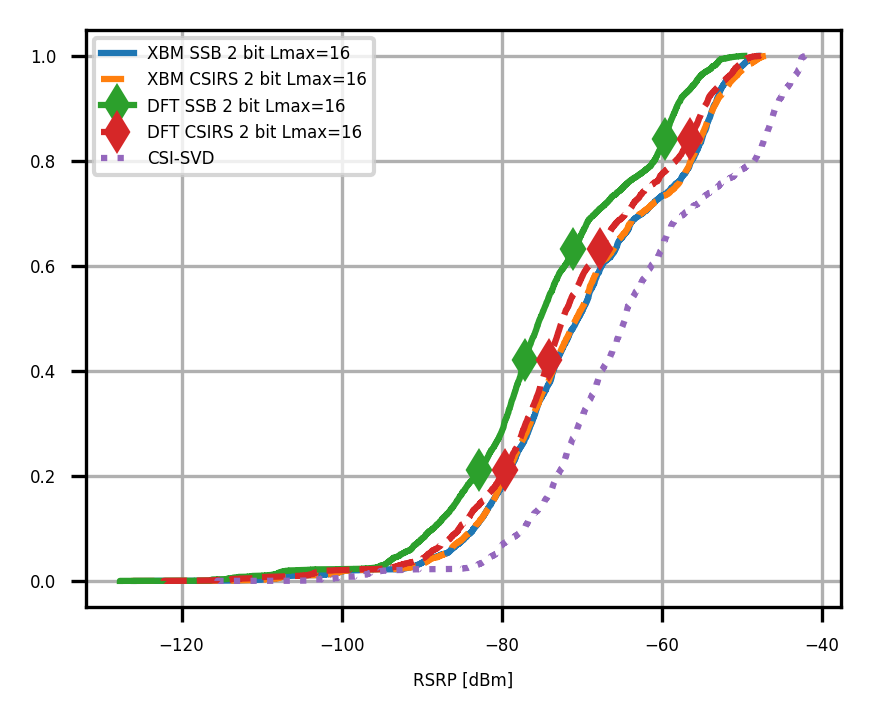

In [ ]:
algos = ["XBM", "DFT"]
markers = ["", "d"]

for i in range(2):
    ss = ssb2[:, i]
    cs = csi2[:, i]

    ecdf = ECDF(logx(ss[ss != 0]/270*20))
    plt.plot(ecdf.x, ecdf.y, markers[i]+"-", label=algos[i]+f" SSB {bit_res} bit Lmax={Lmax}", markevery=5000)

    ecdf = ECDF(logx(cs[cs != 0]/270*20))
    plt.plot(ecdf.x, ecdf.y, markers[i]+"--", label=algos[i]+f" CSIRS {bit_res} bit Lmax={Lmax}", markevery=5000)

ecdf = ECDF(logx(svd_powers2[svd_powers2 != 0]/270*20))
plt.plot(ecdf.x, ecdf.y, ":", label="CSI-SVD")
plt.xlabel("RSRP [dBm]")
plt.legend()
plt.grid()



In [ ]:
print(f"saving to {path + f'models/scene_{scene_id}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras'}")

xbm.ssb_network.save(path + f'models/scene_{scene_id}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')
xbm.csi_network.save(path + f'models/scene_{scene_id}_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')
xbm.evaluate(test_ds)

saving to /media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_1/models/scene_B_ssb_16_16_16_16_16.keras
78/78 [==============================] - 1s 7ms/step - ssb_loss: 0.6667 - csi_loss: 0.4484


[0.44863298535346985, 0.6649816036224365]

In [ ]:
# xbm = XBM()
print(f"loading from {path + f'models/scene_{scene_id}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras'}")

ssb_net = keras.models.load_model(path + f'models/scene_{scene_id}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')
csi_net = keras.models.load_model(path + f'models/scene_{scene_id}_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')

xbm = XBM(ssb_net, csi_net)
opt1 = keras.optimizers.Adam(learning_rate=1e-4)
opt2 = keras.optimizers.Adam(learning_rate=1e-5)

xbm.compile(opt1, opt2)
xbm.evaluate(test_ds)

loading from /media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_1/models/scene_B_ssb_16_16_16_16_16.keras
78/78 [==============================] - 1s 7ms/step - ssb_loss: 0.6747 - csi_loss: 0.4523


[0.4503600299358368, 0.6709264516830444]

Text(0, 0.5, 'PMF')

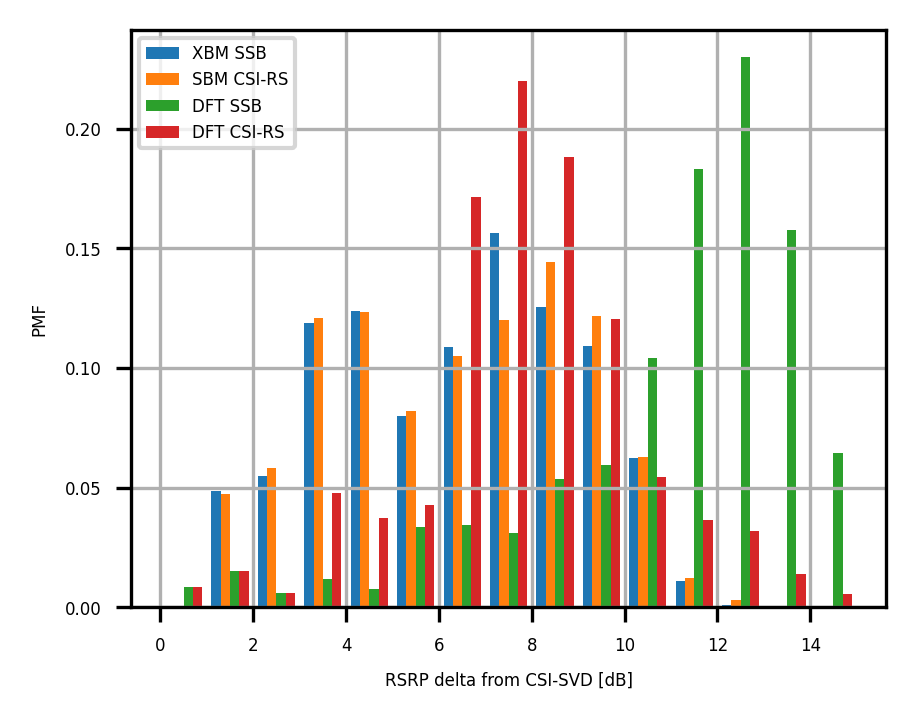

In [ ]:
labels = ["XBM", "DFT"]

double_delta = []
double_csi = []

for i in range(2):

    ss = ssb2[:, i]
    cs = csi2[:, i]

    ss = ss[ss != 0]
    cs = cs[cs != 0]
    svd_powers = svd_powers2[svd_powers2 != 0]

    double_delta.append(logx(svd_powers+1e-15) - logx(ss+1e-15))
    double_csi.append(logx(svd_powers+1e-15) - logx(cs+1e-15))

plt.hist([double_delta[0].flatten(), double_csi[0].flatten(), double_delta[1].flatten(), double_csi[1].flatten()], bins=15, range=[0, 15], density=True, label=["XBM SSB", "SBM CSI-RS", "DFT SSB", "DFT CSI-RS"])
# plt.hist(, bins=20, range=[0, 6], density=True, label="CSI-RS")
plt.xlabel("RSRP delta from CSI-SVD [dB]")
plt.legend()
plt.grid()
plt.ylabel("PMF")

# plt.savefig(path + 'results/RSRP_delta.pdf')

Text(0, 0.5, 'Estimated PDF')

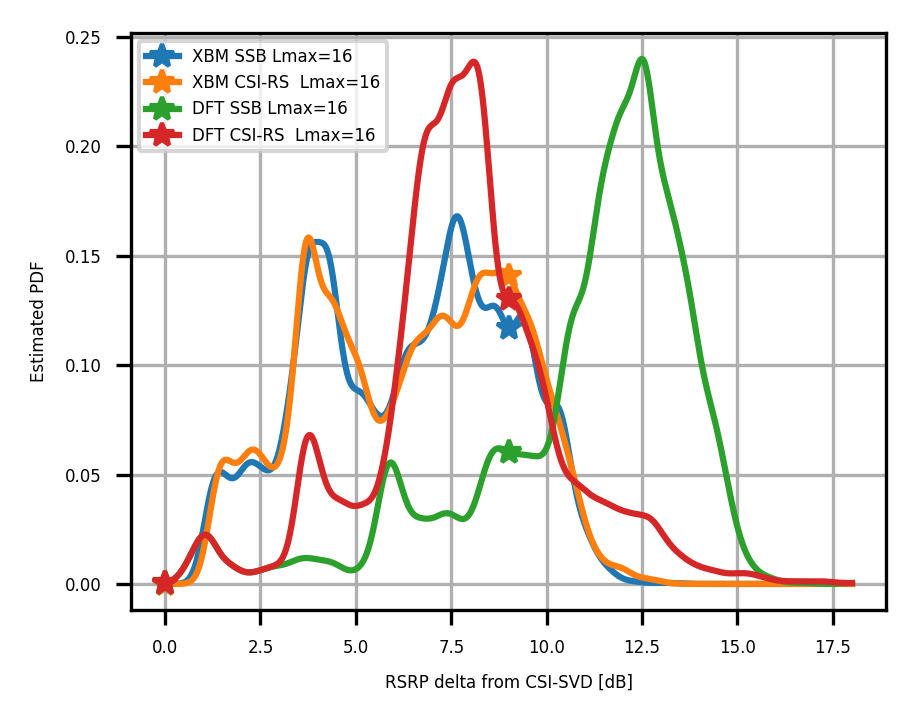

In [ ]:
labels = ["XBM", "DFT"]

for i in range(2):
    _ = pdf_plot(double_delta[i], label=labels[i]+f" SSB Lmax={Lmax}", xmax=18)
    pdf_plot(double_csi[i], label=labels[i] + f" CSI-RS  Lmax={Lmax}", xmax=18)

plt.grid()
plt.legend()
plt.xlabel("RSRP delta from CSI-SVD [dB]")
plt.ylabel("Estimated PDF")

# plt.savefig(path + f'results/RSRP_delta_scene_{scene_id}_{Nt}_{Lmax}.pdf', bbox_inches='tight')

In [ ]:
# need a forward and reversible version of active_beamspace, written in TF

# @tf.function()
def forward_beamspace(beams, Nx1=Nx1, Ny1=Ny1):
    a = tf.einsum('ny, blxy->blnx', tf_U_NyNy, beams)
    beamspace_cplx = tf.einsum('xn, blyx->blny', tf_U_NxNx, a) # [batch, lmax, Ny1, Nx1]
    beamspace = tf.cast(tf.concat([tf.math.real(beamspace_cplx), tf.math.imag(beamspace_cplx)], axis=1), dtype=tf.float32)
    return beamspace


# @tf.function()
def reverse_beamspace(beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    complex_beamspace = tf.cast(beamspace[:, :Lmax, :, :], tf.complex64) + 1j * tf.cast(beamspace[:, Lmax:, :, :], tf.complex64) # [?, Lmax, Nx, Ny]
    a = tf.einsum('nx, blny->blxy', tf_U_NxNx_inv, complex_beamspace)
    beams = tf.einsum('yn,blxn->blxy', tf_U_NyNy_inv, a)

    beams = tf.reshape(beams, [-1, Lmax, Nx*Ny])
    beams = beams / tf.linalg.norm(beams, axis=-1, keepdims=True) # * Nt
    return beams


@tf.function()
def tf_deconvert_beamspace(beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    # convert from beamspace to beamformers
    complex_beamspace = tf.cast(beamspace[:, :, :, :Lmax], tf.complex64) + 1j * tf.cast(beamspace[:, :, :, Lmax:], tf.complex64) # [?, Nx, Ny, Lmax]
    beams = tf.einsum('nx, bnyl->bxyl', tf_U_NxNx_inv, tf.einsum('yn,bxnl->bxyl', tf_U_NyNy_inv, complex_beamspace))
    beams = tf.reshape(tf.transpose(beams, [0, 3, 1, 2]), [-1, Lmax, Nx*Ny])
    beams = beams / tf.linalg.norm(beams, axis=-1, keepdims=True) * Nt
    return beams

def active_beamspace(beams, Nx1=Nx1, Ny1=Ny1):
    # beams should be shape [L*Nr, Nx, Ny]
    Lmax, Nx, Ny = beams.shape
    power_meas = np.zeros((Lmax, 2, Nx1, Ny1), dtype=np.float32)

    for k, beam in enumerate(beams):
        pm = (U_NyNy @ beam @ U_NxNx).T
        power_meas[k, 0, :, :] = pm.real
        power_meas[k, 1, :, :] = pm.imag

    return power_meas

def deactive_beamspace(beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    beamspace = beamspace[:, 0, :, :] + 1j*beamspace[:, 1, :, :]
    beams = np.zeros((Lmax, Nx, Ny), dtype=np.complex64)

    for k, beam in enumerate(beamspace):
        pm = (U_NyNy_inv @ beam @ U_NxNx_inv).conj().T
        beams[k] = pm / np.linalg.norm(pm)
    return beams

## Plotting

<b> Here we keep all the code for regenerating all the plots on beam training </b>

In [ ]:
matplotlib.rcParams.update({'font.size': 6})
scene_id = 'A'

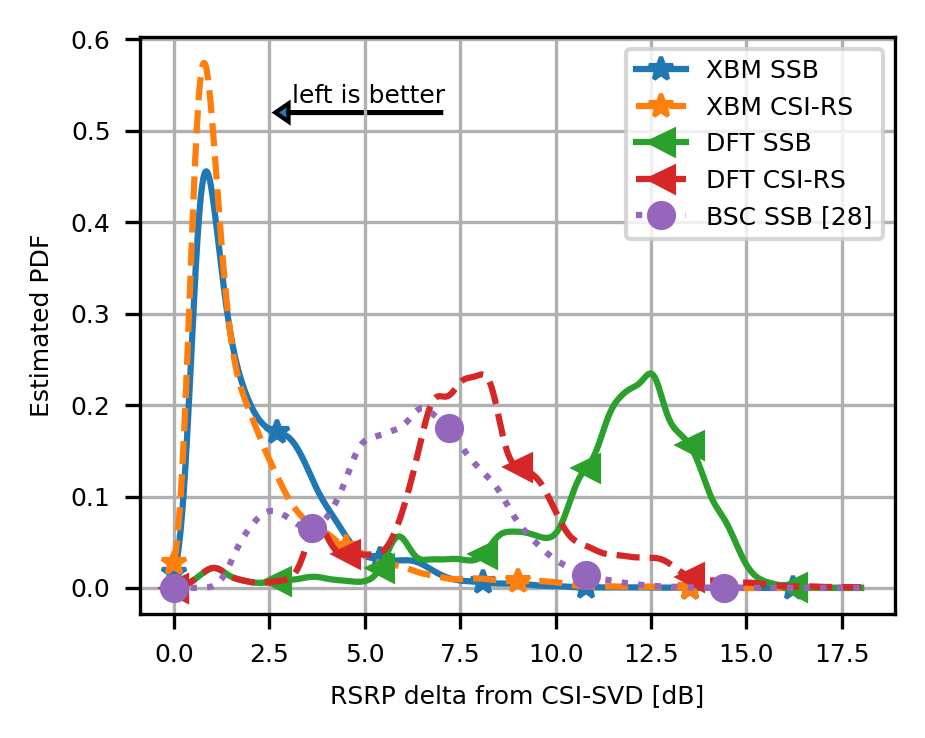

In [ ]:
filestring = path+f'results/raw/scene_{scene_id}_ssb_csi_{16}_{16}_{16}_{16}_{16}_ncri_16.pickle'

with open(filestring, 'rb') as f:
    ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2 = pickle.load(f)

with open(path+f'results/raw/old_paper.pickle', 'rb') as f:
    bsc_ssb, bsc_delta_ssb2, bsc_svd_pows = pickle.load(f)

double_delta = []
double_csi = []

for i in range(2):

    ss = ssb2[:, i]
    cs = csi2[:, i]

    ss = ss[ss != 0]
    cs = cs[cs != 0]
    svd_powers = svd_powers2[svd_powers2 != 0]

    double_delta.append(logx(svd_powers+1e-15) - logx(ss+1e-15))
    double_csi.append(logx(svd_powers+1e-15) - logx(cs+1e-15))


ss = bsc_ssb[:, 0]
ss = ss[ss != 0]
bsc_svd = bsc_svd_pows[bsc_svd_pows != 0]
double_delta.append(logx(bsc_svd+1e-15) - logx(ss+1e-15))


labels = ["XBM", "DFT", "BSC"]
markers = ['*', '<', 'o']

for i in range(2):
    _ = pdf_plot(double_delta[i], markers='-'+markers[i], markevery=300, label=labels[i]+f" SSB", xmax=18)
    pdf_plot(double_csi[i], markers='--'+markers[i], markevery=500, label=labels[i] + f" CSI-RS", xmax=18)

_ = pdf_plot(double_delta[-1], markers=':'+markers[-1], markevery=400, label=labels[-1]+f" SSB [28]", xmax=18)

plt.grid()
plt.legend()
plt.xlabel("RSRP delta from CSI-SVD [dB]")
plt.ylabel("Estimated PDF")

plt.text(3.1, 0.53, "left is better")
plt.arrow(7, 0.52, -4., 0, head_width=0.02, head_length=0.35)
# plt.savefig(path + f'results/RSRP_delta_scene_{scene_id}_{256}_{16}_annotated.pdf', bbox_inches='tight')

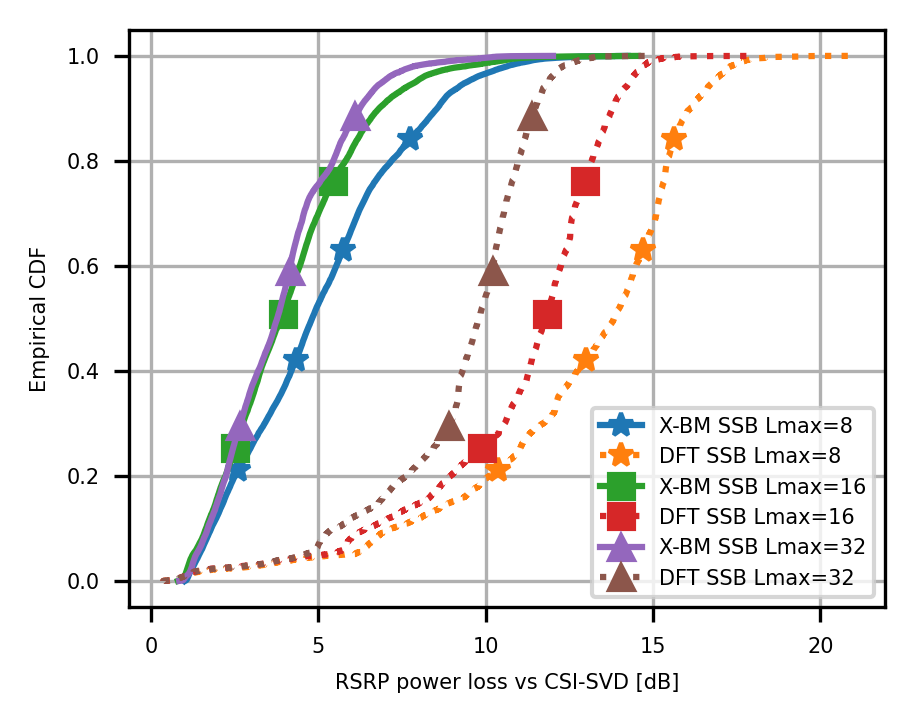

In [ ]:
# Lets start with a comparison of SSB performance with different codebook sizes as ECDF from CSI-SVD
Lmax_set = [8, 16, 32]
linefmt = ['-', ':']
markerfmt = ['*', 's', '^', '>']
names = ['X-BM SSB ', 'DFT SSB ']

for i, l in enumerate(Lmax_set):
    filestring = path+f'results/raw/scene_{scene_id}_ssb_csi_{16}_{16}_{16}_{16}_{l}_ncri_32.pickle'

    with open(filestring, 'rb') as f:
        ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2 = pickle.load(f)

    for j in range(2):
        ss = ssb2[:, j]
        ss = ss[ss != 0]
        svd_powers = svd_powers2[svd_powers2 != 0]

        delta_ss = logx(svd_powers+1e-15) - logx(ss+1e-15)
        ecdf = ECDF(delta_ss)
        plt.plot(ecdf.x, ecdf.y, linefmt[j], marker=markerfmt[i], markevery=5000+1000*i, label=names[j]+f'Lmax={l}')

plt.grid()
plt.legend()
plt.ylabel("Empirical CDF")
plt.xlabel("RSRP power loss vs CSI-SVD [dB]")
# plt.savefig(path + f'results/RSRP_delta_scene_{scene_id}_{256}.pdf', bbox_inches='tight')

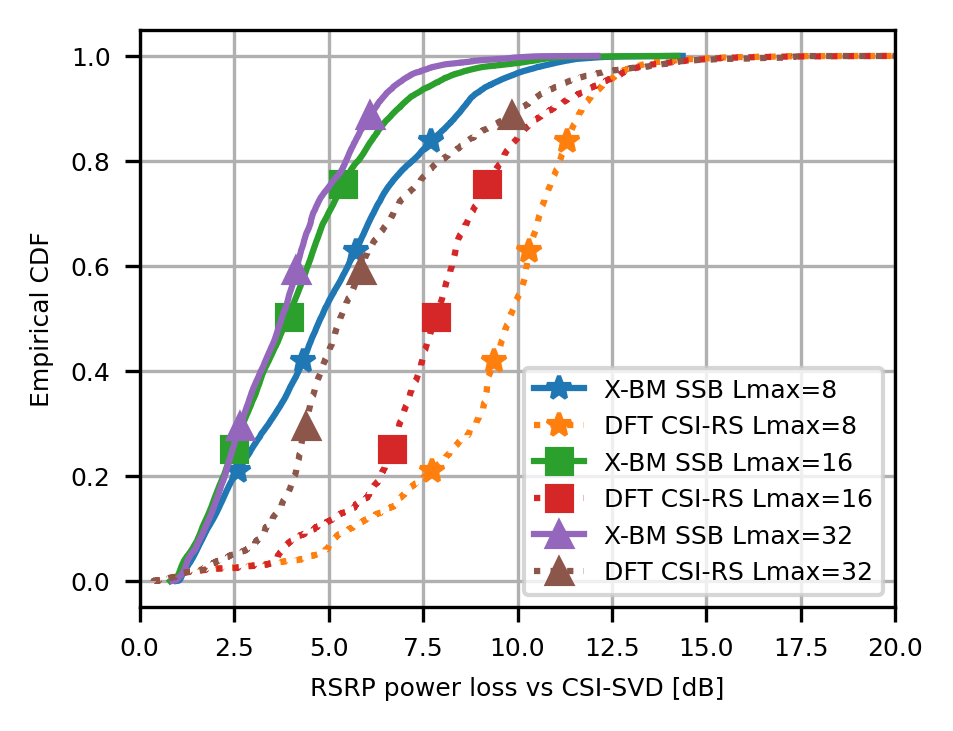

In [ ]:
# Lets start with a comparison of SSB performance with different codebook sizes as ECDF from CSI-SVD
ncri = 16
Lmax_set = [8, 16, 32]
linefmt = ['-', ':']
markerfmt = ['*', 's', '^', '>']
names = ['X-BM SSB ', 'DFT CSI-RS ']

for i, l in enumerate(Lmax_set):
    filestring = path+f'results/raw/scene_{scene_id}_ssb_csi_{16}_{16}_{16}_{16}_{l}_ncri_{ncri}.pickle'

    with open(filestring, 'rb') as f:
        ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2 = pickle.load(f)

    # for j in range(2):
    ss = ssb2[:, 0]
    ss = ss[ss != 0]
    svd_powers = svd_powers2[svd_powers2 != 0]
    cs = csi2[:, 1]
    cs = cs[cs != 0]

    delta_ss = logx(svd_powers+1e-15) - logx(ss+1e-15)
    delta_cs = logx(svd_powers+1e-15) - logx(cs+1e-15)
    ecdf = ECDF(delta_ss)
    plt.plot(ecdf.x, ecdf.y, linefmt[0], marker=markerfmt[i], markevery=5000+1000*i, label=names[0]+f'Lmax={l}')
    ecdf = ECDF(delta_cs)
    plt.plot(ecdf.x, ecdf.y, linefmt[1], marker=markerfmt[i], markevery=5000+1000*i, label=names[1]+f'Lmax={l}')

plt.grid()
plt.legend()
plt.ylabel("Empirical CDF")
plt.xlim([0, 20])
plt.xlabel("RSRP power loss vs CSI-SVD [dB]")
# plt.savefig(path + f'results/RSRP_delta_scene_{scene_id}_{256}_csirs.pdf', bbox_inches='tight')

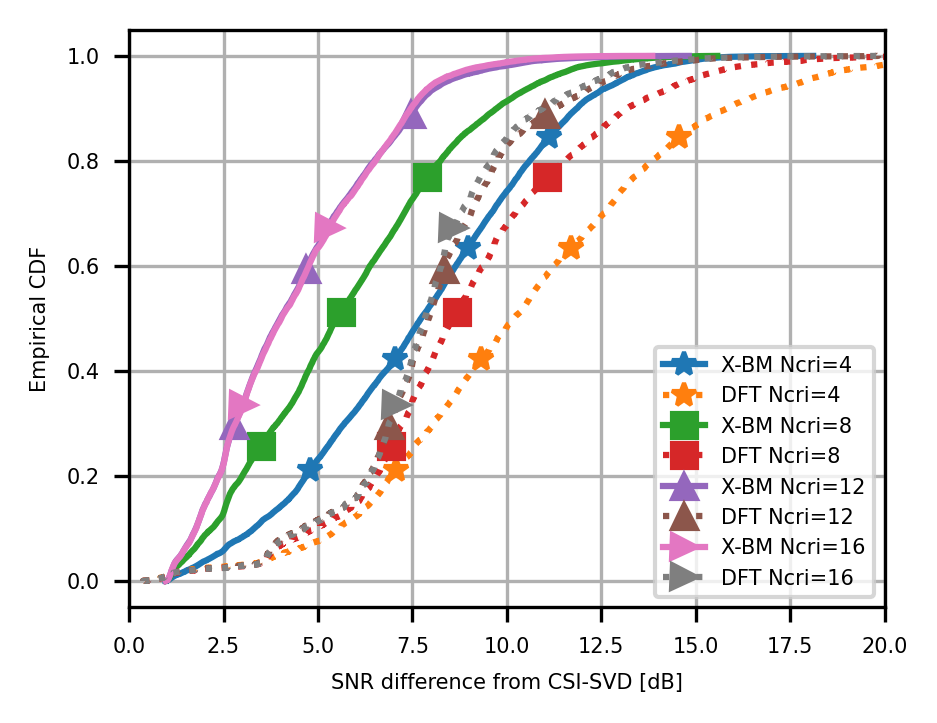

In [ ]:
# CSI-RS SNR
noise_figure = 7
noise_power = -174 + 10*np.log10(Ktotal * subcarrier_spacing)

def rsrp_to_snr(rsrp_db, offset=10):
    return rsrp_db - noise_power - offset

Lmax_s = 16
n_cri_set = [4, 8, 12, 16]
linefmt = ['-', ':']
markerfmt = ['*', 's', '^', '>']
names = ['X-BM ', 'DFT ']

for i, l in enumerate(n_cri_set):
    filestring = path+f'results/raw/scene_{scene_id}_ssb_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax_s}_ncri_{l}.pickle'

    with open(filestring, 'rb') as f:
        ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2 = pickle.load(f)

    ss = csi2[:, 0]
    ss = ss[ss != 0]
    svd_powers = svd_powers2[svd_powers2 != 0]
    cs = csi2[:, 1]
    cs = cs[cs != 0]

    delta_ss = logx(svd_powers+1e-15) - logx(ss+1e-15)
    delta_cs = logx(svd_powers+1e-15) - logx(cs+1e-15)
    ecdf = ECDF(delta_ss)
    plt.plot(ecdf.x, ecdf.y, linefmt[0], marker=markerfmt[i], markevery=5000+1000*i, label=names[0]+f'Ncri={l}')
    ecdf = ECDF(delta_cs)
    plt.plot(ecdf.x, ecdf.y, linefmt[1], marker=markerfmt[i], markevery=5000+1000*i, label=names[1]+f'Ncri={l}')

plt.grid()
plt.legend()
plt.ylabel("Empirical CDF")
plt.xlim([0, 20])
plt.xlabel("SNR difference from CSI-SVD [dB]");
plt.savefig(path + f'results/SNR_delta_scene_{scene_id}_{Nt}_csirs.pdf', bbox_inches='tight')

In [ ]:
Lmax_s = 16
n_cri_set = [4, 8, 16, 32, 64]
linefmt = ['-', ':']
markerfmt = ['*', 's', '^', '>']
names = ['X-BM ', 'DFT ']
ue_sets = np.arange(4, 16, 2)
rsrp_offset = 60

image = np.zeros((len(ue_sets), len(n_cri_set), 3))
for i, l in enumerate(n_cri_set):
    filestring = path+f'results/raw/ue_vs_ssb_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax_s}_ncri_{l}.pickle'
    with open(filestring, 'rb') as f:
        ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2 = pickle.load(f)
    avg_rsrp = np.mean(csi2, axis=1) # [ue_sets, algos, UEmax=16]
    for u in range(len(ue_sets)):
        avg_rsrp_u_dft = avg_rsrp[u, 1]
        avg_rsrp_u_dft = avg_rsrp_u_dft[avg_rsrp_u_dft > 0]

        avg_rsrp_u_xbm = avg_rsrp[u, 0]
        avg_rsrp_u_xbm = avg_rsrp_u_xbm[avg_rsrp_u_xbm > 0]
        image[u, i, 0] = np.mean(logx(avg_rsrp_u_xbm)+rsrp_offset)
        image[u, i, 1] = np.mean(logx(avg_rsrp_u_dft)+rsrp_offset)

for i, l in enumerate(n_cri_set):
    filestring = path+f'results/raw/ue_vs_ssb_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax_s}_ncri_{l}.pickle'
    with open(filestring, 'rb') as f:
        ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2 = pickle.load(f)
    avg_rsrp = np.mean(csi2, axis=1) # [ue_sets, algos, UEmax=16]
    for u in range(len(ue_sets)):
        avg_rsrp_u_dft = avg_rsrp[u, 1]
        avg_rsrp_u_dft = avg_rsrp_u_dft[avg_rsrp_u_dft > 0]

        avg_rsrp_u_xbm = avg_rsrp[u, 0]
        avg_rsrp_u_xbm = avg_rsrp_u_xbm[avg_rsrp_u_xbm > 0]
        image[u, i, 0] = np.mean(logx(avg_rsrp_u_xbm)+rsrp_offset)
        image[u, i, 1] = np.mean(logx(avg_rsrp_u_dft)+rsrp_offset)

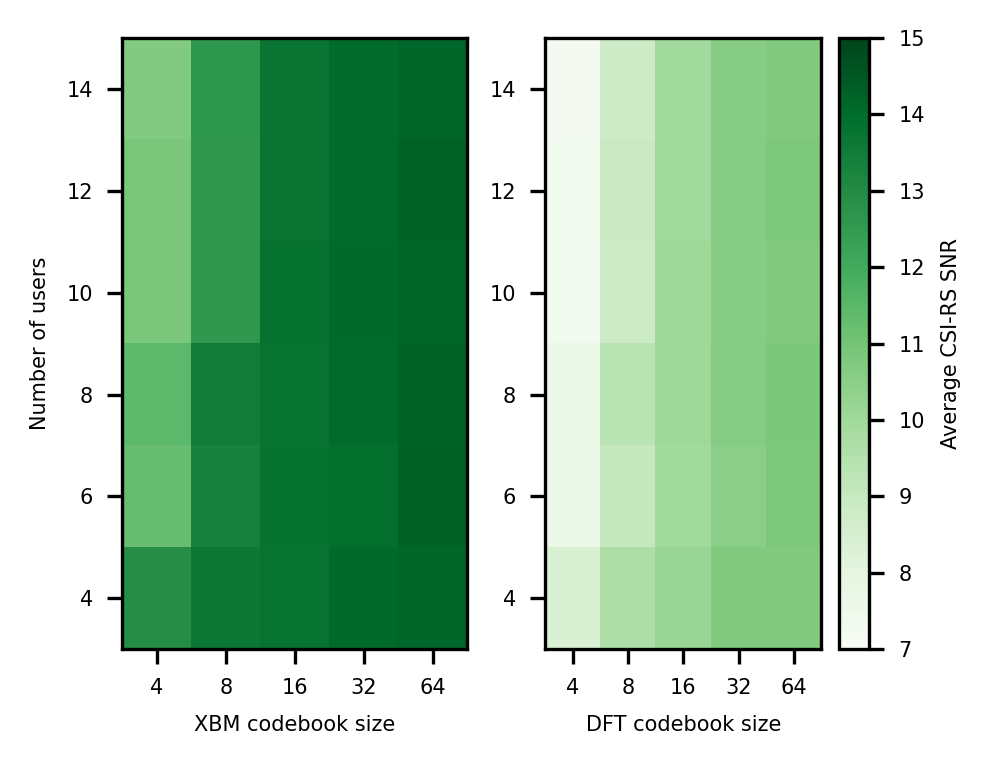

In [ ]:
from matplotlib.pyplot import cm

fig, axes = plt.subplots(1, 2)
vmin = 7
vmax = 15

plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], origin='lower', vmin=vmin, vmax=vmax, aspect="auto", cmap=cm.Greens)

axes[0].set_xticks(np.arange(image.shape[1]), minor=False)
axes[0].set_yticks(np.arange(image.shape[0]), minor=False)

axes[0].set_xticklabels(n_cri_set, minor=False)
axes[0].set_yticklabels(ue_sets, minor=False)


plt.xlabel("XBM codebook size")
plt.ylabel("Number of users")


plt.subplot(1, 2, 2)
plt.imshow(image[:, :, 1], origin='lower', vmin=vmin, vmax=vmax, aspect="auto", cmap=cm.Greens)
axes[1].set_xticks(np.arange(image.shape[1]), minor=False)
axes[1].set_yticks(np.arange(image.shape[0]), minor=False)


axes[1].set_xticklabels(n_cri_set, minor=False)
axes[1].set_yticklabels(ue_sets, minor=False)

cbar = plt.colorbar()
cbar.set_label('Average CSI-RS SNR')
plt.xlabel("DFT codebook size")

plt.tight_layout()
# plt.savefig(path + f'results/CSI_SNR_comparison.pdf', bbox_inches='tight')

(23797,)
(23776,)
(23747,)


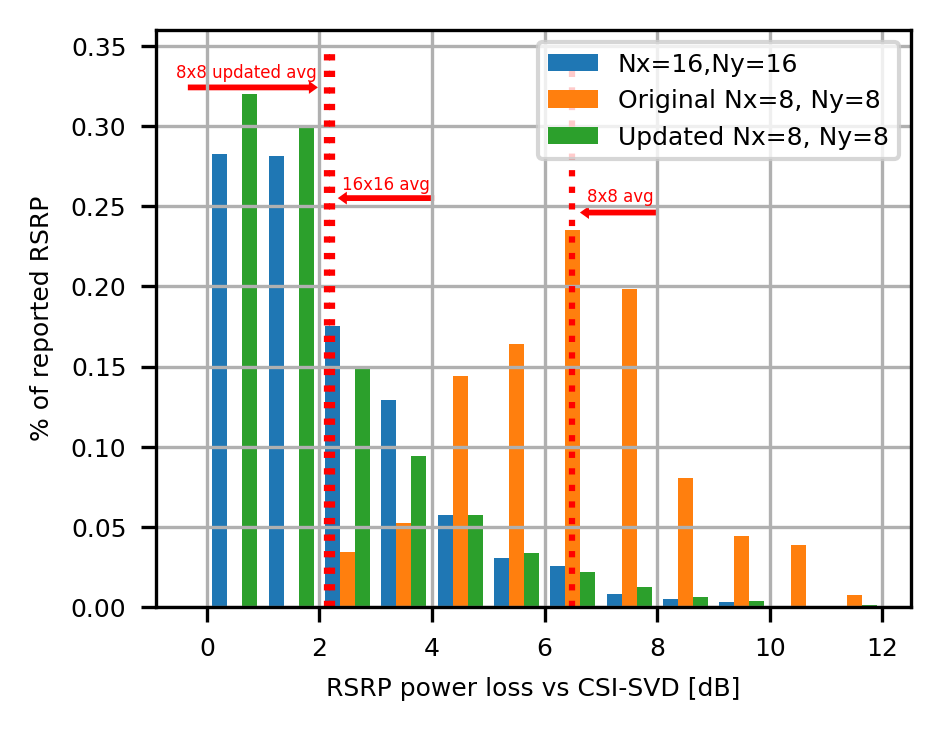

In [ ]:
# this one is a comparison across arrays, using a histogram
geo1 = [16, 16]
geo2 = [8, 8]
geo3 = [8, 8]
geos = [geo1, geo2, geo3]

labels = ["Nx=16,Ny=16", "Original Nx=8, Ny=8", "Updated Nx=8, Ny=8"]

data_for_hist = []
for i in range(len(geos)):
    if i==1:
        filestring = path+f'results/raw/scene_A_ssb_csi_{geos[i][0]}_{geos[i][1]}_{16}_{16}_{16}_ncri_{16}_2.pickle'
    else:
        filestring = path+f'results/raw/scene_A_ssb_csi_{geos[i][0]}_{geos[i][1]}_{16}_{16}_{16}_ncri_{16}.pickle'
    with open(filestring, 'rb') as f:
        ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2 = pickle.load(f)

    ss = ssb2[:, 0]
    ss = ss[ss != 0]
    svd_powers = svd_powers2[svd_powers2 != 0]
    delta_ss = logx(svd_powers+1e-15) - logx(ss+1e-15)
    data_for_hist.append(delta_ss)
    print(delta_ss.shape)


plt.hist(data_for_hist, bins=12, range=[0, 12], label=labels, density=True)

for i in range(3):
    meaner = np.mean(data_for_hist[i])
    plt.vlines(meaner, 0, 0.35,'r', linestyles=':')

plt.legend()
plt.grid();
plt.ylim([0, 0.36])
plt.xlabel("RSRP power loss vs CSI-SVD [dB]")
plt.ylabel("% of reported RSRP")
plt.text(-0.55, 0.33, "8x8 updated avg", fontsize=4, color='r')
plt.arrow(-0.3, 0.324, 2.15, 0, head_length=0.06, color='r')
plt.text(2.4, 0.26, "16x16 avg", fontsize=4, color='r')
plt.arrow(4, .255, -1.55, 0, head_length=0.06, color='r')
plt.text(6.75, 0.253, "8x8 avg", fontsize=4, color='r')
plt.arrow(7.95, .246, -1.2, 0, head_length=0.06, color='r')
plt.savefig(path + f'results/geometry_translation.pdf', bbox_inches='tight')

In [ ]:
def op_lookup(operations, lcsi=1, bwp=8, ncri=16, nrb=24, bg=4):
    index = np.where(np.all(np.array(operations)==np.array([lcsi, bwp, ncri, nrb, bg]), axis=1))
    if len(index[0]) < 1:
        print("No matching set found")
    elif len(index[0]) > 1:
        print("Somehow found more than one matching...")
    return index[0]

In [ ]:
Lcsi_set = np.array([1, 2, 4])
BWP_set = [1, 2, 4, 8]
n_cri_set = [4, 8, 12, 16]
N_RB_set = np.array([1])*24
n_UE_min = 6
n_UE_max = 14
beam_groups = [2, 4, 8]

SNR_offset = 1000000000

operations = list(product(Lcsi_set, BWP_set, n_cri_set, N_RB_set, beam_groups))
len(operations)

144

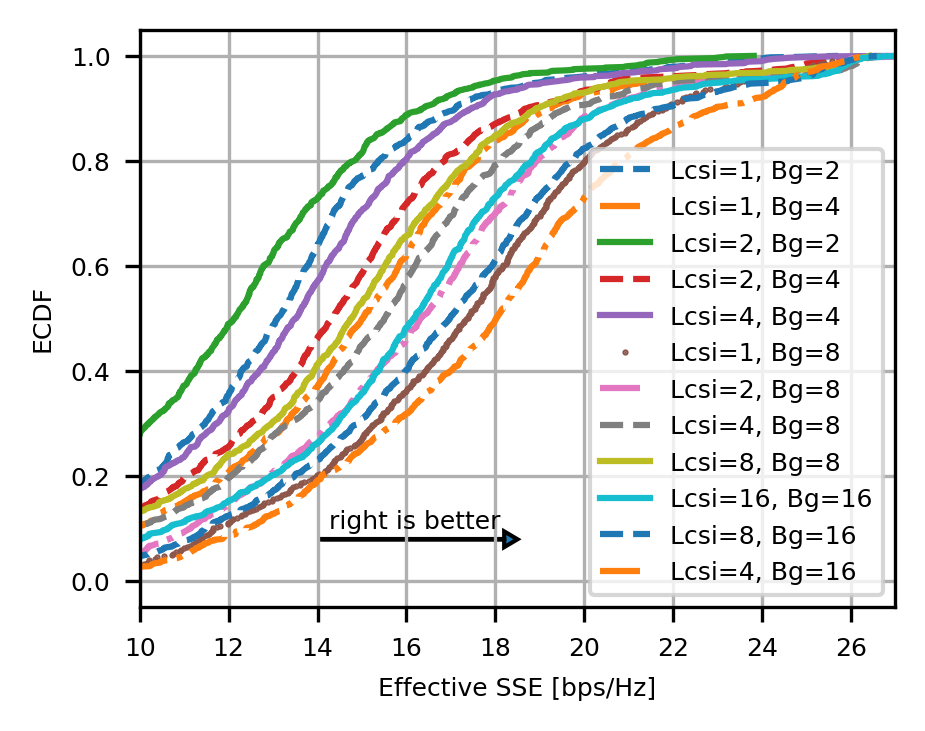

In [ ]:
# let me start by trying to plot some of the results from our algorithm
# Maybe an ECDF plot comparing Ncri and Lcsi

SSE = np.load(path+f'results/raw/SE_{140}_DFT_{3000}MC.npy')
operations = np.load(path+'results/raw/140_DFT_3000ops.npy')

# these are bg and Lcsi
comparison_points = [[2, 1], [4, 1], [2, 2], [4,2], [4, 4], [8, 1], [8, 2], [8,4], [8,8], [16, 16], [16, 8], [16,4]] # ['Ncsi=4, Lcsi=1', 'Ncsi=4, Lcsi=4', 'Ncsi=16, Lcsi=1', 'Ncsi=16, Lcsi=4', 'Ncsi=16, Lcsi=16']
ratios = [1/2, 1/4, 1, 1/2, 1, 1/8, 1/4, 1/2, 1, 1, 1/2, 1/4]
linestyles = {1:'-', 1/2:'--', 1/4:'-.', 1/8:'.'}

indexes = np.array([op_lookup(operations, lcsi=comparison_points[i][1], bg=comparison_points[i][0], ncri=16, bwp=4) for i in range(len(comparison_points))])
se_subset = SSE[indexes, :]
# bins = np.array([5, 10, 15, 20])
# n_UE_bins = np.digitize(n_UE, bins)
# SSE_bin = [SSE[:, n_UE_bins==i] for i in range(len(bins))]
# print(np.histogram(n_UE, bins=bins))

for i in range(len(indexes)):
    # ecdf = ECDF(se_subset[i, 0, se_subset[i, 0]>2])
    ecdf = ECDF(se_subset[i, se_subset[i]>5])
    plt.plot(ecdf.x, ecdf.y, linestyles[ratios[i]], markevery=3, markersize=1, label=f"Lcsi={comparison_points[i][1]}, Bg={comparison_points[i][0]}")

plt.legend()
plt.grid()
plt.xlabel("Effective SSE [bps/Hz]")
plt.ylabel("ECDF")
plt.xlim([10, 27])

plt.text(14.25, 0.1, "right is better")
plt.arrow(14.1, 0.08, 4.1, 0, head_width=0.03, head_length=0.3)
# plt.savefig(path + f'results/feedback_comparison.pdf', bbox_inches='tight')
plt.show()

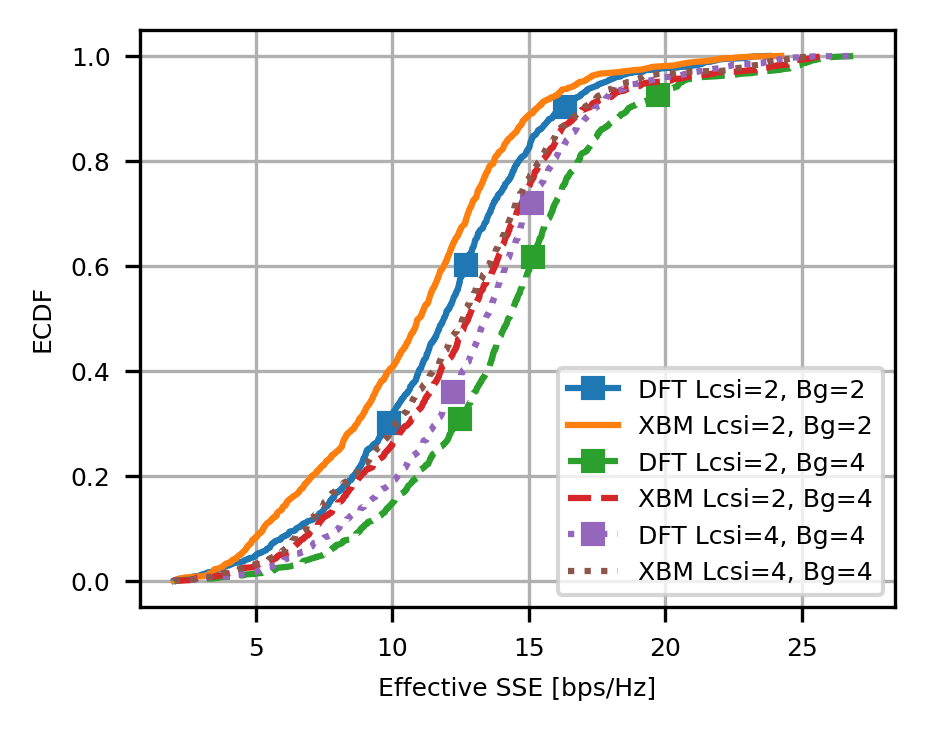

In [ ]:
# now we need a similar chart but comparing DFT and ML
method = 'DFT'
n_mc = 5000

# operations = np.load(path+f'results/raw/{method}_ops.npy')
SSE = np.load(path+f'results/raw/SE_{140}_DFT_{3000}MC.npy')
SSE2 = np.load(path+f'results/raw/SE_{140}_XBM_{3000}MC.npy')
mc1 = 5000
mc2 = 5000

# these are bg and Lcsi
comparison_points = [[2, 2], [4,2], [4, 4]] # ['Ncsi=4, Lcsi=1', 'Ncsi=4, Lcsi=4', 'Ncsi=16, Lcsi=1', 'Ncsi=16, Lcsi=4', 'Ncsi=16, Lcsi=16']

indexes = np.array([op_lookup(operations, lcsi=comparison_points[i][1], bg=comparison_points[i][0], bwp=4) for i in range(len(comparison_points))])
se_subset = SSE[indexes, :mc1]
se_subset2 = SSE2[indexes, :mc2]

linestyles = ['-', '--', ':']

bins = np.linspace(0, 20, num=100)
for i in range(3):
    ecdf1 = ECDF(se_subset[i, 0, se_subset[i, 0]>2])
    ecdf2 = ECDF(se_subset2[i, 0, se_subset2[i, 0]>2])
    plt.plot(ecdf1.x, ecdf1.y, linestyles[i]+'s', markevery=300+i*50, markersize=5, label=f"DFT Lcsi={comparison_points[i][1]}, Bg={comparison_points[i][0]}")
    plt.plot(ecdf2.x, ecdf2.y, linestyles[i], markevery=300, markersize=5, label=f"XBM Lcsi={comparison_points[i][1]}, Bg={comparison_points[i][0]}")

plt.legend()
plt.grid()
plt.xlabel("Effective SSE [bps/Hz]")
plt.ylabel("ECDF")
# plt.xlim([13, 27])
plt.savefig(path + f'results/ESSE_PMI2.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# environment translation
scene_id = 'A'
n_samples = 10_000

filestring = path+f'Scene_B_{n_samples}_channels_prepeel_{Nx}_{Ny}.pickle'

with open(filestring, "rb") as f:
    channel_set2 = pickle.load(f)


bit_res = 2

for n_cri in [8, 16]:
    ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2 = eval_campaign(channel_set2, [xbm, dft_algo], model_types=['ML', 'dft'], evals=4000, bits=bit_res, csi_max=n_cri)

    filestring = path+f'results/raw/scene_AB_ssb_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}_ncri_{n_cri}.pickle'

    print("saving to ", filestring)
    with open(filestring, 'wb') as f:
        pickle.dump([ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2], f)

completed 1/4000
completed 201/4000
completed 401/4000
completed 601/4000
completed 801/4000
completed 1001/4000
completed 1201/4000
completed 1401/4000
completed 1601/4000
completed 1801/4000
completed 2001/4000
completed 2201/4000
completed 2401/4000
completed 2601/4000
completed 2801/4000
completed 3001/4000
completed 3201/4000
completed 3401/4000
completed 3601/4000
completed 3801/4000
ML size (1, 8, 256)
dft size (1, 8, 256)
saving to  /media/ryan/Vol_2/SSB_Data/data_proc/XMIMO_1/results/raw/scene_AB_ssb_csi_16_16_16_16_16_ncri_8.pickle
completed 1/4000
completed 201/4000
completed 401/4000
completed 601/4000
completed 801/4000
completed 1001/4000
completed 1201/4000
completed 1401/4000
completed 1601/4000
completed 1801/4000
completed 2001/4000
completed 2201/4000
completed 2401/4000
completed 2601/4000
completed 2801/4000
completed 3001/4000
completed 3201/4000
completed 3401/4000
completed 3601/4000
completed 3801/4000
ML size (1, 16, 256)
dft size (1, 16, 256)
saving to  /medi

Text(0, 0.5, 'Estimated PDF')

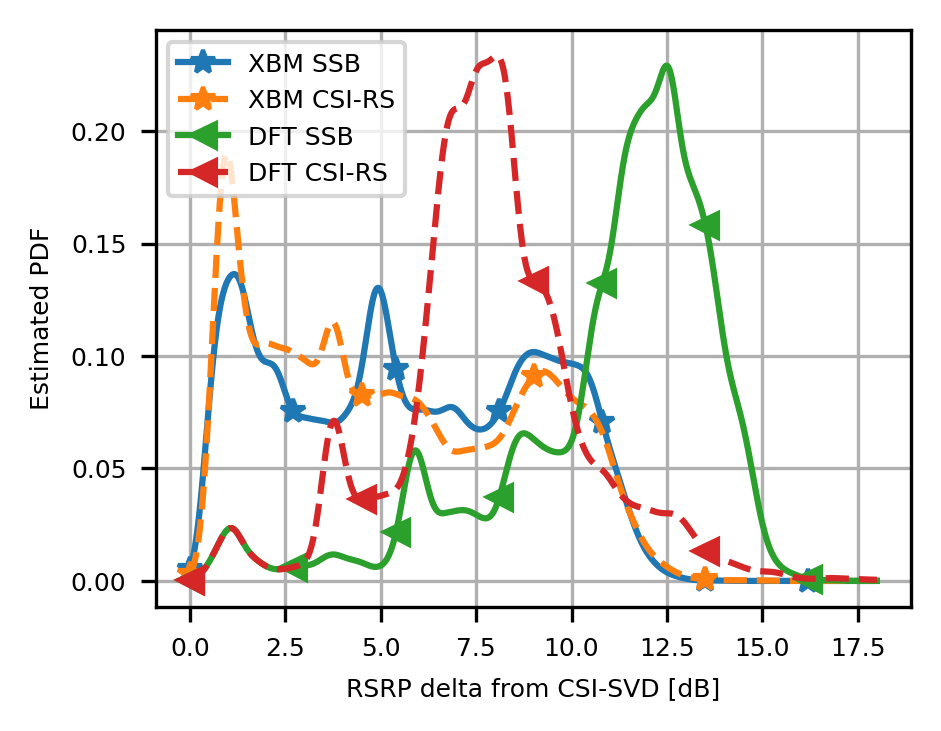

In [ ]:
filestring = path+f'results/raw/scene_B_ssb_csi_{16}_{16}_{16}_{16}_{16}_ncri_16.pickle'

with open(filestring, 'rb') as f:
    ssb2, csi2, svd_powers2, delta_ssb2, delta_csi2 = pickle.load(f)

double_delta = []
double_csi = []

for i in range(2):

    ss = ssb2[:, i]
    cs = csi2[:, i]

    ss = ss[ss != 0]
    cs = cs[cs != 0]
    svd_powers = svd_powers2[svd_powers2 != 0]

    double_delta.append(logx(svd_powers+1e-15) - logx(ss+1e-15))
    double_csi.append(logx(svd_powers+1e-15) - logx(cs+1e-15))

labels = ["XBM", "DFT"]
markers = ['*', '<']

for i in range(2):
    _ = pdf_plot(double_delta[i], markers='-'+markers[i], markevery=300, label=labels[i]+f" SSB", xmax=18)
    pdf_plot(double_csi[i], markers='--'+markers[i], markevery=500, label=labels[i] + f" CSI-RS", xmax=18)

plt.grid()
plt.legend()
plt.xlabel("RSRP delta from CSI-SVD [dB]")
plt.ylabel("Estimated PDF")

In [ ]:
# filestring = path+f'results/raw/scene_AB_ssb_csi_{16}_{16}_{16}_{16}_{16}_ncri_16.pickle'
filestring = path+f'results/raw/scene_B_ssb_csi_{16}_{16}_{16}_{16}_{16}_ncri_16.pickle'

double_delta = []
double_csi = []

with open(filestring, 'rb') as f:
    ssb, csi, svd_powers, delta_ssb, delta_csi = pickle.load(f)

for i in range(1):

    ss = ssb[:, i]
    cs = csi[:, i]

    ss = ss[ss != 0]
    cs = cs[cs != 0]
    svd_powers = svd_powers[svd_powers != 0]

    double_delta.append(logx(svd_powers+1e-15) - logx(ss+1e-15))
    double_csi.append(logx(svd_powers+1e-15) - logx(cs+1e-15))


filestring = path+f'results/raw/scene_A2B_updated_ssb_csi_{16}_{16}_{16}_{16}_{16}_ncri_16.pickle'


with open(filestring, 'rb') as f:
    ssb, csi, svd_powers, delta_ssb, delta_csi = pickle.load(f)

for i in range(2):

    ss = ssb[:, i]
    cs = csi[:, i]

    ss = ss[ss != 0]
    cs = cs[cs != 0]
    svd_powers = svd_powers[svd_powers != 0]

    double_delta.append(logx(svd_powers+1e-15) - logx(ss+1e-15))
    double_csi.append(logx(svd_powers+1e-15) - logx(cs+1e-15))


filestring = path+f'results/raw/scene_A2B_ssb_csi_{16}_{16}_{16}_{16}_{16}_ncri_16.pickle'

with open(filestring, 'rb') as f:
    ssb, csi, svd_powers, delta_ssb, delta_csi = pickle.load(f)

for i in range(1):

    ss = ssb[:, i]
    cs = csi[:, i]

    ss = ss[ss != 0]
    cs = cs[cs != 0]
    svd_powers = svd_powers[svd_powers != 0]

    double_delta.append(logx(svd_powers+1e-15) - logx(ss+1e-15))
    double_csi.append(logx(svd_powers+1e-15) - logx(cs+1e-15))



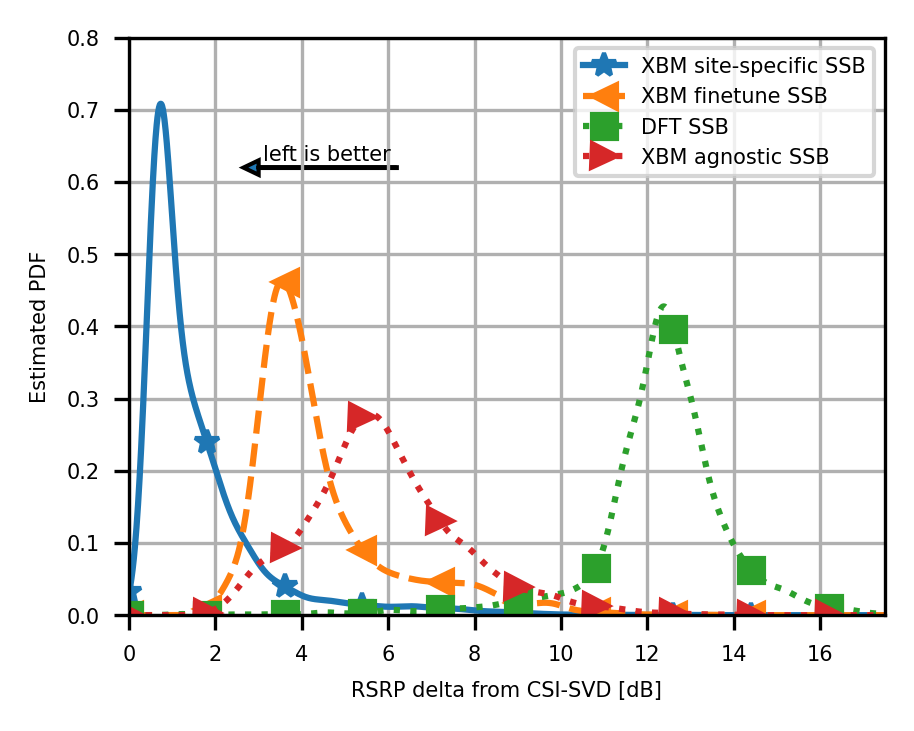

In [ ]:
labels = ["XBM site-specific", "XBM finetune", "DFT", "XBM agnostic", "DFT agnostic"]
markers = ['*', '<', 's', '>']
lines = ['-', '--', ':', ':']

for i in range(4):
    _ = pdf_plot(double_delta[i], markers=lines[i]+markers[i], markevery=200, label=labels[i]+f" SSB", xmax=18)
    # pdf_plot(double_csi[i], markers=lines[i]+markers[i], markevery=500, label=labels[i] + f" CSI-RS", xmax=18)

plt.grid()
plt.legend()
plt.xlabel("RSRP delta from CSI-SVD [dB]")
plt.xlim([0, 17.5])
plt.ylim([0, 0.8])
plt.ylabel("Estimated PDF")

plt.text(3.1, 0.63, "left is better")
plt.arrow(6.2, 0.62, -3.2, 0, head_width=0.02, head_length=0.35)
plt.savefig(path + f'results/SSB_scene_AB_annotated.pdf', bbox_inches='tight')


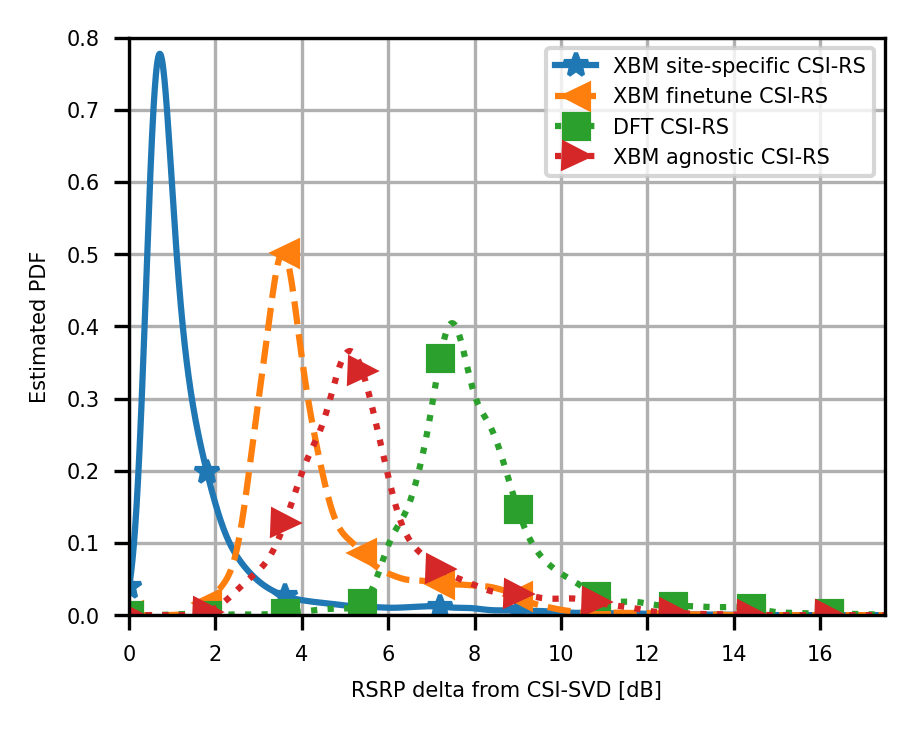

In [ ]:
labels = ["XBM site-specific", "XBM finetune", "DFT", "XBM agnostic", "DFT agnostic"]
markers = ['*', '<', 's', '>']
lines = ['-', '--', ':', ':']

for i in range(4):
    # _ = pdf_plot(double_delta[i], markers=lines[i]+markers[i], markevery=300, label=labels[i]+f" SSB", xmax=18)
    pdf_plot(double_csi[i], markers=lines[i]+markers[i], markevery=200, label=labels[i] + f" CSI-RS", xmax=18)

plt.grid()
plt.legend()
plt.xlabel("RSRP delta from CSI-SVD [dB]")
plt.xlim([0, 17.5])
plt.ylim([0, 0.8])
plt.ylabel("Estimated PDF")
plt.savefig(path + f'results/CSI_scene_AB_annotated.pdf', bbox_inches='tight')


In [ ]:
def rank_1_PMIless(H_active, ssb_codebook, sel_ue, ssb_snr, ssbri, Nx=Nx, Ny=Ny):
    # user selection only by SSB RSRP
    # ssb_snr, ssbri = UE_SSB_RSRP(H_active, ssb_codebook, boost=True, timing_res=2, ue_bf='digital')

    # print(ssb_codebook.shape, ssbri[sel_ue])
    precoder = ssb_codebook[ssbri[sel_ue], :, :] # [Nt, 1]
    precoders = np.expand_dims(precoder, axis=(0, 1, 2)).astype(np.complex128) # [U=1, T=1, B=1, Nt, Ns=1]
    SE_cost = 1

    channels_active = (H_active[sel_ue:sel_ue+1] / np.linalg.norm(H_active[sel_ue:sel_ue+1], axis=(3, 4), keepdims=True)).astype(np.complex128)
    U, T, K, Nr, Nt = channels_active.shape
    sinrs = np.zeros((T, K))
    # Now we need to split the channel into BWP frequency components
    snr = ssb_snr.astype(ctype)
    for t in range(T):
        for k in range(K):
            sinrs[t, k] = inner_mu_mimo_computation(np.ascontiguousarray(channels_active[:, t, k]), np.ascontiguousarray(precoders[:, 0, 0]), snr, UEs=1, Nt=Nt, Nr=Nr, Ns=1)

    sinrs = np.mean(sinrs, axis=1)
    SE = np.mean(np.log2(1+sinrs)) # mean over the Tspan
    return SE * SE_cost

def rank1_pmiless_invest(Hset, ssb_codebook, samples=500, tspan=10, n_UE_min=3, n_UE_max=12, save=True, prepend_string='', Nx=4, Ny=8):
    U = len(Hset)
    time_lim = Hset.shape[1]
    n_u_active = np.random.choice(np.arange(n_UE_min, n_UE_max), size=samples)
    tstart = np.random.choice(np.arange(time_lim), size=samples)
    SEs = np.zeros((samples,))

    for mc in range(samples):
        u_active = np.random.choice(np.arange(0, U), size=n_u_active[mc], replace=False).astype(np.int16)
        H_active = Hset[u_active]
        # print(H_active.shape)
        # ssb_rsrp, ssbri = UE_SSB_RSRP(H_active, ssb_codebook, boost=False, timing_res=2)
        ssb_rsrp, ssbri = tf_rsrp_rx_comb(H_active[:, :, :, :, 0].transpose(3, 0, 1, 2), ssb_codebook)
        sel_ue = np.argmax(ssb_rsrp[0])
        # print(ssb_codebook[0].shape, ssbri, sel_ue)
        SEs[mc,] = rank_1_PMIless(H_active, ssb_codebook[0], sel_ue, ssb_rsrp, ssbri=ssbri[0].numpy(), Nx=Nx, Ny=Ny, )

    if save:
        print(f"saving to {path+'results/raw/'+ prepend_string+f'rank1_{samples}Samples.npy'}")
        np.save(path+'results/raw/'+ prepend_string+f'rank1_{samples}Samples.npy', SEs)
    return SEs

In [ ]:
rank1_pmiless_invest(channel_set_test, ssb_codebook, tspan=1, n_UE_min=4, n_UE_max=14, Nx=Nx, Ny=Ny)

(16, 256) tf.Tensor([[8 8 8 8 8 8 8 8 8 8]], shape=(1, 10), dtype=int64) 4
(16, 256) 8


IndexError: ignored

## Channel estimation

In [ ]:
def get_csi_codebook(Nx=Nxd, Ny=Nyd, Oh=4, Ov=4):
    Dx = np.diag([np.exp(-1j*2*np.pi*n/Oh/Nx) for n in range(Nx)])
    Dy = np.diag([np.exp(-1j*2*np.pi*n/Ov/Ny) for n in range(Ny)])
    Ux = np.fft.fft(np.eye(Nx)) / np.sqrt(Nx)
    Uy = np.fft.fft(np.eye(Ny)) / np.sqrt(Ny)
    Bx = np.array([np.linalg.matrix_power(Dx, i) @ Ux for i in range(Oh)]) #[Oh, Nx, Nx]
    By = np.array([np.linalg.matrix_power(Dy, i) @ Uy for i in range(Ov)]) # Ov, Ny, Ny]
    Bodft = np.einsum('hxt,vyk->hvxytk', Bx, By).reshape(Oh, Ov, Nx, Ny, Nx*Ny)
    return Bodft.astype(ctype)

def dft_decomp(H, Bodft, Lcsi=1, return_recon=True):
    # first generate the oversampling matrices
    Nr, Nt = H.shape
    indices = np.zeros((Nr, Lcsi), dtype=np.int16)
    coeff = np.zeros((Nr, Lcsi), dtype=np.complex64)
    dft_beams = np.zeros((Nr, Lcsi, Nt), dtype=np.complex64)

    for nr in range(Nr):
        Heff = H[nr]
        all_evals = np.einsum('t,hvxyt->hvxy', Heff, Bodft.conj())
        best_ind = np.unravel_index(np.abs(all_evals).argmax(), all_evals.shape)
        Bdft = Bodft[best_ind[0], best_ind[1]]
        ortho_evals = np.einsum('t, xyt->xy', Heff, Bdft.conj())
        indices[nr, :] = np.argsort(np.abs(ortho_evals).flatten())[::-1][:Lcsi]
        for l in range(Lcsi):
            dft_beams[nr, l, :] = Bdft[np.unravel_index(indices[nr, l], Bdft.shape[:-1])]
            coeff[nr, l] = ortho_evals[np.unravel_index(indices[nr, l], Bdft.shape[:-1])]

    if return_recon:
        H_approx = np.sum(np.expand_dims(coeff, axis=-1) * dft_beams, axis=1)
        return indices, coeff, H_approx
    return indices, coeff

Bodft = get_csi_codebook(Nx=Nxd, Ny=Nyd)
Bodft.shape

(4, 4, 8, 4, 32)

In [ ]:
RB_tot = Ktotal
SC_per_RB = 12
BW = subcarrier_spacing * SC_per_RB * RB_tot

span = 20 # time in ms

sym_per_RB = 14 # time
RE_per_RB = sym_per_RB * SC_per_RB
total_RE = RB_tot * RE_per_RB * span

SSB_overhead = 240 * Lmax * sym_per_RB # in RE

def tx_loss_per_csi(n_cri=32, N_RB=24, Np=Nxd*Nyd):
    return n_cri * N_RB * Np # resource elements used

def c_log(x):
    return np.ceil(np.log2(x))

def feedback_loss_per_csi(U, n_cri=32, Nx=Nxd, Ny=Nyd, OH=4, OV=4, RI=4, Lcsi=1, BWP=1, bitsperRE=2, typeII=True, bpsHz=0.2344, enhanced=True):
    # assumptions
    if typeII:
        bits_phase = 4
        # bits_amp = 6 # 3 bits for wideband, 3 bits for subband
        bits_amp = 3
        bits_cophasing = 3
        bits_RI = 2
        bits_CQI = 5
        bits_RSRP = 7
        bits_cri = np.log2(n_cri)
        Knz = Lcsi

        if enhanced == False:
            bits_feedback = c_log(OH*OV) + c_log(math.comb(Nx*Ny, Lcsi))*BWP + c_log(2*Lcsi)*BWP + 3*(2*Lcsi - 1)*BWP + (c_log(2*Lcsi)+3*(2*Lcsi-1))* (RI-1)*BWP + bits_phase * RI *BWP + bits_amp * RI * BWP
        #               Oversampling,         beam indicators         (strongest coeff     amplitude                      for each rank
        else:
            bits_feedback = c_log(OH*OV) + c_log(math.comb(Nx*Ny, Lcsi)) + c_log(2*Lcsi) * RI + 4 * RI
            Mv = int(np.ceil(1/4*BWP*Lcsi/RI))
            N3 = BWP * Lcsi
            if N3 > 19:
                bits_feedback+= c_log(2*Mv) + c_log(math.comb(2*Mv-1, Mv-1))*RI + 3*(Knz-3) + 4*(Knz-3) + 2*RI*Lcsi * Mv
            else:
                bits_feedback+= 0           + c_log(math.comb(N3-1, Mv-1))*RI + 3*(Knz-4) + 4*(Knz-4) + 2*RI*Lcsi * Mv

        bits_feedback += bits_cophasing + bits_RI + bits_CQI + bits_RSRP + bits_cri

    else:
        bits_RSRP = 7
        bits_CQI = 5
        bits_RI = 2
        bits_PMI = 11
        bits_cri = np.log2(n_cri)

        bits_feedback = bits_PMI + bits_RSRP + bits_CQI + bits_RI + bits_cri

    # now calculate how many RE are needed
    RE = np.ceil(bits_feedback / bitsperRE)
    RB_used_per_UE = np.ceil(RE / RE_per_RB)

    return RB_used_per_UE*U*RE_per_RB

In [ ]:
@numba.jit(nopython=True, fastmath=True)
def get_coord_from_index(beam_idx, Nx=16, Ny=16, OH=4, OV=4):
    # returns the ind_x, oversampling_x, ind_y, oversampling_y
    # indices for a given beam codebook index
    # Note, this is only true for a codebook that increments vertically
    # a full set before moving one slot in X direction
    ind_x = beam_idx // (Ny * OH * OV)
    over_x = (beam_idx // (Ny * OV)) % OH
    ind_y = (beam_idx % (Ny * OV)) // OV
    over_y = (beam_idx % (Ny * OV)) % OV
    return [ind_x, over_x, ind_y, over_y]

@numba.jit(nopython=True, fastmath=True)
def get_index_from_coord(ind_x, o_x, ind_y, o_y, Nx=16, Ny=16, OH=4, OV=4):
    # returns the codebook index for a specific set of coordinates
    # Note, this is only true for a codebook that increments vertically
    # a full set before moving one slot in X direction
    beam_idx = 0
    beam_idx += ind_x * (Ny * OV * OH)
    beam_idx += o_x * (Ny * OV)
    beam_idx += ind_y * (OV)
    beam_idx += o_y
    return beam_idx

@numba.jit(nopython=True, fastmath=True)
def get_ortho_idxs(beam_idx, Nx=16, Ny=16, OH=4, OV=4):
    # returns the orthogonal set to test based on strongest beam_idx
    ind_x, over_x, ind_y, over_y = get_coord_from_index(beam_idx, Nx, Ny, OH, OV)
    x_set = np.arange(Nx)
    y_set = np.arange(Ny)
    all_ortho_beams = np.zeros((Nx, Ny), dtype=np.int64)
    for i in numba.prange(Nx):
        for j in numba.prange(Ny):
            all_ortho_beams[x_set[i], y_set[j]] = get_index_from_coord(x_set[i], over_x, y_set[j], over_y, Nx, Ny, OH, OV)
    return all_ortho_beams.T


@numba.jit(nopython=True, fastmath=True)
def max_beam_selection(codebook, channel, Nx=16, Ny=16, OH=4, OV=4, topk=1):
    # codebook should be of [?, Nt], channel is [Nt, ?] and topk defines how many beams to use
    scores = np.zeros((len(codebook,)))
    final_scores = np.zeros((topk,), dtype=ctype)
    final_inds = np.zeros((topk,), dtype=np.int16)
    angles = np.zeros_like(scores)
    for i in numba.prange(len(codebook)):
        a = (channel.T.conj()@codebook[i]).conj().T
        scores[i] = np.linalg.norm(a)
        angles[i] = np.angle(a[np.argmax(np.abs(a))])
    ind = np.argmax(scores)
    if topk == 1:
        final_inds[:] = ind
        final_scores[:] = scores[ind]*np.exp(1j*angles[ind])
    else:
        if OH == OV and OV == 1: # simplest scenario, not oversampling
            inds = np.argsort(scores)[::-1]
            final_inds[:] = inds[:topk]
            final_scores[:] = scores[inds[:topk]] *np.exp(1j*angles[inds[:topk]])
        else:
            ortho_idxs = get_ortho_idxs(ind, Nx, Ny, OH, OV)
            ortho_idxs = ortho_idxs.flatten()
            score_subset = scores[ortho_idxs]
            inds = np.argsort(score_subset)[::-1]
            orig_inds = ortho_idxs[inds]
            final_inds[:] = orig_inds[:topk]
            final_scores[:] = scores[orig_inds[:topk]] *np.exp(1j*angles[orig_inds[:topk]])
    return final_inds, final_scores

# @numba.njit()
def estimation_error(channel, beam_estimate):
    # Compute the estimation error via mse
    return np.linalg.norm(channel - beam_estimate) / (np.linalg.norm(channel, axis=(0, 1))+1e-15)

# @numba.jit(nopython=True)
def estimate_channel(codebook, inds, scores, Ns=1):
    # generates a reconstruction of the Ns rank effective channel
    if len(inds) == 1:
        channel_est = codebook[inds] * np.expand_dims(scores, axis=1)
        return_channel = np.expand_dims(channel_est, 1).T
    else:
        channel_est = np.sum(codebook[inds, :] * np.expand_dims(scores, axis=1), axis=0)
        return_channel = channel_est
    return_channel = return_channel.reshape(codebook[0:1].T.shape)
    return return_channel


def reconstruct_codebook(codebook, inds, scores, Ns=1):
    codebook = codebook.T
    if len(inds) == 1:
        recon = codebook[:, inds] * np.expand_dims(scores, axis=0)
        return_est = np.expand_dims(recon, 1).T
    else:
        recon = np.sum(codebook[:, inds] * np.expand_dims(scores, axis=0), axis=1)
        return_est = recon
    return_est = return_est.reshape(codebook[:, 0:1].shape).T
    return return_est



def decompose_DFT(Fset, kmax=4, Nx=4, Ny=8, OH=4, OV=4, return_est_error=False):
    # assumes an oversampled DFT matrix is used to breakdown a set of beamformers Fset [Lmax, Nt, 1]
    # returns the beam_indicies and beam_coeff of the [Lmax, kmax] beams decomposition
    Lmax, Nt = Fset.shape[:2]
    bs_codebook = gen_codebook(Nx=Nx, Ny=Ny, OH=OH, OV=OV)
    if Nt != Nx * Ny:
        raise("Error, beamformer Fset has a different antenna dimension than Nx Ny")
    beam_indices = np.zeros((Lmax, kmax), dtype=np.int16)
    beam_coeff = np.zeros((Lmax, kmax), dtype=ctype)
    if return_est_error:
        est_error = np.zeros((Lmax), dtype=np.float32)
    for beam in range(Lmax):
        beam_indices[beam], beam_coeff[beam] = max_beam_selection(bs_codebook, Fset[beam:beam+1, :, 0].T, Nx=Nx, Ny=Ny, OH=OH, OV=OV, topk=kmax)
        if return_est_error:
            est_chan = reconstruct_codebook(bs_codebook, beam_indices[beam], beam_coeff[beam])
            est_error[beam] = estimation_error(Fset[beam, :, 0], est_chan[0])
    if return_est_error:
        return beam_indices, beam_coeff, est_error
    else:
        return beam_indices, beam_coeff

def H_est_skip_BF(H_active, beams, CRI, SNR, N_RB=24, Lcsi=1, BWP=1, typeII=True, Nx=8, Ny=4, OH=4, OV=4, return_cqi=False):
    # same as H_est but ignore precoding beforehand
    U, T, K, Nr, Nt = H_active.shape

    RB_per = N_RB//(2*BWP) # assumes N_RB is always divisible by BWP={1, 2, 4, 8}
    RB_offsets = RB_offsets = np.arange(1, BWP+1) * K//(BWP+1)
    bs_codebook = gen_codebook(Nx=Nx, Ny=Ny, OH=OH, OV=OV)
    cqi = np.zeros((U, Nr, BWP))
    beams = beams.astype(ctype)

    Fshape = list(beams.shape[:2])
    full_rank = min(Fshape)
    Nyeff = int(min([Ny, np.floor(np.sqrt(Fshape[0]))]))
    Nxeff = int(Fshape[0] // Nyeff)
    bs_codebook = gen_codebook(Nx=Nxeff, Ny=Nyeff, OH=OH, OV=OV)
    H_active = H_active[:, :, :, :, :Fshape[0]].astype(ctype)
    H_estimates = np.zeros((U, BWP, Nr, Fshape[0]), dtype=ctype)

    for ue in range(len(CRI)):
        for b in range(BWP):
            Kmin = RB_offsets[b]-RB_per
            Kmax = RB_offsets[b]+RB_per
            H_avg = np.mean(H_active[ue, 0, Kmin:Kmax, :, :], axis=0)
            H_norm_factor = np.linalg.norm(H_avg, axis=0, keepdims=True)
            noise = 1/np.sqrt(2 * N_RB * SNR[ue]) * (np.random.randn(Nr, Fshape[0]) + 1j * np.random.randn(Nr, Fshape[0])) * H_norm_factor # * Nt # Nt factor is for the double-counted F power from SNR and H_norm_Factor
            H_est = H_avg + noise
            H_est = np.expand_dims(H_est, axis=-1).astype(ctype)
            inds, coeff = decompose_DFT(H_est, kmax=Lcsi, Nx=Nxeff, Ny=Nyeff, OH=OH, OV=OV, return_est_error=False)
            cqi[ue, :, b] = np.sum(abs(coeff), axis=1)
            if typeII:
                Q_H_est = np.zeros_like(H_avg)
                for nr in range(Nr):
                    Q_H_est[nr, :] = reconstruct_codebook(bs_codebook, inds[nr], coeff[nr])
            else:
                Q_H_est = np.zeros_like(H_avg)
                for nr in range(Nr):
                    Q_H_est[nr, :] = reconstruct_codebook(bs_codebook, inds[nr, 0:1], 1)
                # re-adjust to offset of first layer
                ind_x, over_x, ind_y, over_y = get_coord_from_index(inds[0, 0], Nx=Nxeff, Ny=Nyeff, OH=OH, OV=OV)
                o_x = over_x + 1
                o_y = over_y + 1
                if o_x >= OH:
                    o_x = over_x - 1
                if o_y >= OV:
                    o_y = over_y - 1
                offset_index = get_index_from_coord(ind_x, o_x, ind_y, o_y, Nx=Nx, Ny=Ny, OH=OH, OV=OV)
                if offset_index > Nx*Ny*OH*OV:
                    offset_index = get_index_from_coord(ind_x, o_x-2, ind_y, o_y, Nx=Nx, Ny=Ny, OH=OH, OV=OV)
                Q_H_est[1, :] = reconstruct_codebook(bs_codebook, [offset_index], 1)

            H_est = Q_H_est
            H_estimates[ue, b] = H_est
    if return_cqi:
        return H_estimates, cqi
    return H_estimates


def HFest(H_active, beams, CRI, SNR, N_RB=24, Lcsi=1, BWP=1, typeII=True, Nx=Nxd, Ny=Nyd, OH=4, OV=4, return_cqi=False):
    U, T, K, Nr, Nt = H_active.shape
    RB_per = N_RB//(2*BWP) # assumes N_RB is always divisible by BWP={1, 2, 4, 8}
    RB_offsets = RB_offsets = np.arange(1, BWP+1) * K//(BWP+1)

    cqi = np.zeros((U, Nr, BWP))
    beams = beams.astype(ctype)
    H_active = H_active.astype(ctype)
    Fshape = list(beams.shape[:2])
    full_rank = min(Fshape)
    Nyeff = Ny
    Nxeff = Fshape[0] // Nyeff

    bs_codebook = gen_codebook(Nx=Nxeff, Ny=Nyeff, OH=OH, OV=OV)
    H_estimates = np.zeros((U, BWP, Nr, Nx*Ny), dtype=ctype)

    for ue in range(len(CRI)):
        # determine the beamformed channel estimate
        # first group
        for b in range(BWP):
            Kmin = RB_offsets[b]-RB_per
            Kmax = RB_offsets[b]+RB_per
            HF_est = LS_est_multiRB(H_active[ue, 0, Kmin:Kmax, :, :], Fcri.T, SNR[ue])


@tf.function()
def tf_csirs_rsrp(H, beams):
    # assumes H is size [U, K, Nr, Nt] and beams is [groups, beamspergroup, Nt]
    rsrps = tf.abs(tf.norm(tf.reduce_mean(tf.einsum('ukrt,gbt->ukgrb', H[:, 0], beams), axis=1), axis=(-1, -2))) # [U, groups]
    return tf.argmax(rsrps, axis=1) # best beam group for each user

@tf.function()
def tf_csirs_abc(H, beams, Na=1):
    coeff = tf.reduce_mean(tf.einsum('ukrt,gbt->ukgrb', H[:, 0], beams), axis=1) # [u, g, Nr, Np]
    rsrps = tf.abs(tf.norm(coeff, axis=(-1, -2))) # [U, groups]
    results, indices = tf.math.top_k(rsrps, k=Na)
    return indices, tf.math.angle(coeff) # best beam group for each user


def H_est_ABC(H_active, beams, CRI, SNR, N_RB=24, Lcsi=1, BWP=1, typeII=True, Na=1, Nx=1, Ny=1, return_cqi=False):
    # same just now we only get the analog channel made of Lcsi beams
    U, T, K, Nr, Nt = H_active.shape
    RB_per = N_RB//(2*BWP) # assumes N_RB is always divisible by BWP={1, 2, 4, 8}
    RB_offsets = np.arange(1, BWP+1) * K//(BWP+1)
    cqi = np.zeros((U, Nr, BWP))
    beams = beams.astype(ctype)
    H_active = H_active.astype(ctype)
    Fshape = list(beams.shape[:2])
    beamsets = len(beams)
    Feff = np.zeros((U, Fshape[1], beams.shape[-1]), dtype=ctype)

    Nxeff = Nx
    Nyeff = Ny

    Bodft = get_csi_codebook(Nx=Nx, Ny=Ny)
    H_estimates = np.zeros((U, BWP, Nr, Fshape[1]), dtype=ctype)

    ue_cri_topk_cri, coeffs = tf_csirs_abc(H_active, beams, Na)
    coeffs = coeffs.numpy()
    for ue in range(len(CRI)):
        Fcri = beams[ue_cri_topk_cri[ue, 0]]
        beam_offset = coeffs[ue, ue_cri_topk_cri[ue, 0], 0:1, :]
        for l in range(Na-1):
            Fcri += beams[ue_cri_topk_cri[ue, l+1]] * np.exp(1j*np.pi*(coeffs[ue, ue_cri_topk_cri[ue, l+1], 0:1, :]+beam_offset))

        Feff[ue, :, :] = Fcri
        for b in range(BWP):
            Kmin = RB_offsets[b]-RB_per
            Kmax = RB_offsets[b]+RB_per

            HF_est = LS_est_multiRB(H_active[ue, 0, Kmin:Kmax, :, :], Fcri.T, SNR[ue])

            inds, coeff, happrox = dft_decomp(HF_est, Bodft, Lcsi=Lcsi)
            cqi[ue, :, b] = np.sum(abs(coeff), axis=1)

            H_est = happrox # HF_est
            H_estimates[ue, b] = H_est
    if return_cqi:
        return H_estimates, cqi, Feff
    return H_estimates, Feff



# code for channel estimation
def H_est(H_active, beams, CRI, SNR, N_RB=24, Lcsi=1, BWP=1, typeII=True, Nx=8, Ny=4, OH=4, OV=4, return_cqi=False):
    U, T, K, Nr, Nt = H_active.shape
    RB_per = N_RB//(2*BWP) # assumes N_RB is always divisible by BWP={1, 2, 4, 8}
    RB_offsets = np.arange(1, BWP+1) * K//(BWP+1)
    cqi = np.zeros((U, Nr, BWP))
    beams = beams.astype(ctype)
    H_active = H_active.astype(ctype)
    Fshape = list(beams.shape[:2])
    beamsets = len(beams)
    Feff = np.zeros((U, Fshape[1], beams.shape[-1]), dtype=ctype)

    Bodft = get_csi_codebook(Nx=Nx, Ny=Ny)
    H_estimates = np.zeros((U, BWP, Nr, Fshape[1]), dtype=ctype)

    ue_cri = tf_csirs_rsrp(H_active, beams)

    for ue in range(len(CRI)):
        # convert to using beams is [groups, beamspergroup, Nt]
        # then decide which group to use

        Fcri = beams[ue_cri[ue]]
        Feff[ue, :, :] = Fcri

        for b in range(BWP):
            Kmin = RB_offsets[b]-RB_per
            Kmax = RB_offsets[b]+RB_per
            norm_Hf = np.linalg.norm(np.mean(H_active[ue, 0, Kmin:Kmax, :, :] @ Fcri.T, axis=0), axis=(0, 1))
            HF_est = LS_est_multiRB(H_active[ue, 0, Kmin:Kmax, :, :], Fcri.T, SNR[ue])

            inds, coeff, happrox = dft_decomp(HF_est, Bodft, Lcsi=Lcsi)
            cqi[ue, :, b] = np.sum(abs(coeff), axis=1)

            H_est = happrox / np.linalg.norm(happrox, axis=(0, 1)) * norm_Hf # HF_est
            H_estimates[ue, b] = H_est
    if return_cqi:
        return H_estimates, cqi, Feff
    return H_estimates, Feff


def matrix_error(H_estimates, H_active):
    U, T, K = H_active.shape[:3]
    errors = np.zeros((U, T))


def H_est_error(H_active, beams, CRI, SNR, H_estimates=None, tspan=10, N_RB=24, Lcsi=1, BWP=1, typeII=True, Nx=4, Ny=8, OH=4, OV=4):
    if H_estimates is None:
        H_estimates, Feff = np.expand_dims(H_est(H_active, beams=beams, CRI=CRI, SNR=SNR, N_RB=N_RB, Lcsi=Lcsi, BWP=BWP, Nx=Nx, Ny=Ny, OH=OH, OV=OV), axis=1)
    else:
        if len(H_estimates.shape)== 4:
            H_estimates = np.expand_dims(H_estimates, axis=1)
        BWP = H_estimates.shape[2]
    H_active = H_active[:, :tspan]
    U, T, K = H_active.shape[:3]

    RB_offsets = RB_offsets = np.arange(BWP+1) * K//(BWP)
    errors = np.zeros((U, T))

    for u in range(U):
        for t in range(T):
            if BWP == 1:
                errors[u, t] = estimation_error(H_active[u, t, 0]@beams.T, H_estimates[u, 0, 0]) # H_estimates should be 5D always
            else:
                error_set = np.zeros((BWP,))+1000
                for b in range(BWP):
                    error_set[b] = np.mean([estimation_error(H_active[u, t, i]@Feff[u].T, H_estimates[u, 0, b]) for i in range(RB_offsets[b],RB_offsets[b+1])], axis=0)
                errors[u, t] = np.mean(error_set)

    return np.mean(errors, axis=1)

@numba.njit()
def LS_estimator(Hset, F, S, noise, K=1, Nr=Nr, Np=32):
    # assumes H is K x Nr x Nt, F is Nt x Np, estimates HF ~ Nr x Np and H ~ Nr x Nt with Nt=Np
    # SNR is linear scale

    HFests = np.zeros((K, Nr, Np), dtype=np.complex64)
    for k in numba.prange(K):
        Y = Hset[k] @ F @ S + noise[k] # Nr x Np
        HFests[k] = Y

    HFest = nb_mean_0(HFests)
    return HFest

# @numba.njit()
def LS_est_multiRB(Hset, F, SNR=10):
    # Hset is now [K, Nr, Nt]
    K, Nr, Nt = Hset.shape
    Hset = Hset.astype(ctype)
    F = F.astype(ctype)
    _, Np = F.shape

    S = np.eye(Np, dtype=np.complex64)

    noise = (1/np.sqrt(2*SNR*Nr*Np) * (np.random.randn(K, Nr, Np) + 1j*np.random.randn(K, Nr, Np)) * np.linalg.norm(Hset, axis=(1, 2), keepdims=True)).astype(ctype)
    noise = np.zeros_like(noise)

    Hkest = LS_estimator(Hset, F, S, noise, K=K, Nr=Nr, Np=Np)
    return Hkest

In [ ]:
# Need to test H_est performance, make sure it makes sense in each dimension of Lcsi, BWP
Lcsi_set = [1, 2, 4, 32] # np.arange(1, 33)
BWP_set = [1]
N_RB = np.arange(2, 3)*24
operations = list(product(Lcsi_set, BWP_set, N_RB))
SNR_offset = 100000
n_UE = 4

errors = np.zeros((len(operations),))

snr, cri = tf_rsrp_rx_comb(Ha[:, :, 0].transpose(1, 0, 2, 3), dft_algo.CSI_codebook[0].reshape(1, -1, Nt))
snr = snr[0] * SNR_offset
print(logx(snr), cri)


df = pd.DataFrame(columns=['Lcsi', 'BWP', 'N_RB', 'Overhead', 'Error'])
for i, operate in enumerate(operations):
    # print(operate)
    overhead = (tx_loss_per_csi(N_RB=operate[2]) + feedback_loss_per_csi(n_UE, RI=4, Lcsi=operate[0], BWP=operate[1], enhanced=True) )/ total_RE
    errors[i] = logx(np.sum(H_est_error(Ha, dft_algo.CSI_codebook[0], cri, snr, Lcsi=operate[0], BWP=operate[1], N_RB=operate[-1], Nx=8, Ny=6)))

    df.loc[i] = {'Lcsi': operate[0], 'BWP' : operate[1], 'N_RB' : operate[2], 'Overhead': overhead, 'Error': errors[i]}

print(df)

[ 8.131  5.308 17.968 -2.174 -1.131] tf.Tensor([[24 30 13  6  6]], shape=(1, 5), dtype=int64)
   Lcsi  BWP  N_RB  Overhead     Error
0     1    1    48  0.054921  6.971603
1     2    1    48  0.054921  6.953645
2     4    1    48  0.054921  6.925228
3    32    1    48  0.056402  6.622860


## Run Channels

In [ ]:
# @title Operations
# operations = list(product(Lcsi_set, BWP_set, n_cri_set, N_RB_set))
def op_lookup(lcsi=1, bwp=1, ncri=8, nrb=24):
    index = np.where(np.all(np.array(operations)==np.array([lcsi, bwp, ncri, nrb]), axis=1))
    if len(index[0]) < 1:
        print("No matching set found")
    elif len(index[0]) > 1:
        print("Somehow found more than one matching...")
    return index[0]



operations = [
    [1, 1, 8, 24],
    [2, 1, 8, 24],
    [4, 1, 8, 24],
    [8, 1, 8, 24],
    [16, 1, 8, 24],
    [1, 2, 8, 48],
    [2, 2, 8, 48],
    [4, 2, 8, 48],
    [8, 2, 8, 48],
    [16, 2, 8, 48],
    [1, 4, 8, 96],
    [2, 4, 8, 96],
    [4, 4, 8, 96],
    [8, 4, 8, 96],
    [16, 4, 8, 96],
    [1, 8, 8, 192],
    [2, 8, 8, 192],
    [4, 8, 8, 192],
    [8, 8, 8, 192],
    [16, 8, 8, 192],

    [1, 1, 16, 24],
    [2, 1, 16, 24],
    [4, 1, 16, 24],
    [8, 1, 16, 24],
    [16, 1,16, 24],
    [1, 2, 16, 48],
    [2, 2, 16, 48],
    [4, 2, 16, 48],
    [8, 2, 16, 48],
    [16, 2,16, 48],
    [1, 4, 16, 96],
    [2, 4, 16, 96],
    [4, 4, 16, 96],
    [8, 4, 16, 96],
    [16, 4,16, 96],
    [1, 8, 16, 192],
    [2, 8, 16, 192],
    [4, 8, 16, 192],
    [8, 8, 16, 192],
    [16, 8,16, 192],

    [1, 1, 32, 24],
    [2, 1, 32, 24],
    [4, 1, 32, 24],
    [8, 1, 32, 24],
    [16, 1,32, 24],
    [1, 2, 32, 48],
    [2, 2, 32, 48],
    [4, 2, 32, 48],
    [8, 2, 32, 48],
    [16, 2,32, 48],
    [1, 4, 32, 96],
    [2, 4, 32, 96],
    [4, 4, 32, 96],
    [8, 4, 32, 96],
    [16, 4,32, 96],
    [1, 8, 32, 192],
    [2, 8, 32, 192],
    [4, 8, 32, 192],
    [8, 8, 32, 192],
    [16, 8,32, 192],


    [1, 1, 8, 32],
    [2, 1, 8, 32],
    [4, 1, 8, 32],
    [8, 1, 8, 32],
    [16, 1, 8,32],
    [1, 2, 8, 64],
    [2, 2, 8, 64],
    [4, 2, 8, 64],
    [8, 2, 8, 64],
    [16, 2, 8,64],
    [1, 4, 8, 128],
    [2, 4, 8, 128],
    [4, 4, 8, 128],
    [8, 4, 8, 128],
    [16, 4, 8,128],
    [1, 8, 8, 256],
    [2, 8, 8, 256],
    [4, 8, 8, 256],
    [8, 8, 8, 256],
    [16, 8, 8,256],

    [1, 1, 16, 32],
    [2, 1, 16, 32],
    [4, 1, 16, 32],
    [8, 1, 16, 32],
    [16, 1,16, 32],
    [1, 2, 16, 64],
    [2, 2, 16, 64],
    [4, 2, 16, 64],
    [8, 2, 16, 64],
    [16, 2,16, 64],
    [1, 4, 16, 128],
    [2, 4, 16, 128],
    [4, 4, 16, 128],
    [8, 4, 16, 128],
    [16, 4,16, 128],
    [1, 8, 16, 256],
    [2, 8, 16, 256],
    [4, 8, 16, 256],
    [8, 8, 16, 256],
    [16, 8,16, 256],

    [1, 1, 32, 32],
    [2, 1, 32, 32],
    [4, 1, 32, 32],
    [8, 1, 32, 32],
    [16, 1,32, 32],
    [1, 2, 32, 64],
    [2, 2, 32, 64],
    [4, 2, 32, 64],
    [8, 2, 32, 64],
    [16, 2,32, 64],
    [1, 4, 32, 128],
    [2, 4, 32, 128],
    [4, 4, 32, 128],
    [8, 4, 32, 128],
    [16, 4,32, 128],
    [1, 8, 32, 256],
    [2, 8, 32, 256],
    [4, 8, 32, 256],
    [8, 8, 32, 256],
    [16, 8,32, 256]
]

print(len(operations))



120


In [ ]:
@numba.njit(fastmath=True)
def inner_mu_mimo_computation(norm_H, F, snr_factor, UEs=8, Nt=64, Nr=4, Ns=1):
    sinrs = np.zeros((UEs, Ns), dtype=np.float32)
    for i in numba.prange(UEs):
        precoder_internal = np.eye(Nr, dtype=np.complex128) * UEs * Nt / (snr_factor[i]+1e-10)
        precoder_partial = np.empty((UEs, Nr, Nr), dtype=np.complex128)
        for j in numba.prange(UEs):
            precoder_partial[j, :, :] = norm_H[i, :, :] @ F[j, :, :] @ F[j, :, :].conj().T @ norm_H[i, :, :].conj().T
        active_internal = precoder_internal + np.sum(precoder_partial, axis=0)
        reconstruct = norm_H[i, :, :].conj().T @ np.linalg.pinv(active_internal) @ norm_H[i, :, :]
        for j in numba.prange(Ns):
            tmp = F[i, :, j].conj().T @  reconstruct @ F[i, :, j]
            sinrs[i, j] = np.real(tmp / (1 - tmp+1e-8))
    return sinrs

@numba.njit(fastmath=True, parallel=True)
def outer_mimo_computation(H_scen, F_scen, SNRs, sinr_set, T=10, K=30, UEs=8, Nt=64, Nr=4, Ns=1):
    for t in numba.prange(T):
        for k in numba.prange(K):
            aset = inner_mu_mimo_computation(H_scen[t, k], F_scen[t, k], SNRs, UEs=UEs, Nt=Nt, Nr=Nr, Ns=Ns)
            sinr_set[t, k, :, :Ns] = aset
    return sinr_set

@numba.njit(fastmath=True, parallel=True)
def mimo_uneven_outer(H_scen, F_scen, SNRs, sinr_set, Ksub=30, UEs=8, Nt=64, Nr=4, Ns=1):
    # H_scen is [Ksub, U, Nr, Nt], F_scen is [U, Nt, Nr], sinr_set is [Ksub, U, Nr], where T and BWP selection are done outside of this
    for k in numba.prange(Ksub):
        aset = inner_mu_mimo_computation(H_scen[k], F_scen, SNRs, UEs=UEs, Nt=Nt, Nr=Nr, Ns=Ns)
        sinr_set[:, k, :] = aset
    return sinr_set


@tf.function()
def tf_inner_mu_mimo_computation(norm_H, F, snr_factor, UEs=8, Nt=64, Nr=4, Ns=1):
    pass

@tf.function()
def tf_mimo_uneven_outer(H_scen, F_scen, SNRs, sinr_set, Ksub=30, UEs=8, Nt=64, Nr=4, Ns=1):
    for k in tf.range(Ksub):
        aset = tf_inner_mu_mimo_computation(H_scen[k], F_scen, SNRs, UEs=UEs, Nt=Nt, Nr=Nr, Ns=Ns)
        sinr_set[:, k, :] = aset
    return sinr_set


@numba.njit(parallel=True)
def zf_precoder(channels, SNRs):
    # ZF for a single time-frequency unit with channel [U, <=Nr, Nt]
    # All channel must be used here, so only pass in channels with equal shape, and just zero and renorm after disabling some layers
    U, Ns, Nt = channels.shape
    precoders = np.zeros_like(channels).transpose(0, 2, 1)
    huhu = U * Nt * np.eye(Nt, dtype=ctype)  # U*N_T*I
    for ue in numba.prange(U):
        huhu = huhu + SNRs[ue] * channels[ue].conj().T @ channels[ue] #SNR_u * H_u' * H_u
    for ue in numba.prange(U):
        num = np.linalg.pinv(huhu) @ channels[ue].conj().T # [Nt, Nr]
        precoders[ue] = num
    return precoders


# Good idea would be to run this once for every number of UE? Idk.
def RZF_precoders_BWP(channels, SNRs, Ns_max=4):
    # assumes all channels and layers are active
    if len(channels.shape)==3:
        channels = np.expand_dims(np.expand_dims(channels, axis=1), axis=1)
    elif len(channels.shape) == 4:
        channels = np.expand_dims(channels, axis=1) # [UE, t, f, Nr, Nt]
    U, T, BWP, Nr, Nt = channels.shape
    precoders = np.zeros((U, T, BWP, Nt, Nr), dtype=ctype)
    for b in range(BWP):
        precoders[:, 0, b, :, :] = zf_precoder(np.ascontiguousarray(channels[:, 0, b, :, :]), SNRs)
    if Ns_max < Nr:
        precoders = precoders[:, :, :, :, :Ns_max]
    precoders = precoders / (np.linalg.norm(precoders, axis=(3, 4), keepdims=True) +1e-9)* np.sqrt(Nt) # hardcoded 32 here to resolve some issues
    return precoders


def sum_SE_estimate(channels, SNRs, Ns_max=4):
    if len(channels.shape)==3:
        channels = np.expand_dims(np.expand_dims(channels, axis=1), axis=1)
    elif len(channels.shape) == 4:
        channels = np.expand_dims(channels, axis=1) # [UE, t, f, Nr, Nt]
    U, T, BWP, Nr, Nt = channels.shape
    norm_H_terms = np.linalg.norm(channels, axis=(3, 4), keepdims=True)
    norm_H = (channels / norm_H_terms+1e-10).astype(np.complex128)
    # Essentially, perform RZF and estimate SINR and SE
    precoders = RZF_precoders_BWP(channels, SNRs, Ns_max=Ns_max)
    if np.any(np.isnan(precoders)):
        print("NaN in sumSEest precoders, attempting to resolve with random")
        precoders = np.random.randn(precoders.shape) +1j * np.random.randn(precoders.shape)
        precoders = precoders / (np.linalg.norm(precoders, axis=(3, 4), keepdims=True) +1e-9)* np.sqrt(32)
    precoders = precoders.astype(ctype)
    SNRs = SNRs.astype(np.complex128)
    sinrs = np.zeros((T, BWP, U, Ns_max), dtype=np.float32)
    norm_H = norm_H.transpose(1, 2, 0, 3, 4)
    precoders = precoders.transpose(1, 2, 0, 3, 4).astype(np.complex128)
    sinrs = outer_mimo_computation(norm_H, precoders, SNRs, sinrs, T=T, K=BWP, UEs=U, Nt=Nt, Nr=Nr, Ns=Ns_max)
    SE = np.sum(np.log2(1+sinrs), axis=1)
    SSE = np.sum(SE)
    return SSE


def rank_adaption(channels, SNRs, CQI, Umax=8, Ns_max=2):
    # CQI is shape [U, Nr, BWP], channels is [U, BWP, Nr, Nt], SNRs is [U]
    # Assumes served users get same # layers, total of up to 16 layers for each BWP
    # Assumes a greedy allocation based on CQI
    if len(channels.shape)==3:
        channels = np.expand_dims(np.expand_dims(channels, axis=1), axis=1)
    elif len(channels.shape) == 4:
        channels = np.expand_dims(channels, axis=1) # [UE, t, f, Nr, Nt]
    U, T, BWP, Nr, Nt = channels.shape
    Umax = min(U, Umax)
    Ns_max = min(Nr, Ns_max)
    possible_users = np.arange(1, Umax+1)
    possible_streams = np.arange(1, Ns_max+1) # 5G limit currently
    combinations = list(product(possible_users, possible_streams))
    SSE_set = np.zeros((len(combinations)))
    cqi_ue_norm = np.linalg.norm(CQI, axis=1)
    for i, combo in enumerate(combinations):
        ues = combo[0]
        streams = combo[1]
        H_active = np.zeros((ues, T, BWP, Nr, Nt), dtype=ctype)
        for b in range(BWP):
            active_ues = np.array(np_kargmax(cqi_ue_norm[:, b], ues))
            H_active[:, :, b, :, :] = channels[active_ues, :, b, :, :]
        SSE_set[i] = sum_SE_estimate(H_active, SNRs, Ns_max=streams)
    # return SSE_set
    best_combo = combinations[np.argmax(SSE_set)]
    # return which users and the precoder
    ues = best_combo[0]
    H_active = np.zeros((ues, T, BWP, Nr, Nt), dtype=ctype)
    for b in range(BWP):
        active_ues = np.array(np_kargmax(cqi_ue_norm[:, b], ues))
        H_active[:, :, b, :, :] = channels[active_ues, :, b, :, :]
    precoders = RZF_precoders_BWP(H_active, SNRs, Ns_max=best_combo[1])
    return active_ues, precoders


def sum_SE_true(est_channels, SNRs, CQI, channels, mean_over_time=True, Ns_max=2, Umax=8):
    # Final calculation here to figure out the actual SSE
    if len(est_channels.shape)==3:
        est_channels = np.expand_dims(np.expand_dims(est_channels, axis=1), axis=1)
    elif len(est_channels.shape) == 4:
        est_channels = np.expand_dims(est_channels, axis=1) # [UE, t, f, Nr, Nt]

    Umax = min([Umax, est_channels.shape[0]])
    active_ues, precoders = rank_adaption(est_channels, SNRs, CQI, Ns_max=Ns_max, Umax=Umax)
    Ns = precoders.shape[-1]
    channels_active = channels[active_ues]
    channels_active = channels_active / np.linalg.norm(channels_active, axis=(3, 4), keepdims=True)
    U, T, K, Nr, Nt = channels_active.shape
    BWP = est_channels.shape[2] # est channels is [U, BWP, Nr, Nt]
    sinrs = np.zeros((U, T, K, Ns), dtype=np.float32)
    # Now we need to split the channel into BWP frequency components
    H_splitK = np.array_split(channels_active.astype(np.complex128), BWP, axis=2)
    SNRs = SNRs.astype(np.complex128)
    precoders_t = precoders.transpose(1, 2, 0, 3, 4).astype(np.complex128)

    for t in range(T):
        k_curr = 0
        for b in range(BWP):
            norm_H = H_splitK[b].transpose(1, 2, 0, 3, 4) # [U, T, K//BWP, Nr, Nt] -> [T, K//BWP, U, Nr, Nt]
            k_range = norm_H.shape[1]
            sinrs[:, t, k_curr:k_curr+k_range, :] = mimo_uneven_outer(norm_H[t], precoders_t[0, b], SNRs, np.ascontiguousarray(sinrs[:, t, k_curr:k_curr+k_range, :]), Ksub=k_range, UEs=U, Nt=Nt, Nr=Nr, Ns=Ns)
            k_curr += k_range

    sinrs = np.mean(np.real(sinrs), axis=2)
    SE = np.sum(np.log2(1+sinrs), axis=2) # SE for [U, T]
    SSE = np.sum(SE, axis=0)
    if mean_over_time:
        SSE = np.mean(SSE)
    return SSE, active_ues.size


def effective_SSE_step(H_active, csi_rs_codebook, Lcsi=1, BWP=1, N_RB=24, snr_offset=1, Ns_max=2, Umax=8, effective=True, mean_over_time=True, return_ideal=False):
    # performs the steps using the above code or CSI aquisition and precoding evaluation
    snr, cri = UE_SSB_RSRP(H_active, csi_rs_codebook, boost=True, timing_res=2, ue_bf='digital')
    n_cri = len(csi_rs_codebook)
    K = H_active.shape[2]
    # snr = snr * snr_offset
    H_estimated, CQI = H_est(H_active, csi_rs_codebook, cri, snr*snr_offset, Lcsi=Lcsi, BWP=BWP, N_RB=N_RB, return_cqi=True)
    H_estimated = np.expand_dims(H_estimated, axis=1)
    SSE = sum_SE_true(H_estimated, snr, CQI, H_active, mean_over_time=mean_over_time, Ns_max=Ns_max, Umax=Umax)
    SE_cost = 1
    if effective:
        U = len(H_active)
        RE_cost = tx_loss_per_csi(N_RB=N_RB) + feedback_loss_per_csi(U, RI=4, Lcsi=Lcsi, BWP=BWP)  # Need to fill with DL overhead, UL overhead, and 10% cost
        SE_cost = 1 - RE_cost / total_RE

    if return_ideal:
        RB_per = N_RB//(2*BWP) # assumes N_RB is always divisible by BWP={1, 2, 4, 8}
        RB_offsets = RB_offsets = np.arange(1, BWP+1) * (K//(BWP+1))
        H_active_approx = np.zeros_like(H_estimated)
        for b in range(BWP):
            Kmin = RB_offsets[b]-RB_per
            Kmax = RB_offsets[b]+RB_per
            H_active_approx[:, :, b, :, :] = np.mean(H_active[:, 0:1, Kmin:Kmax, :, :], axis=2) # np.mean(H_active_BWP[b], axis=(1))
        SSE_max = sum_SE_true(H_active_approx, snr, CQI, H_active, mean_over_time=mean_over_time, Ns_max=Ns_max, Umax=Umax)
        return SSE * SE_cost, SSE_max * SE_cost
    if np.any(np.isnan(SSE)):
        print("NaN found, saving to", path)
        np.save(path+'failure_H', H_active)
        np.save(path+'fail_est_H', H_estimated)
        np.save(path+'failure_combo', [Lcsi, n_cri, Ns_max, Umax])
        np.save(path+'fail_snr', snr)
        np.save(path+'fail_cqi', CQI)
        np.save(path+'SSE', SSE)
    return SSE * SE_cost


def full_csi_step(H_active, ssb_codebook, n_cri=24, Lcsi=1, BWP=1, N_RB=24, snr_offset=1, return_ideal=False, Nx=4, Ny=8, OH=4, OV=4, Ns_max=2, Umax=8):
    # perform both SSB + CSI-RS for Hset_active[U, Tspan, K, Nr, Nt]
    U, T, K, Nr, Nt = H_active.shape
    # first, run SSB
    ssb_rsrp, ssbri = UE_SSB_RSRP(H_active, ssb_codebook, boost=False, timing_res=2)
    csirs_codebook = decompose_ssb_csirs(ssbri, ssb_codebook, n_cri=n_cri, Nx=Nx, Ny=Ny, OH=OH, OV=OV)
    if return_ideal:
        SSE, max_SSE = effective_SSE_step(H_active, csirs_codebook, Lcsi=Lcsi, BWP=BWP, N_RB=N_RB, snr_offset=snr_offset, return_ideal=True, Ns_max=Ns_max, Umax=Umax)
    else:
        SSE = effective_SSE_step(H_active, csirs_codebook, Lcsi=Lcsi, BWP=BWP, N_RB=N_RB, snr_offset=snr_offset, return_ideal=False, Ns_max=Ns_max, Umax=Umax)
    return SSE


def H_est_skip_BF(H_active, beams, CRI, SNR, N_RB=24, Lcsi=1, BWP=1, typeII=True, Nx=8, Ny=4, OH=4, OV=4, return_cqi=False):
    U, T, K, Nr, Nt = H_active.shape

    RB_per = N_RB//(2*BWP) # assumes N_RB is always divisible by BWP={1, 2, 4, 8}
    RB_offsets = RB_offsets = np.arange(1, BWP+1) * K//(BWP+1)
    bs_codebook = gen_codebook(Nx=Nx, Ny=Ny, OH=OH, OV=OV)
    cqi = np.zeros((U, Nr, BWP))
    beams = beams.astype(ctype)

    Fshape = list(beams.shape[:2])
    full_rank = min(Fshape)
    Nyeff = int(min([Ny, np.floor(np.sqrt(Fshape[0]))]))
    Nxeff = int(Fshape[0] // Nyeff)
    bs_codebook = gen_codebook(Nx=Nxeff, Ny=Nyeff, OH=OH, OV=OV)
    H_active = H_active[:, :, :, :, :Fshape[0]].astype(ctype)
    H_estimates = np.zeros((U, BWP, Nr, Fshape[0]), dtype=ctype)

    for ue in range(len(CRI)):
        for b in range(BWP):
            Kmin = RB_offsets[b]-RB_per
            Kmax = RB_offsets[b]+RB_per
            H_avg = np.mean(H_active[ue, 0, Kmin:Kmax, :, :], axis=0)
            H_norm_factor = np.linalg.norm(H_avg, axis=0, keepdims=True)
            noise = 1/np.sqrt(2 * N_RB * SNR[ue]) * (np.random.randn(Nr, Fshape[0]) + 1j * np.random.randn(Nr, Fshape[0])) * H_norm_factor # * Nt # Nt factor is for the double-counted F power from SNR and H_norm_Factor
            H_est = H_avg + noise
            H_est = np.expand_dims(H_est, axis=-1).astype(ctype)
            inds, coeff = decompose_DFT(H_est, kmax=Lcsi, Nx=Nxeff, Ny=Nyeff, OH=OH, OV=OV, return_est_error=False)
            cqi[ue, :, b] = np.sum(abs(coeff), axis=1)
            if typeII:
                Q_H_est = np.zeros_like(H_avg)
                for nr in range(Nr):
                    Q_H_est[nr, :] = reconstruct_codebook(bs_codebook, inds[nr], coeff[nr])
            else:
                Q_H_est = np.zeros_like(H_avg)
                for nr in range(Nr):
                    Q_H_est[nr, :] = reconstruct_codebook(bs_codebook, inds[nr, 0:1], 1)
                # re-adjust to offset of first layer
                ind_x, over_x, ind_y, over_y = get_coord_from_index(inds[0, 0], Nx=Nxeff, Ny=Nyeff, OH=OH, OV=OV)
                o_x = over_x + 1
                o_y = over_y + 1
                if o_x >= OH:
                    o_x = over_x - 1
                if o_y >= OV:
                    o_y = over_y - 1
                offset_index = get_index_from_coord(ind_x, o_x, ind_y, o_y, Nx=Nx, Ny=Ny, OH=OH, OV=OV)
                if offset_index > Nx*Ny*OH*OV:
                    offset_index = get_index_from_coord(ind_x, o_x-2, ind_y, o_y, Nx=Nx, Ny=Ny, OH=OH, OV=OV)
                Q_H_est[1, :] = reconstruct_codebook(bs_codebook, [offset_index], 1)

            H_est = Q_H_est
            H_estimates[ue, b] = H_est
    if return_cqi:
        return H_estimates, cqi
    return H_estimates


def HFest(H_active, beams, CRI, SNR, N_RB=24, Lcsi=1, BWP=1, typeII=True, Nx=Nxd, Ny=Nyd, OH=4, OV=4, return_cqi=False):
    U, T, K, Nr, Nt = H_active.shape
    RB_per = N_RB//(2*BWP) # assumes N_RB is always divisible by BWP={1, 2, 4, 8}
    RB_offsets = RB_offsets = np.arange(1, BWP+1) * K//(BWP+1)

    cqi = np.zeros((U, Nr, BWP))
    beams = beams.astype(ctype)
    H_active = H_active.astype(ctype)
    Fshape = list(beams.shape[:2])
    full_rank = min(Fshape)
    Nyeff = Ny
    Nxeff = Fshape[0] // Nyeff

    bs_codebook = gen_codebook(Nx=Nxeff, Ny=Nyeff, OH=OH, OV=OV)
    H_estimates = np.zeros((U, BWP, Nr, Nx*Ny), dtype=ctype)

    for ue in range(len(CRI)):
        # determine the beamformed channel estimate
        for b in range(BWP):
            Kmin = RB_offsets[b]-RB_per
            Kmax = RB_offsets[b]+RB_per
            HF_est = LS_est_multiRB(H_active[ue, 0, Kmin:Kmax, :, :], Fcri.T, SNR[ue])


@tf.function()
def tf_csirs_rsrp(H, beams):
    # returns the best beam group as the average over the bands
    # assumes H is size [U, K, Nr, Nt] and beams is [groups, beamspergroup, Nt]
    rsrps = tf.abs(tf.norm(tf.reduce_mean(tf.einsum('ukrt,gbt->ukgrb', H[:, 0], beams), axis=1), axis=(-1, -2))) # [U, groups]
    return tf.argmax(rsrps, axis=1) # best beam group for each user

@tf.function()
def tf_csirs_abc(H, beams, Na=1):
    coeff = tf.reduce_mean(tf.einsum('ukrt,gbt->ukgrb', H[:, 0], beams), axis=1) # [u, g, Nr, Np]
    rsrps = tf.abs(tf.norm(coeff, axis=(-1, -2))) # [U, groups]
    results, indices = tf.math.top_k(rsrps, k=Na)
    return indices, tf.math.angle(coeff) # best beam group for each user


def H_est_ABC(H_active, beams, CRI, SNR, N_RB=24, Lcsi=1, BWP=1, typeII=True, Na=1, Nx=1, Ny=1, return_cqi=False):
    # same shit just now we only get the analog channel made of Lcsi beams
    U, T, K, Nr, Nt = H_active.shape
    RB_per = N_RB//(2*BWP) # assumes N_RB is always divisible by BWP={1, 2, 4, 8}
    RB_offsets = np.arange(1, BWP+1) * K//(BWP+1)
    cqi = np.zeros((U, Nr, BWP))
    beams = beams.astype(ctype)
    H_active = H_active.astype(ctype)
    Fshape = list(beams.shape[:2])
    beamsets = len(beams)
    Feff = np.zeros((U, Fshape[1], beams.shape[-1]), dtype=ctype)

    Nxeff = Nx
    Nyeff = Ny

    Bodft = get_csi_codebook(Nx=Nx, Ny=Ny)
    H_estimates = np.zeros((U, BWP, Nr, Fshape[1]), dtype=ctype)

    ue_cri_topk_cri, coeffs = tf_csirs_abc(H_active, beams, Na)
    coeffs = coeffs.numpy()
    for ue in range(len(CRI)):
        Fcri = beams[ue_cri_topk_cri[ue, 0]]
        beam_offset = coeffs[ue, ue_cri_topk_cri[ue, 0], 0:1, :]
        for l in range(Na-1):
            Fcri += beams[ue_cri_topk_cri[ue, l+1]] * np.exp(1j*np.pi*(coeffs[ue, ue_cri_topk_cri[ue, l+1], 0:1, :]+beam_offset))

        Feff[ue, :, :] = Fcri
        for b in range(BWP):
            Kmin = RB_offsets[b]-RB_per
            Kmax = RB_offsets[b]+RB_per

            HF_est = LS_est_multiRB(H_active[ue, 0, Kmin:Kmax, :, :], Fcri.T, SNR[ue])

            inds, coeff, happrox = dft_decomp(HF_est, Bodft, Lcsi=Lcsi)
            cqi[ue, :, b] = np.sum(abs(coeff), axis=1)

            H_est = happrox # HF_est
            H_estimates[ue, b] = H_est
    if return_cqi:
        return H_estimates, cqi, Feff
    return H_estimates, Feff



# code for channel estimation
def H_est(H_active, beams, CRI, SNR, N_RB=24, Lcsi=1, BWP=1, typeII=True, Nx=8, Ny=4, OH=4, OV=4, return_cqi=False):
    U, T, K, Nr, Nt = H_active.shape
    RB_per = N_RB//(2*BWP) # assumes N_RB is always divisible by BWP={1, 2, 4, 8}
    RB_offsets = np.arange(1, BWP+1) * K//(BWP+1)
    cqi = np.zeros((U, Nr, BWP))
    beams = beams.astype(ctype)
    H_active = H_active.astype(ctype)
    Fshape = list(beams.shape[:2])
    beamsets = len(beams)
    Feff = np.zeros((U, Fshape[1], beams.shape[-1]), dtype=ctype)

    Nxeff = Nx
    Nyeff = Ny

    Bodft = get_csi_codebook(Nx=Nx, Ny=Ny)
    H_estimates = np.zeros((U, BWP, Nr, Fshape[1]), dtype=ctype)

    ue_cri = tf_csirs_rsrp(H_active, beams)

    for ue in range(len(CRI)):
        # convert to using beams is [groups, beamspergroup, Nt]
        # then decide which group to use
        Fcri = beams[ue_cri[ue]]
        Feff[ue, :, :] = Fcri

        for b in range(BWP):
            Kmin = RB_offsets[b]-RB_per
            Kmax = RB_offsets[b]+RB_per
            HF_est = LS_est_multiRB(H_active[ue, 0, Kmin:Kmax, :, :], Fcri.T, SNR[ue])
            inds, coeff, happrox = dft_decomp(HF_est, Bodft, Lcsi=Lcsi)
            cqi[ue, :, b] = np.sum(abs(coeff), axis=1)

            H_est = happrox # HF_est
            H_estimates[ue, b] = H_est
    if return_cqi:
        return H_estimates, cqi, Feff
    return H_estimates, Feff


def matrix_error(H_estimates, H_active):
    U, T, K = H_active.shape[:3]
    errors = np.zeros((U, T))


def H_est_error(H_active, beams, CRI, SNR, H_estimates=None, tspan=10, N_RB=24, Lcsi=1, BWP=1, typeII=True, Nx=4, Ny=8, OH=4, OV=4):
    if H_estimates is None:
        H_estimates, Feff = np.expand_dims(H_est(H_active, beams=beams, CRI=CRI, SNR=SNR, N_RB=N_RB, Lcsi=Lcsi, BWP=BWP, Nx=Nx, Ny=Ny, OH=OH, OV=OV), axis=1)
    else:
        if len(H_estimates.shape)== 4:
            H_estimates = np.expand_dims(H_estimates, axis=1)
        BWP = H_estimates.shape[2]
    H_active = H_active[:, :tspan]
    U, T, K = H_active.shape[:3]

    RB_offsets = RB_offsets = np.arange(BWP+1) * K//(BWP)
    errors = np.zeros((U, T))

    for u in range(U):
        for t in range(T):
            if BWP == 1:
                errors[u, t] = estimation_error(H_active[u, t, 0]@beams.T, H_estimates[u, 0, 0]) # H_estimates should be 5D always
            else:
                error_set = np.zeros((BWP,))+1000
                for b in range(BWP):
                    error_set[b] = np.mean([estimation_error(H_active[u, t, i]@Feff[u].T, H_estimates[u, 0, b]) for i in range(RB_offsets[b],RB_offsets[b+1])], axis=0)
                errors[u, t] = np.mean(error_set)

    return np.mean(errors, axis=1)

@numba.njit()
def LS_estimator(Hset, F, S, noise, K=1, Nr=Nr, Np=32):
    # assumes H is K x Nr x Nt, F is Nt x Np, estimates HF ~ Nr x Np and H ~ Nr x Nt with Nt=Np
    # SNR is linear scale

    HFests = np.zeros((K, Nr, Np), dtype=np.complex64)
    for k in numba.prange(K):
        Y = Hset[k] @ F @ S + noise[k] # Nr x Np
        HFests[k] = Y # @ np.linalg.pinv(S)

    HFest = nb_mean_0(HFests)
    return HFest

# @numba.njit()
def LS_est_multiRB(Hset, F, SNR=10):
    # Hset is now [K, Nr, Nt]
    K, Nr, Nt = Hset.shape
    Hset = Hset.astype(ctype)
    F = F.astype(ctype)
    _, Np = F.shape

    S = np.eye(Np, dtype=np.complex64)

    noise = (1/np.sqrt(2*SNR*Nr*Np) * (np.random.randn(K, Nr, Np) + 1j*np.random.randn(K, Nr, Np)) * np.linalg.norm(Hset, axis=(1, 2), keepdims=True)).astype(ctype)
    noise = np.zeros_like(noise)

    Hkest = LS_estimator(Hset, F, S, noise, K=K, Nr=Nr, Np=Np)
    return Hkest
    # Now we need to split the channel into BWP frequency components
    H_splitK = np.array_split(channels_active.astype(ctype), BWP, axis=2)
    snr = snr.astype(ctype)
    for t in range(T):
        k_curr = 0
        for b in range(BWP):
            norm_H = H_splitK[b] # [U, T, K//BWP, Nr, Nt]
            for ksub in range(norm_H.shape[2]):
                sinrs[t, k_curr, :] = inner_mu_mimo_computation(np.ascontiguousarray(norm_H[:, t, ksub]), np.ascontiguousarray(precoders[:, 0, b]), snr, UEs=1, Nt=Nt, Nr=Nr, Ns=2)
                k_curr+=1

    sinrs = np.mean(sinrs, axis=1)
    SE = np.sum(np.log2(1+sinrs), axis=1) # SE for [T]
    SE = np.mean(SE)
    return SE * SE_cost




def large_csi_investigation(Hset, ssb_codebook, samples=5000, n_cri=24, Lcsi=[1], BWP=[1], N_RB=[24], snr_offset=1, tspan=10, n_UE_min=3, n_UE_max=12, SU=True, save=True, prepend_string='', Nx=8, Ny=4):
    U = len(Hset)
    time_lim = Hset.shape[1]
    n_u_active = np.random.choice(np.arange(n_UE_min, n_UE_max), size=samples)
    tstart = np.random.choice(np.arange(time_lim), size=samples)
    ssb_codebook = DFT_codebook(n_beams=8, Nx=Nx, Ny=Ny)


    combinations = list(product(Lcsi, BWP, n_cri, N_RB))
    eff_SE = np.zeros((samples, len(combinations)))
    if SU:
        comb_su = list(product(BWP, n_cri, N_RB))
        SU_MIMO = np.zeros((samples, len(comb_su)))

    for mc in range(samples):
        u_active = np.random.choice(np.arange(0, U), size=n_u_active[mc], replace=False).astype(np.int16)
        H_active = Hset[u_active, tstart[mc]:tstart[mc]+tspan, :, :, :]
        ssb_rsrp, ssbri = UE_SSB_RSRP(H_active, ssb_codebook, boost=False, timing_res=2)
        for i, co in enumerate(combinations):
            if co[2] >= co[0]: # Less feedback than channel ports
                mid = co[2]//2
                csirs_codebook = decompose_ssb_csirs(ssbri, ssb_codebook, n_cri=co[2], Nx=Nx, Ny=Ny, OH=4, OV=4)
                csirs_codebook = csirs_codebook[:, :co[2], :]
                H_active_nt = H_active[:, :, :, :, :co[2]]
                eff_SE[mc, i] = effective_SSE_step(H_active_nt, csirs_codebook, Lcsi=co[0], BWP=co[1], N_RB=co[3], snr_offset=snr_offset, return_ideal=False, Umax=4)

        if SU:
            for i, co in enumerate(comb_su):
                csirs_codebook = decompose_ssb_csirs(ssbri, ssb_codebook, n_cri=co[1], Nx=Nx, Ny=Ny, OH=4, OV=4)
                SU_MIMO[mc, i] = SU_SE(H_active, csirs_codebook, BWP=co[0], N_RB=co[2], snr_offset=snr_offset)


        if samples >=20:
            if not (mc+1) % (samples//20):
                print(f"{(mc+1)/samples*100:.1f}% completed")
                if not (mc+1) % (samples//10) and save:
                    for i, co in enumerate(combinations):
                        filename = prepend_string + f"SE_{co[0]}Lcsi_{co[1]}BWP_{co[2]}CRI_{co[3]}NRB_{samples}Samples.npy"
                        np.save(path+'SE/'+filename, eff_SE[:, i])
                    if SU:
                        for i, co in enumerate(comb_su):
                            filename = prepend_string + f"SUSE_{co[0]}BWP_{co[1]}CRI_{co[2]}NRB_{samples}Samples.npy"
                            np.save(path+'SE/'+filename, SU_MIMO[:, i])
    if save:
        for i, co in enumerate(combinations):
            filename = prepend_string + f"SE_{co[0]}Lcsi_{co[1]}BWP_{co[2]}CRI_{co[3]}NRB_{samples}Samples.npy"
            np.save(path+'SE/'+filename, eff_SE[:, i])
        if SU:
            for i, co in enumerate(comb_su):
                filename = prepend_string + f"SUSE_{co[0]}BWP_{co[1]}CRI_{co[2]}NRB_{samples}Samples.npy"
                np.save(path+'SE/'+filename, SU_MIMO[:, i])

    if SU:
        return eff_SE, SU_MIMO
    return eff_SE

In [ ]:
np.random.seed(1)
# def run():
gc.collect()
n_mc = 1000
Lcsi_set = np.array([1, 2, 4, 8, 16])
BWP_set = [8]
n_cri_set = [16]
N_RB_set = np.array([1])*24
n_UE_min = 6
n_UE_max = 14
beam_groups = [1, 2, 4, 8, 16]

SNR_offset = 10000000

operations = list(product(Lcsi_set, BWP_set, n_cri_set, N_RB_set, beam_groups))

print(f"Running {n_mc}x{len(operations)} rounds")
errors = np.zeros((len(operations), n_mc))
active_ues = np.zeros_like(errors)
SSE = np.zeros_like(errors)
df = pd.DataFrame(columns=['Pcsi', 'Lcsi', 'BWP', 'N_RB', 'BG', 'Overhead', 'Error', 'SSE', 'avg U'])

n_UE = np.random.choice(np.arange(n_UE_min, n_UE_max), size=(n_mc))

for m in range(n_mc):
    UEs = np.random.choice(np.arange(5000), replace=False, size=(n_UE[m]))
    Tstart = np.random.choice(np.arange(250))
    H_ident = channel_set_test[UEs].transpose(0, 3, 4, 1, 2) * SNR_offset + 1e-15
    H_ident = H_ident.astype(ctype)

    snr, ssbri = tf_rsrp_rx_comb(H_ident[:, :, 0].transpose(1, 0, 2, 3), dft_algo.SSB_codebook.reshape(1, -1, Nt))
    snr = snr[0].numpy() + 1e-10
    for i, operate in enumerate(operations):
        lcsi = operate[0]
        bwp = operate[1]
        Nta = operate[2]
        bg = operate[4]

        if Nta >= bg and not Nta%bg: # need at least as many beams as beams per groups
            csirs_codebook = prop_sel(dft_algo.SSB_codebook, dft_algo.CSI_codebook, ssbri, Lmax, Nta)
            # np.random.shuffle(csirs_codebook)
            csirs_codebook = csirs_codebook.reshape((-1, bg, Nt))
            csirs_codebook = csirs_codebook / np.linalg.norm(csirs_codebook, axis=(-2, -1), keepdims=True) * Nt
            snr, cri = tf_rsrp_rx_comb(H_ident[:, :, 0].transpose(1, 0, 2, 3), csirs_codebook.reshape(1, -1, Nt))
            snr = snr[0].numpy() + 1e-10
            cri = cri[0].numpy()

            nrb = operate[3]
            if lcsi <= bg: # don't run otherwise
                if bg == 1:
                    Nxeff = 1
                    Nyeff = 1
                if bg == 2:
                    Nxeff = 2
                    Nyeff = 1
                if bg == 4:
                    Nxeff = 2
                    Nyeff = 2
                if bg == 8:
                    Nxeff = 4
                    Nyeff = 2
                if bg == 16:
                    Nxeff = 4
                    Nyeff = 4

                H_a = H_ident[:, :, :, :, :Nt]

                H_estimates, CQI, Feff = H_est(H_a, beams=csirs_codebook, CRI=cri, SNR=snr, N_RB=nrb, Lcsi=lcsi, BWP=bwp, Nx=Nxeff, Ny=Nyeff, OH=4, OV=4, return_cqi=True)
                H_estimates = np.expand_dims(H_estimates, axis=1)+1e-15

                if np.any(np.isnan(H_estimates)) or np.any(np.isnan(CQI)) or np.any(np.isnan(snr)) or np.any(np.isnan(H_a)):
                    print("THERE WAS A NAN, snrs were ", snr)
                    print(f"{np.sum(np.isnan(H_estimates))}/{H_estimates.size}")
                SSE[i, m], active_ues[i, m] = sum_SE_true(H_estimates, snr, CQI, np.einsum('utkrn,uln->utkrl',H_a, Feff)+1e-15, mean_over_time=True, Umax=(Nxd*Nyd)//bg, Ns_max=min(4, bg))
    if n_mc > 20:
        if not (m+1) % (n_mc//20):
            print(f"{m+1}/{n_mc} complete")

for i, operate in enumerate(operations):
    lcsi = operate[0]
    bwp = operate[1]
    Nta = operate[2]
    nrb = operate[3]
    bg = operate[4]
    overhead = (tx_loss_per_csi(N_RB=nrb) + feedback_loss_per_csi(len(H_a), RI=min(4, nrb), Lcsi=lcsi, BWP=bwp, Nx=Nxeff, Ny=Nyeff) )/ total_RE
    df.loc[i] = {'Pcsi': Nta, 'Lcsi': lcsi, 'BWP' : bwp, 'N_RB' : nrb, 'BG' : bg, 'Overhead': overhead, 'Error': np.mean(errors[i]), 'SSE': np.mean(SSE[i])*(1-overhead), 'avg U': np.mean(active_ues[i])}


print(df)


Running 500x25 rounds


/tmp/ipykernel_7228/2242265068.py:577: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(complex64, 2d, A), array(complex64, 2d, C))

/home/ryan/miniconda3/envs/nv/lib/python3.9/site-packages/numba/core/typing/npydecl.py:913: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(complex64, 2d, A), array(complex64, 2d, C))

/tmp/ipykernel_7228/2242265068.py:28: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(complex128, 1d, C), array(complex128, 1d, A))

/tmp/ipykernel_7228/2242265068.py:28: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, A))

/tmp/ipykernel_7228/2242265068.py:28: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 2d, A))

/tmp/ipykernel_7228/2242265068.py:28: NumbaPerformanceWarning:

'@' is faster on contiguous arrays, called on (array(complex128, 

25/500 complete
50/500 complete
75/500 complete
100/500 complete
125/500 complete
150/500 complete
175/500 complete
200/500 complete
225/500 complete
250/500 complete
275/500 complete
300/500 complete
325/500 complete
350/500 complete
375/500 complete
400/500 complete
425/500 complete
450/500 complete
475/500 complete
500/500 complete
    Pcsi  Lcsi  BWP  N_RB  BG  Overhead  Error        SSE  avg U
0     16     1    8    24   1  0.028571    0.0  12.679106  2.264
1     16     1    8    24   2  0.028571    0.0  11.420933  2.250
2     16     1    8    24   4  0.028571    0.0  10.112790  1.846
3     16     1    8    24   8  0.028571    0.0   7.033412  1.782
4     16     1    8    24  16  0.028571    0.0   6.926324  1.282
5     16     2    8    24   1  0.028571    0.0   0.000000  0.000
6     16     2    8    24   2  0.028571    0.0  12.268614  2.264
7     16     2    8    24   4  0.028571    0.0  11.007243  1.800
8     16     2    8    24   8  0.028571    0.0   8.588666  1.542
9     16     

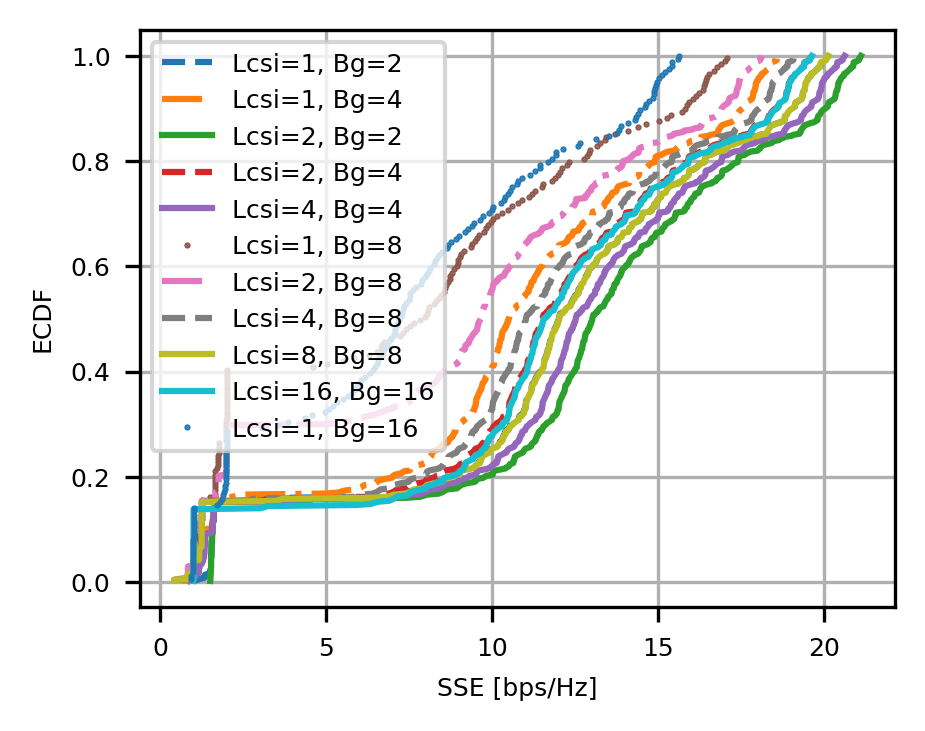

In [ ]:
def op_lookup(operations, lcsi=1, bwp=8, ncri=16, nrb=24, bg=4):
    index = np.where(np.all(np.array(operations)==np.array([lcsi, bwp, ncri, nrb, bg]), axis=1))
    if len(index[0]) < 1:
        print("No matching set found")
    elif len(index[0]) > 1:
        print("Somehow found more than one matching...")
    return index[0]

# these are bg and Lcsi
comparison_points = [[2, 1], [4, 1], [2, 2], [4,2], [4, 4], [8, 1], [8, 2], [8,4], [8, 8], [16, 16], [16, 1]] # ['Ncsi=4, Lcsi=1', 'Ncsi=4, Lcsi=4', 'Ncsi=16, Lcsi=1', 'Ncsi=16, Lcsi=4', 'Ncsi=16, Lcsi=16']
ratios = [1/2, 1/4, 1, 1/2, 1, 1/8, 1/4, 1/2, 1, 1, 1/8]
linestyles = {1:'-', 1/2:'--', 1/4:'-.', 1/8:'.'}

indexes = np.array([op_lookup(operations, lcsi=comparison_points[i][1], bg=comparison_points[i][0], bwp=8, ncri=16) for i in range(len(comparison_points))])
se_subset = SSE[indexes, :]


for i in range(len(comparison_points)):
    ecdf = ECDF(se_subset[i, 0, se_subset[i, 0]>00])
    plt.plot(ecdf.x, ecdf.y, linestyles[ratios[i]], markevery=3, markersize=1, label=f"Lcsi={comparison_points[i][1]}, Bg={comparison_points[i][0]}")

plt.legend()
plt.grid()
plt.xlabel("SSE [bps/Hz]")
plt.ylabel("ECDF")
# plt.xlim([10, 27])
# plt.savefig(path + f'results/feedback_comparison.pdf', bbox_inches='tight')
plt.show()

In [ ]:
method = 'DFT'
int_snr = int(logx(SNR_offset))

df.to_pickle(path+f'results/raw/df_{int_snr}_{method}_{n_mc}MC.pickle')
np.save(path+f'results/raw/SE_{int_snr}_{method}_{n_mc}MC.npy', SSE)
np.save(path+f'results/raw/{int_snr}_{method}_{n_mc}ops.npy', operations)
np.save(path+f'results/raw/{int_snr}_n_ue{method}.npy', n_UE)
# df = pd.read_pickle(file_name)

In [ ]:
# ML version

np.random.seed(1)
# def run():
gc.collect()
n_mc = 1000
Lcsi_set = np.array([1, 2, 4, 8, 16])
BWP_set = [8]
n_cri_set = [16]
N_RB_set = np.array([1])*24
n_UE_min = 6
n_UE_max = 14
beam_groups = [1, 2, 4, 8, 16]

SNR_offset = 10000000

operations = list(product(Lcsi_set, BWP_set, n_cri_set, N_RB_set, beam_groups))

print(f"Running {n_mc}x{len(operations)} rounds")
errors = np.zeros((len(operations), n_mc))
SSE = np.zeros_like(errors)
df = pd.DataFrame(columns=['Pcsi', 'Lcsi', 'BWP', 'N_RB', 'BG', 'Overhead', 'Error', 'SSE', 'avg U'])

n_UE = np.random.choice(np.arange(n_UE_min, n_UE_max), size=(n_mc))
default_codebook = DFT_codebook(n_beams=Lmax, Nx=Nx, Ny=Ny)

for m in range(n_mc):
    UEs = np.random.choice(np.arange(5000), replace=False, size=(n_UE[m]))
    # Tstart = np.random.choice(np.arange(250))
    Tstart = 0

    # H_ident = np.repeat(channel_set[UEs].reshape(-1, 1, 1, Nr, Nt), Ktotal, axis=2) * SNR_offset + 1e-15
    H_ident = channel_set_test[UEs].transpose(0, 3, 4, 1, 2) * SNR_offset + 1e-15

    H_ident = H_ident.astype(ctype)

    beamspace = np.expand_dims(get_beamspace(channel_set[UEs], default_codebook), axis=0)
    ssb_beamspace, csi_rs_beamspace = xbm.predict([beamspace, 1, 1])
    # do beamspace for a model
    # ssb_powers[e, i, :], delta_svd_ssb[e, i, :], ssbri = eval_loss(channel_set[e:e+1], ssb_beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1, bits=bits)
    ssb_codebook = tf_deconvert_beamspace(ssb_beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1).numpy()

    snr, ssbri = tf_rsrp_rx_comb(H_ident[:, :, 0].transpose(1, 0, 2, 3), ssb_codebook.reshape(1, -1, Nt))

    csi_codebook_init = tf_deconvert_beamspace(csi_rs_beamspace, Lmax=Lmax*xbm.csi_per_ssb, Nx1=Nx1, Ny1=Ny1).numpy()

    snr = snr[0].numpy() + 1e-10
    for i, operate in enumerate(operations):
        lcsi = operate[0]
        bwp = operate[1]
        Nta = operate[2]
        bg = operate[4]

        if Nta >= bg and not Nta%bg: # need at least as many beams as beams per groups
            csirs_codebook = prop_sel(ssb_codebook, csi_codebook_init, ssbri, Lmax, Nta)
            np.random.shuffle(csirs_codebook)
            csirs_codebook = csirs_codebook.reshape((-1, bg, Nt))
            csirs_codebook = csirs_codebook / np.linalg.norm(csirs_codebook, axis=(-2, -1), keepdims=True) * Nt

            snr, cri = tf_rsrp_rx_comb(H_ident[:, :, 0].transpose(1, 0, 2, 3), csirs_codebook.reshape(1, -1, Nt))
            snr = snr[0].numpy() + 1e-10
            cri = cri[0].numpy()

            nrb = operate[3]
            if lcsi <= bg: # don't run otherwise

                if bg == 1:
                    Nxeff = 1
                    Nyeff = 1
                if bg == 2:
                    Nxeff = 2
                    Nyeff = 1
                if bg == 4:
                    Nxeff = 2
                    Nyeff = 2
                if bg == 8:
                    Nxeff = 4
                    Nyeff = 2
                if bg == 16:
                    Nxeff = 4
                    Nyeff = 4

                H_a = H_ident[:, :, :, :, :Nt]

                H_estimates, CQI, Feff = H_est(H_a, beams=csirs_codebook, CRI=cri, SNR=snr, N_RB=nrb, Lcsi=lcsi, BWP=bwp, Nx=Nxeff, Ny=Nyeff, OH=4, OV=4, return_cqi=True)
                Feff = Feff * 4
                H_estimates = np.expand_dims(H_estimates, axis=1) +1e-15

                if np.any(np.isnan(H_estimates)) or np.any(np.isnan(CQI)) or np.any(np.isnan(snr)) or np.any(np.isnan(H_a)):
                    print("THERE WAS A NAN, snrs were ", snr)
                    print(f"{np.sum(np.isnan(H_estimates))}/{H_estimates.size}")
                SSE[i, m], active_ues[i, m] = sum_SE_true(H_estimates, snr, CQI, np.einsum('utkrn,uln->utkrl',H_a, Feff)+1e-15, mean_over_time=True, Umax=(Nxd*Nyd)//bg, Ns_max=min(4, bg))
    if n_mc > 20:
        if not (m+1) % (n_mc//20):
            print(f"{m+1}/{n_mc} complete")

for i, operate in enumerate(operations):
    lcsi = operate[0]
    bwp = operate[1]
    Nta = operate[2]
    nrb = operate[3]
    bg = operate[4]
    overhead = (tx_loss_per_csi(N_RB=nrb) + feedback_loss_per_csi(len(H_a), RI=min(4, nrb), Lcsi=lcsi, BWP=bwp, Nx=Nxeff, Ny=Nyeff) )/ total_RE
    df.loc[i] = {'Pcsi': Nta, 'Lcsi': lcsi, 'BWP' : bwp, 'N_RB' : nrb, 'BG' : bg, 'Overhead': overhead, 'Error': np.mean(errors[i]), 'SSE': np.mean(SSE[i])*(1-overhead), 'avg U': np.mean(active_ues[i])}


print(df)


Running 1000x25 rounds
Generating codebook for 16 from size 16x16x1x1
50/1000 complete
100/1000 complete
150/1000 complete
200/1000 complete
250/1000 complete
300/1000 complete
350/1000 complete
400/1000 complete
450/1000 complete
500/1000 complete


IndexError: ignored

In [ ]:
method = 'XBM'
int_snr = int(logx(SNR_offset))

df.to_pickle(path+f'results/raw/df_{int_snr}_{method}_{n_mc}MC.pickle')
np.save(path+f'results/raw/SE_{int_snr}_{method}_{n_mc}MC.npy', SSE)
np.save(path+f'results/raw/{int_snr}_{method}_{n_mc}ops.npy', operations)
np.save(path+f'results/raw/{int_snr}_n_ue{method}.npy', n_UE)


In [ ]:
# ML version

np.random.seed(1)
# def run():
gc.collect()
n_mc = 3000
Lcsi_set = np.array([1, 2, 4, 8, 16])
BWP_set = [4]
n_cri_set = [16]
N_RB_set = np.array([1])*24
n_UE_min = 6
n_UE_max = 14
beam_groups = [1, 2, 4, 8, 16]

SNR_offset = 10000000000000

operations = list(product(Lcsi_set, BWP_set, n_cri_set, N_RB_set, beam_groups))

print(f"Running {n_mc}x{len(operations)} rounds")
errors = np.zeros((len(operations), n_mc))
SSE = np.zeros_like(errors)
df = pd.DataFrame(columns=['Pcsi', 'Lcsi', 'BWP', 'N_RB', 'Overhead', 'Error', 'SSE'])

n_UE = np.random.choice(np.arange(n_UE_min, n_UE_max), size=(n_mc))
default_codebook = DFT_codebook(n_beams=Lmax, Nx=Nx, Ny=Ny)

for m in range(n_mc):
    UEs = np.random.choice(np.arange(5000), replace=False, size=(n_UE[m]))
    Tstart = 0

    H_ident = channel_set_test[UEs].transpose(0, 3, 4, 1, 2) * SNR_offset + 1e-15

    H_ident = H_ident.astype(ctype)

    beamspace = np.expand_dims(get_beamspace(channel_set[UEs], default_codebook), axis=0)
    ssb_beamspace, csi_rs_beamspace = xbm.predict([beamspace, 1, 1])
    # do beamspace for a model
    ssb_codebook = tf_deconvert_beamspace(ssb_beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1).numpy()

    snr, ssbri = tf_rsrp_rx_comb(H_ident[:, :, 0].transpose(1, 0, 2, 3), ssb_codebook.reshape(1, -1, Nt))

    csi_codebook_init = tf_deconvert_beamspace(csi_rs_beamspace, Lmax=Lmax*xbm.csi_per_ssb, Nx1=Nx1, Ny1=Ny1).numpy()

    snr = snr[0].numpy() + 1e-10
    for i, operate in enumerate(operations):
        lcsi = operate[0]
        bwp = operate[1]
        Nta = operate[2]
        bg = operate[4]

        if Nta >= bg and not Nta%bg: # need at least as many beams as beams per groups
            csirs_codebook = prop_sel(ssb_codebook, csi_codebook_init, ssbri, Lmax, Nta)
            np.random.shuffle(csirs_codebook)
            csirs_codebook = csirs_codebook.reshape((-1, bg, Nt))
            csirs_codebook = csirs_codebook / np.linalg.norm(csirs_codebook, axis=(-2, -1), keepdims=True) * Nt

            snr, cri = tf_rsrp_rx_comb(H_ident[:, :, 0].transpose(1, 0, 2, 3), csirs_codebook.reshape(1, -1, Nt))
            snr = snr[0].numpy() + 1e-10
            cri = cri[0].numpy()

            nrb = operate[3]
            if lcsi <= bg: # don't run otherwise
                if bg == 1:
                    Nxeff = 1
                    Nyeff = 1
                if bg == 2:
                    Nxeff = 2
                    Nyeff = 1
                if bg == 4:
                    Nxeff = 2
                    Nyeff = 2
                if bg == 8:
                    Nxeff = 4
                    Nyeff = 2
                if bg == 16:
                    Nxeff = 4
                    Nyeff = 4

                H_a = H_ident[:, :, :, :, :Nt]

                H_estimates, CQI, Feff = H_est(H_a, beams=csirs_codebook, CRI=cri, SNR=snr, N_RB=nrb, Lcsi=lcsi, BWP=bwp, Nx=Nxeff, Ny=Nyeff, OH=4, OV=4, return_cqi=True)
                Feff = Feff * 4
                H_estimates = np.expand_dims(H_estimates, axis=1) +1e-15

                if np.any(np.isnan(H_estimates)) or np.any(np.isnan(CQI)) or np.any(np.isnan(snr)) or np.any(np.isnan(H_a)):
                    print("THERE WAS A NAN, snrs were ", snr)
                    print(f"{np.sum(np.isnan(H_estimates))}/{H_estimates.size}")
                SSE[i, m] = sum_SE_true(H_estimates, snr, CQI, np.einsum('utkrn,uln->utkrl',H_a, Feff)+1e-15, mean_over_time=True, Umax=8, Ns_max=2)
    if n_mc > 20:
        if not (m+1) % (n_mc//20):
            print(f"{m+1}/{n_mc} complete")

for i, operate in enumerate(operations):
    lcsi = operate[0]
    bwp = operate[1]
    Nta = operate[2]
    nrb = operate[3]
    bg = operate[4]
    overhead = (tx_loss_per_csi(N_RB=nrb) + feedback_loss_per_csi(len(H_a), RI=min(4, nrb), Lcsi=lcsi, BWP=bwp, Nx=Nxeff, Ny=Nyeff) )/ total_RE
    df.loc[i] = {'Pcsi': Nta, 'Lcsi': lcsi, 'BWP' : bwp, 'N_RB' : nrb, 'BG' : bg, 'Overhead': overhead, 'Error': np.mean(errors[i]), 'SSE': np.mean(SSE[i])*(1-overhead)}


print(df)



Running 3000x25 rounds
Generating codebook for 16 from size 16x16x1x1


/tmp/ipykernel_5812/406832372.py:121: RuntimeWarning:

invalid value encountered in log2

/tmp/ipykernel_5812/406832372.py:205: RuntimeWarning:

invalid value encountered in log2



150/3000 complete
300/3000 complete
450/3000 complete
600/3000 complete
750/3000 complete
900/3000 complete
1050/3000 complete
1200/3000 complete
1350/3000 complete
1500/3000 complete
1650/3000 complete
1800/3000 complete
1950/3000 complete
2100/3000 complete
2250/3000 complete
2400/3000 complete
2550/3000 complete
2700/3000 complete
2850/3000 complete
3000/3000 complete
    Pcsi  Lcsi  BWP  N_RB  Overhead  Error  SSE
0     16     1    4    24  0.028942    0.0  NaN
1     16     1    4    24  0.028942    0.0  NaN
2     16     1    4    24  0.028942    0.0  NaN
3     16     1    4    24  0.028942    0.0  NaN
4     16     1    4    24  0.028942    0.0  NaN
5     16     2    4    24  0.028942    0.0  0.0
6     16     2    4    24  0.028942    0.0  NaN
7     16     2    4    24  0.028942    0.0  NaN
8     16     2    4    24  0.028942    0.0  NaN
9     16     2    4    24  0.028942    0.0  NaN
10    16     4    4    24  0.028942    0.0  0.0
11    16     4    4    24  0.028942    0.0  0.0
12

In [ ]:
method = 'XBM'
int_snr = int(logx(SNR_offset))

df.to_pickle(path+f'results/raw/df_{int_snr}_{method}_{n_mc}MC.pickle')
np.save(path+f'results/raw/SE_{int_snr}_{method}_{n_mc}MC.npy', SSE)
np.save(path+f'results/raw/{int_snr}_{method}_{n_mc}ops.npy', operations)
np.save(path+f'results/raw/{int_snr}_n_ue{method}.npy', n_UE)


In [ ]:
np.save(path+f'results/raw/SE_rank1-2.npy', SSE)

In [ ]:
np.save(path+f'results/raw/SE_ABC-4.npy', SSE)

In [ ]:
# new results for ML
df.loc[(df['N_RB'] == 24)]

Pcsi  Lcsi  BWP  N_RB  Overhead  Error        SSE
0      4     1    1    24  0.029868    0.0   9.685808
1      8     1    1    24  0.029868    0.0   9.512032
2     12     1    1    24  0.029868    0.0   9.887571
3     16     1    1    24  0.029868    0.0   9.798632
4      4     1    2    24  0.029868    0.0   9.835475
5      8     1    2    24  0.029868    0.0   9.328426
6     12     1    2    24  0.029868    0.0   9.674008
7     16     1    2    24  0.029868    0.0   9.777089
8      4     1    4    24  0.029868    0.0   9.671392
9      8     1    4    24  0.029868    0.0   9.526318
10    12     1    4    24  0.029868    0.0   9.766898
11    16     1    4    24  0.029868    0.0   9.903781
12     4     1    8    24  0.029868    0.0   9.975502
13     8     1    8    24  0.029868    0.0   9.410433
14    12     1    8    24  0.029868    0.0   9.931541
15    16     1    8    24  0.029868    0.0   9.836350
16     4     2    1    24  0.029868    0.0  12.816523
17     8     2    1    24  0.029868    0.0  14.042373
18    12     2    1    24  0.029868    0.0  14.541100
19    16     2    1    24  0.029868    0.0  14.890298
20     4     2    2    24  0.029868    0.0  12.897622
21     8     2    2    24  0.029868    0.0  13.900663
22    12     2    2    24  0.029868    0.0  14.589586
23    16     2    2    24  0.029868    0.0  14.992447
24     4     2    4    24  0.029868    0.0  13.027169
25     8     2    4    24  0.029868    0.0  14.222554
26    12     2    4    24  0.029868    0.0  14.612092
27    16     2    4    24  0.029868    0.0  14.899274
28     4     2    8    24  0.029868    0.0  13.004788
29     8     2    8    24  0.029868    0.0  14.199613
30    12     2    8    24  0.029868    0.0  14.539157
31    16     2    8    24  0.029868    0.0  14.891712
32     4     4    1    24  0.029868    0.0  15.327038
33     8     4    1    24  0.029868    0.0  16.648260
34    12     4    1    24  0.029868    0.0  17.032446
35    16     4    1    24  0.029868    0.0  17.213677
36     4     4    2    24  0.029868    0.0  15.193564
37     8     4    2    24  0.029868    0.0  16.565498
38    12     4    2    24  0.029868    0.0  17.057689
39    16     4    2    24  0.029868    0.0  17.304010
40     4     4    4    24  0.029868    0.0  15.207196
41     8     4    4    24  0.029868    0.0  16.594025
42    12     4    4    24  0.029868    0.0  16.992399
43    16     4    4    24  0.029868    0.0  17.287953
44     4     4    8    24  0.029868    0.0  15.252531
45     8     4    8    24  0.029868    0.0  16.624302
46    12     4    8    24  0.029868    0.0  17.027961
47    16     4    8    24  0.029868    0.0  17.194423

In [ ]:
m

3791

In [ ]:
n_UE[:10]

array([11, 17, 18, 14, 15, 17, 11,  6,  6,  7])

In [ ]:
method = 'XBM'

df.to_pickle(path+f'results/raw/df_{method}_{n_mc}MC.pickle')
np.save(path+f'results/raw/SE_{method}_{n_mc}MC.npy', SSE)
np.save(path+f'results/raw/{method}_ops.npy', operations)
np.save(path+f'results/raw/n_ue{method}.npy', n_UE)
# df = pd.read_pickle(file_name)

In [ ]:
# old results for DFT
df.loc[(df['N_RB'] == 24)]

Pcsi  Lcsi  BWP  N_RB  Overhead  Error        SSE
0       4     1    1    24  0.030238    0.0   8.117044
3       8     1    1    24  0.030238    0.0   7.770335
6      12     1    1    24  0.030238    0.0   8.563146
9      16     1    1    24  0.030238    0.0   8.609855
12      4     1    2    24  0.030238    0.0   8.537087
15      8     1    2    24  0.030238    0.0   7.634015
18     12     1    2    24  0.030238    0.0   8.284221
21     16     1    2    24  0.030238    0.0   8.551994
24      4     1    4    24  0.030238    0.0   8.047067
27      8     1    4    24  0.030238    0.0   7.946175
30     12     1    4    24  0.030238    0.0   8.267170
33     16     1    4    24  0.030238    0.0   8.562849
36      4     1    8    24  0.030238    0.0   8.108041
39      8     1    8    24  0.030238    0.0   7.948655
42     12     1    8    24  0.030238    0.0   8.814731
45     16     1    8    24  0.030238    0.0   8.935081
48      4     2    1    24  0.030238    0.0  12.449240
51      8     2    1    24  0.030238    0.0  13.651895
54     12     2    1    24  0.030238    0.0  14.120680
57     16     2    1    24  0.030238    0.0  14.720811
60      4     2    2    24  0.030238    0.0  12.240368
63      8     2    2    24  0.030238    0.0  13.407294
66     12     2    2    24  0.030238    0.0  13.998978
69     16     2    2    24  0.030238    0.0  14.918225
72      4     2    4    24  0.030238    0.0  12.453967
75      8     2    4    24  0.030238    0.0  13.479416
78     12     2    4    24  0.030238    0.0  14.061711
81     16     2    4    24  0.030238    0.0  14.658313
84      4     2    8    24  0.030238    0.0  12.447709
87      8     2    8    24  0.030238    0.0  13.712856
90     12     2    8    24  0.030238    0.0  14.239064
93     16     2    8    24  0.030238    0.0  14.604465
96      4     4    1    24  0.030238    0.0  15.254253
99      8     4    1    24  0.030238    0.0  16.489534
102    12     4    1    24  0.030238    0.0  16.732245
105    16     4    1    24  0.030238    0.0  17.549563
108     4     4    2    24  0.030238    0.0  15.366994
111     8     4    2    24  0.030238    0.0  16.509544
114    12     4    2    24  0.030238    0.0  16.788642
117    16     4    2    24  0.030238    0.0  17.298901
120     4     4    4    24  0.030238    0.0  15.524001
123     8     4    4    24  0.030238    0.0  16.643576
126    12     4    4    24  0.030238    0.0  16.923508
129    16     4    4    24  0.030238    0.0  17.222637
132     4     4    8    24  0.030238    0.0  15.349369
135     8     4    8    24  0.030238    0.0  16.575057
138    12     4    8    24  0.030238    0.0  16.880426
141    16     4    8    24  0.030238    0.0  17.108373

In [ ]:
df.loc[(df['N_RB'] == 24) & (df['Pcsi']==4)]
# increasing RB is always bad
# Increasing Pcsi without increasing Lcsi is bad
# increasing BWP is generally helpful, but not BWP=2
# increasing Lcsi is always helpful

Pcsi  Lcsi  BWP  N_RB  Overhead  Error        SSE
0       4     1    1    24  0.030238    0.0   7.447438
12      4     1    2    24  0.030238    0.0   7.367896
24      4     1    4    24  0.030238    0.0   7.479923
36      4     1    8    24  0.030238    0.0   7.514246
48      4     2    1    24  0.030238    0.0  13.386394
60      4     2    2    24  0.030238    0.0  13.156522
72      4     2    4    24  0.030238    0.0  13.319296
84      4     2    8    24  0.030238    0.0  13.498499
96      4     4    1    24  0.030238    0.0  17.002658
108     4     4    2    24  0.030238    0.0  16.957926
120     4     4    4    24  0.030238    0.0  17.143726
132     4     4    8    24  0.030238    0.0  17.120970
144     4     8    1    24  0.030238    0.0   0.000000
156     4     8    2    24  0.030238    0.0   0.000000
168     4     8    4    24  0.030238    0.0   0.000000
180     4     8    8    24  0.033386    0.0   0.000000
192     4    16    1    24  0.030238    0.0   0.000000
204     4    16    2    24  0.033386    0.0   0.000000
216     4    16    4    24  0.036534    0.0   0.000000
228     4    16    8    24  0.039683    0.0   0.000000

In [ ]:
np.random.seed(1)
df = run()

Running 50x144 rounds


KeyboardInterrupt: ignored

## visualization of beams

In [ ]:
def array_resp2(theta, N, d=0.5):
    """ Array response in direction theta where theta can be a vector of size [?, 1]
    Assumes 0 radians is boresight and +-pi/2 is endfire"""
    n = np.expand_dims(np.arange(N), 0)
    vander = np.exp((1j * np.pi * 2 * n * d * np.cos(theta))).astype(np.complex64)
    return vander


def steering_vectors(thetas, phis, Nrx=1, Nry=1, d=0.5):
    # Define the steering vector for a planar array of size Nrx by Nry with spacing (in wavelengths) d.
    # thetas and phis can have size greater than 1 for batch approaches
    n_theta = len(thetas)
    n_phi = len(phis)
    steering_mtx = np.zeros((n_theta, n_phi, Nrx, Nry), dtype=np.complex64)
    steering_xs = array_resp2(thetas, Nrx, d)
    steering_ys = array_resp2(phis, Nry, d)
    # Now cross terms to achieve the beamforming matrices
    steering_mtx[:] = np.einsum('ij,kl->ikjl', steering_xs, steering_ys)
#     for i in range(n_theta):
#         for j in range(n_phi):
#             steering_mtx[i, j, :, :] = steering_xs[i, :].T @ steering_ys[j, :]

    steering_vector = steering_mtx.reshape(n_theta, n_phi, Nrx*Nry)
    return steering_vector


# generate the steering vector matrix ahead of time
theta_plot = np.expand_dims(np.linspace(0, 180, num=180), axis=1) / 180 * np.pi
phi_plot = np.expand_dims(np.linspace(0, 180, num=180), axis=1) / 180 * np.pi

stx = steering_vectors(theta_plot, phi_plot, Nx, Ny)

def plot_directions(codebook):
    responses = np.zeros((len(codebook), len(theta_plot), len(phi_plot)), dtype=np.complex64)
    # codebook_xy = codebook.reshape([len(codebook), Nx, Ny])
    responses[:] = np.einsum('ijn,mn->mij', stx.conj(), codebook)
    responses = 2*logx(abs(responses)+1e-15)

    for i in range(len(codebook)):
        plt.figure()
        plt.imshow(responses[i].T, origin='lower', interpolation=None, extent=[0,180,0,180], vmin=-20, vmax=30)
        cbar = plt.colorbar()
        cbar.set_label("Array gain [dB]")
    # plt.colorbar()

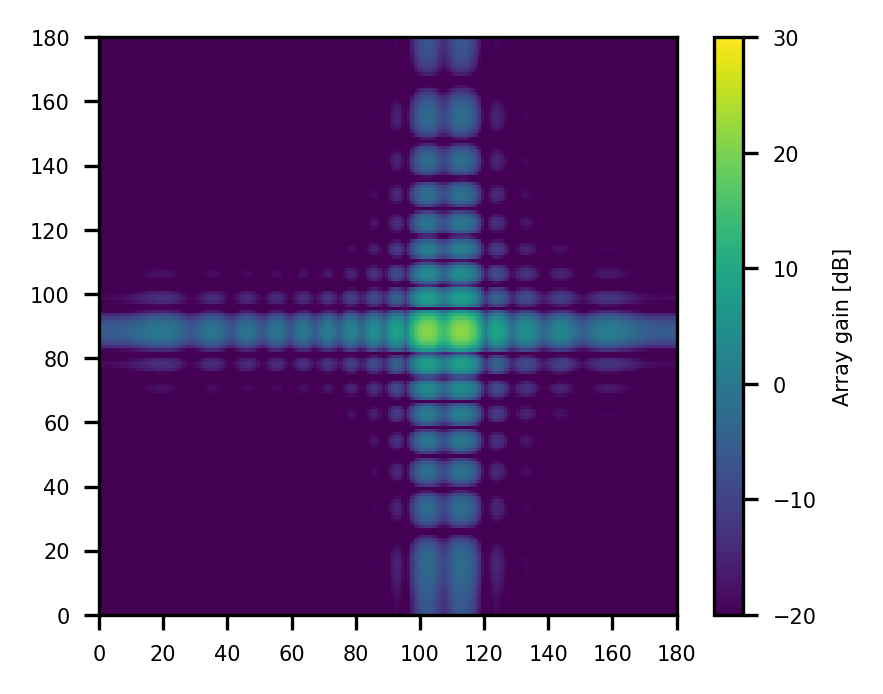

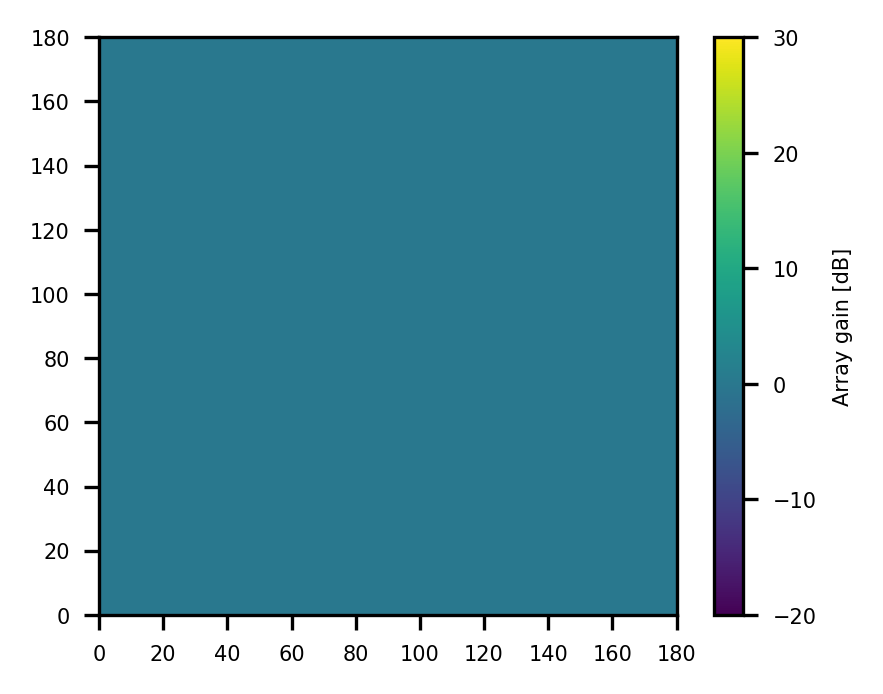

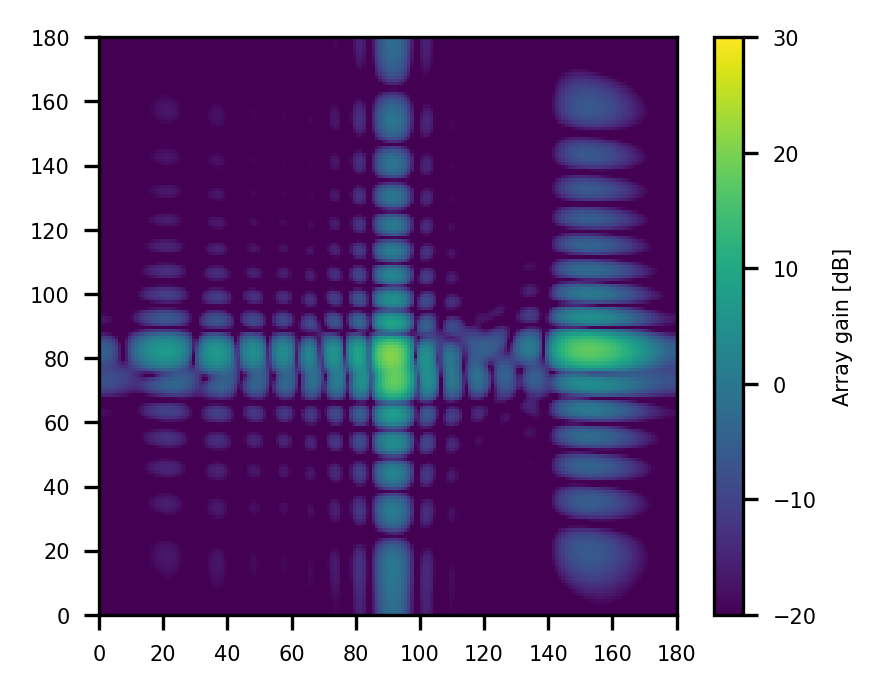

In [ ]:
plot_directions(V[0:3, 0])

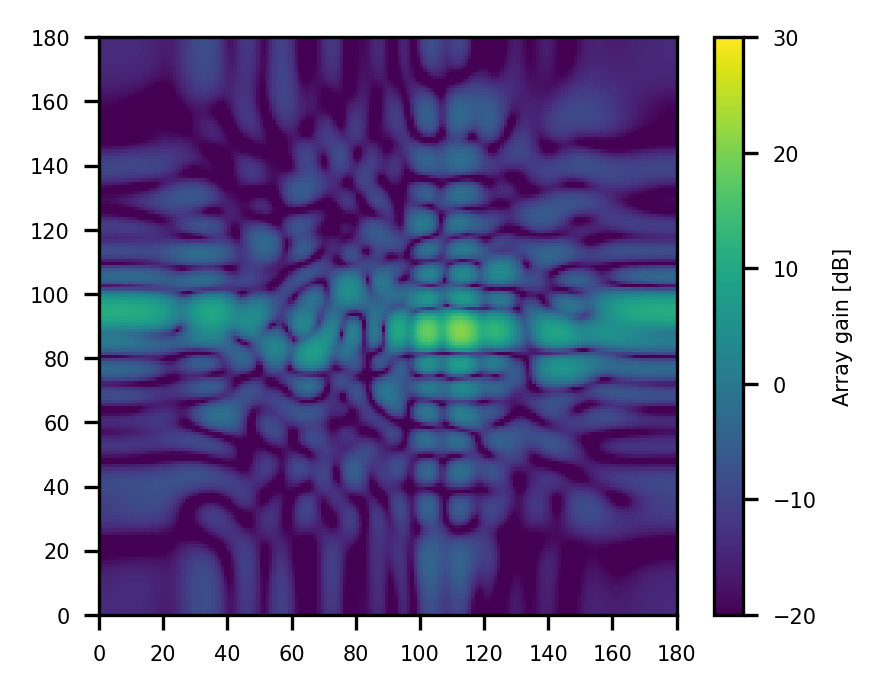

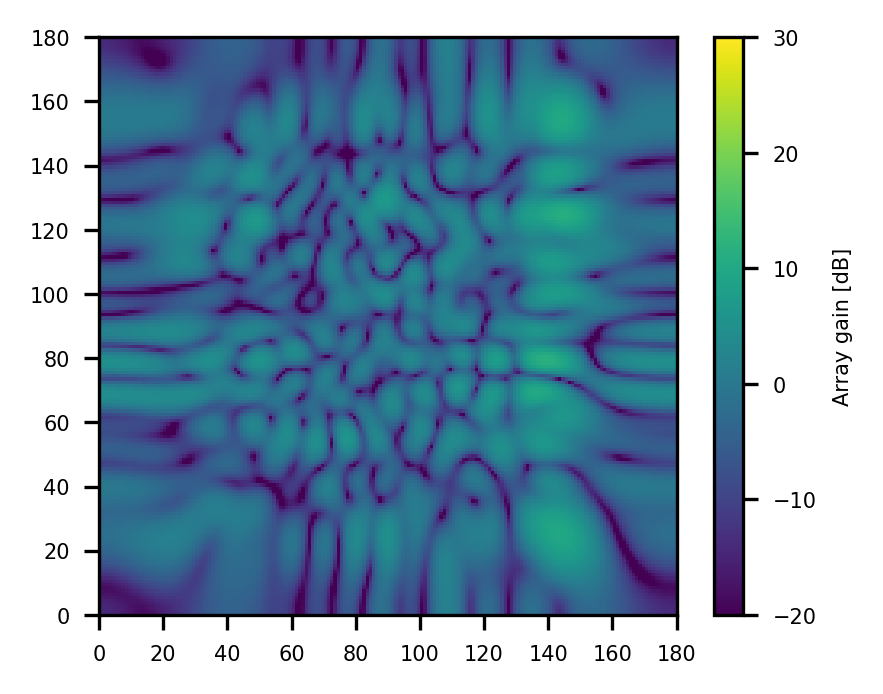

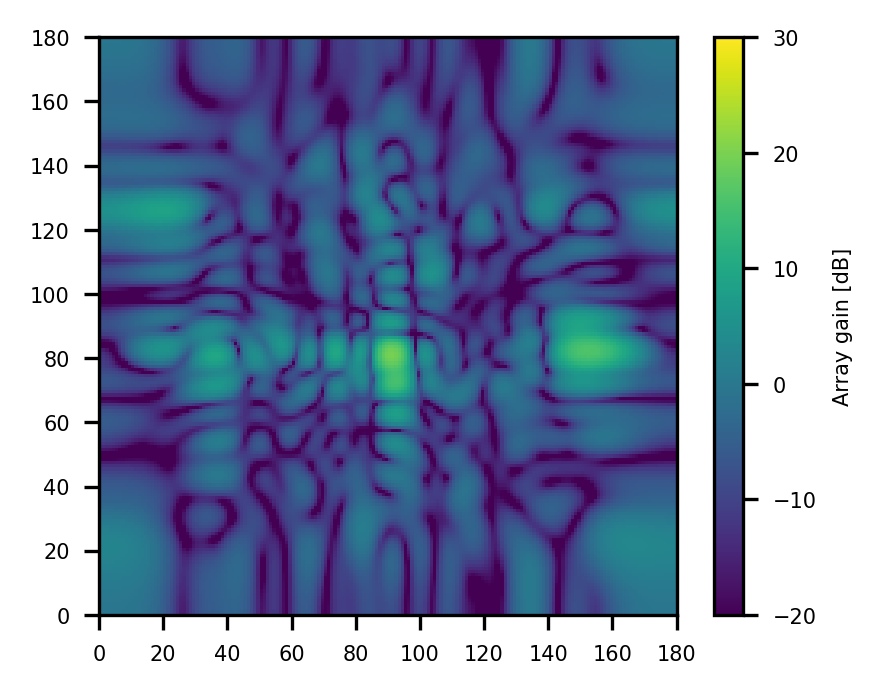

In [ ]:
plot_directions(tf.math.conj(V2[0, :3]))